Run in region ```[1000000-10000000]``` fo chromosome1 using four clusters. 


In [32]:
import sys

In [33]:
sys.path.append("../")

In [34]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
from helpers import read_configuration_file
from train import main
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType

In [36]:
# let's plot the clusters and see what we have
def plot_cluster(filename, nbins=35, kde=False, rug=True):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        cluster_0_counts = [float(item) for item in arraystr]
        sns.distplot(cluster_0_counts, bins=nbins, kde=kde, rug=rug)
        plt.show()

In [37]:
def print_hmm_info(hmm_file):
    with open(hmm_file) as json_file:
        hmm_json_map = json.load(json_file)
        hmm_json_map = json.loads(hmm_json_map)
        
        print("Start state: ")
        print("Distribution: ", hmm_json_map["start"]["distribution"])
        print("End state:")
        print("Distribution: ", hmm_json_map["end"]["distribution"])

        states = hmm_json_map["states"]
    
        for state in states:
            print("====================================================")
            print("State: ", state["name"])
            print("State weight: ", state["weight"])
            distribution = state["distribution"]

            if distribution is not None:

                print("Distribution: ", distribution["class"])

                if distribution["class"] == "Distribution":
                    print("Distribution name: ", distribution["name"])

                    if distribution["name"] == "IndependentComponentsDistribution":
                        distributions = distribution["parameters"][0]
                        for dist in distributions:

                            if dist["class"] == "GeneralMixtureModel":
                                gmm_distributions = dist["distributions"]

                                for gmm_dist in gmm_distributions:
                                    print("Distribution name: ", gmm_dist["name"])
                                    print("Distribution params: ", gmm_dist["parameters"])
                                print("Weights: ", dist["weights"])
                            else:
                                print("Distribution name: ", dist["name"])
                                print("Distribution params: ", dist["parameters"])
                                print("Weights: ", distribution["parameters"][1])
                elif distribution["class"] == "GeneralMixtureModel":
                    distributions = distribution["distributions"]

                    for dist in distributions:
                        print("Distribution name: ", dist["name"])
                        print("Distribution params: ", dist["parameters"])
                    print("Weights: ", distribution["weights"])

In [38]:
sns.set(color_codes=True)
%matplotlib inline

In [39]:
ffile = "../../"
cluster_files=[(ffile +  "cluster_0_wga_w_mean.txt", ffile +  "cluster_0_no_wga_w_mean.txt"),
               (ffile +  "cluster_1_wga_w_mean.txt", ffile +  "cluster_1_no_wga_w_mean.txt"),
               (ffile +  "cluster_2_wga_w_mean.txt", ffile +  "cluster_2_no_wga_w_mean.txt"),
               (ffile +  "cluster_3_wga_w_mean.txt", ffile +  "cluster_3_no_wga_w_mean.txt")]

Cluster:  0


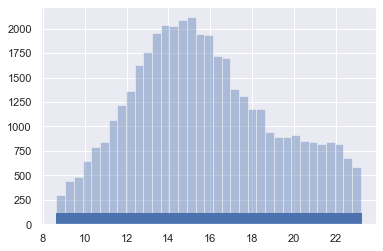

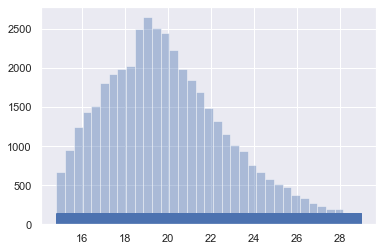

Cluster:  1


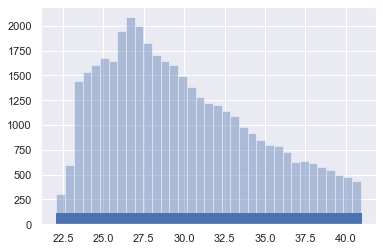

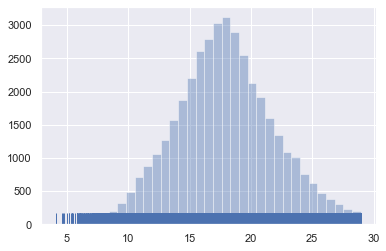

Cluster:  2


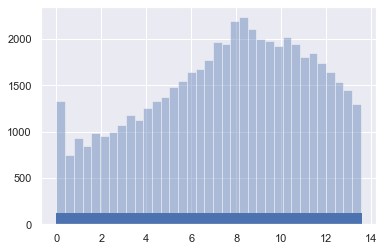

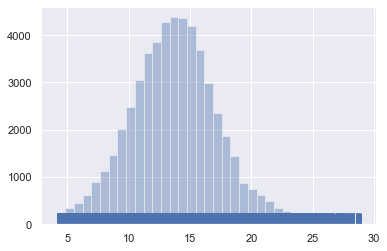

Cluster:  3


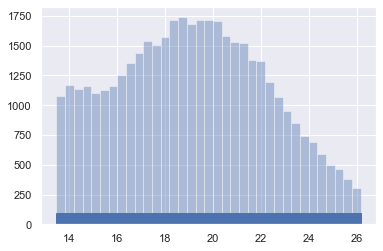

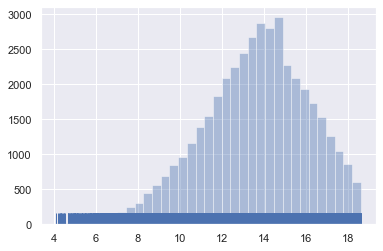

In [40]:
for i, files in enumerate(cluster_files):
    print("Cluster: ", i)
    plot_cluster(filename=files[0])
    plot_cluster(filename=files[1])

In [10]:
# load the configuration
configuration=read_configuration_file("../config.json")

In [11]:
# set up the configuration for the HMM training
clusters_config = configuration["clusters"]

In [12]:
print(clusters_config)

{'cluster_0': {'filename': '/home/a/ag568/cluster_0.txt', 'state': 'normal', 'distributions': {'wga': {'type': 'distribution', 'name': 'normal'}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}, 'cluster_1': {'filename': '/home/a/ag568/cluster_1.txt', 'state': 'tuf', 'distributions': {'wga': {'type': 'gmm', 'uniform': {'params': [2.0, 8.0]}, 'names': ['normal', 'uniform'], 'weights': None}, 'no_wga': {'type': 'gmm', 'uniform': {'params': [2.0, 8.0]}, 'names': ['normal', 'uniform'], 'weights': None}}}}


In [13]:
# which cluster is normal
cluster_0 = clusters_config['cluster_0']


In [14]:
# set the filename and the distribution
cluster_0['filename']="/home/a/ag568/cluster_0.txt"
cluster_0['state']="one_copy_delete"
cluster_0['distributions']['wga']['type'] = 'distribution'
cluster_0['distributions']['wga']['name'] = 'uniform'
cluster_0['distributions']['wga']['parameters'] = [0.0, 16.0]


In [15]:
# which cluster is TUF?
cluster_1 = clusters_config['cluster_1']

In [16]:
# set the filename and the distribution
cluster_1['filename']="/home/a/ag568/cluster_1.txt"
cluster_1['state']="tuf"
cluster_1['distributions']['wga']['type'] = 'gmm'
cluster_1['distributions']['wga']['uniform']['params'] = [2.0, 8.0]
cluster_1['distributions']['no_wga'] = {'type': 'distribution', 'name':'normal'}

In [17]:
# add one more cluster
extra_cluster = {'filename': '/home/a/ag568/cluster_2.txt', 'state': 'insertion',
                'distributions':{'wga':{'type':'distribution', 'name': 'normal'},
                                 'no_wga':{'type':'distribution', 'name': 'normal'}}}



In [18]:
clusters_config['cluster_2'] = extra_cluster


In [19]:
# add one more cluster
extra_cluster = {'filename': '/home/a/ag568/cluster_3.txt', 'state': 'normal',
                'distributions':{'wga':{'type':'distribution', 'name': 'normal'},
                                 'no_wga':{'type':'distribution', 'name': 'normal'}}}

In [20]:
clusters_config['cluster_3'] = extra_cluster

In [21]:
print(clusters_config)


{'cluster_0': {'filename': '/home/a/ag568/cluster_0.txt', 'state': 'one_copy_delete', 'distributions': {'wga': {'type': 'distribution', 'name': 'uniform', 'parameters': [0.0, 16.0]}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}, 'cluster_1': {'filename': '/home/a/ag568/cluster_1.txt', 'state': 'tuf', 'distributions': {'wga': {'type': 'gmm', 'uniform': {'params': [2.0, 8.0]}, 'names': ['normal', 'uniform'], 'weights': None}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}, 'cluster_2': {'filename': '/home/a/ag568/cluster_2.txt', 'state': 'insertion', 'distributions': {'wga': {'type': 'distribution', 'name': 'normal'}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}, 'cluster_3': {'filename': '/home/a/ag568/cluster_3.txt', 'state': 'normal', 'distributions': {'wga': {'type': 'distribution', 'name': 'normal'}, 'no_wga': {'type': 'distribution', 'name': 'normal'}}}}


In [22]:
hmm_states = configuration["HMM"]["states"]

In [23]:
print(hmm_states)

{'tuf': {'start_prob': 0.48}, 'normal': {'start_prob': 0.48}, 'gap_state': {'start_prob': 0.04}}


In [24]:
hmm_states['tuf']['start_prob'] = 0.025
hmm_states['normal']['start_prob'] = 0.9
hmm_states['gap_state']['start_prob'] = 0.025
hmm_states['one_copy_delete'] = { "start_prob":0.025}
hmm_states['insertion'] = { "start_prob":0.025}

In [25]:
print(hmm_states)

{'tuf': {'start_prob': 0.025}, 'normal': {'start_prob': 0.9}, 'gap_state': {'start_prob': 0.025}, 'one_copy_delete': {'start_prob': 0.025}, 'insertion': {'start_prob': 0.025}}


In [26]:
# we also need to add the extra transition
hmm_transitions =  configuration["HMM"]["transitions"]

In [27]:

print(hmm_transitions)

{'tuf-tuf': 0.95, 'normal-normal': 0.95, 'tuf-normal': 0.05, 'normal-tuf': 0.05, 'gap_state-gap_state': 0.95, 'gap_state-tuf': 0.05, 'tuf-gap_state': 0.05, 'normal-gap_state': 0.05, 'gap_state-normal': 0.05}


In [28]:
hmm_transitions["one_copy_delete-one_copy_delete"] = 0.95
hmm_transitions["one_copy_delete-normal"] = 0.05
hmm_transitions["normal-one_copy_delete"] = 0.05
hmm_transitions["tuf-one_copy_delete"] = 0.05
hmm_transitions["one_copy_delete-tuf"] = 0.05
hmm_transitions["gap_state-one_copy_delete"] = 0.05
hmm_transitions["one_copy_delete-gap_state"] = 0.05
hmm_transitions["one_copy_delete-insertion"] = 0.05
hmm_transitions["insertion-one_copy_delete"] = 0.05

hmm_transitions["insertion-insertion"] = 0.95
hmm_transitions["insertion-normal"] = 0.05
hmm_transitions["normal-insertion"] = 0.05
hmm_transitions["tuf-insertion"] = 0.05
hmm_transitions["insertion-tuf"] = 0.05
hmm_transitions["gap_state-insertion"] = 0.05
hmm_transitions["insertion-gap_state"] = 0.05


In [29]:
#print(hmm_transitions)

In [30]:
#print(configuration)

In [31]:
# now we can train
main(configuration=configuration)

INFO: Set up logger
INFO: Done...
INFO: Load regions...
INFO: Check window sanity for region 0
INFO: Done...
INFO: Load clusters
INFO: Done. Execution time 0.003945454023778439 secs
INFO: Build cluster densities
INFO: Cluster state: one_copy_delete
INFO: Cluster name: cluster_0
INFO: Cluster state: tuf
INFO: Cluster name: cluster_1
INFO: Cluster state: insertion
INFO: Cluster name: cluster_2
INFO: Cluster state: normal
INFO: Cluster name: cluster_3
INFO: Done. Execution time 0.0018986379727721214 secs
INFO: Star HMM initialization...
INFO: State: GAP_STATE
INFO: Distributions: {'class': 'Distribution', 'name': 'IndependentComponentsDistribution', 'parameters': [[{'class': 'Distribution', 'name': 'UniformDistribution', 'parameters': [-999.5, -998.5], 'frozen': False}, {'class': 'Distribution', 'name': 'UniformDistribution', 'parameters': [-999.5, -998.5], 'frozen': False}], [1.0, 1.0]], 'frozen': False}
INFO: State: one_copy_delete
INFO: Distributions: {'class': 'Distribution', 'name': 

[13] Improvement: 17.402278771631245	Time (s): 0.02293
INFO: learning_rate: 0.9399108431775292
INFO: n_seen_batches: 0
INFO: epoch: 13
INFO: improvement: 17.402278771631245
INFO: total_improvement: 1770.4340009984553
INFO: log_probability: -22318.553801794154
INFO: last_log_probability: -22335.956080565786
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856813.0866783
INFO: epoch_end_time: 1590856813.1096091
INFO: duration: 0.02293086051940918
[14] Improvement: 15.721756362381711	Time (s): 0.02212
INFO: learning_rate: 0.9425650822501482
INFO: n_seen_batches: 0
INFO: epoch: 14
INFO: improvement: 15.721756362381711
INFO: total_improvement: 1786.155757360837
INFO: log_probability: -22302.832045431773
INFO: last_log_probability: -22318.553801794154
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856813.1098344
INFO: epoch_end_time: 1590856813.131953
INFO: duration: 0.022118568420410156
[15] Improvement: 14.342531302401767	Time (s)

[31] Improvement: 4.992330573804793	Time (s): 0.02248
INFO: learning_rate: 0.9653980771547576
INFO: n_seen_batches: 0
INFO: epoch: 31
INFO: improvement: 4.992330573804793
INFO: total_improvement: 1930.3644640083621
INFO: log_probability: -22158.623338784248
INFO: last_log_probability: -22163.615669358052
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856813.4907823
INFO: epoch_end_time: 1590856813.5132625
INFO: duration: 0.022480249404907227
[32] Improvement: 4.7536705982238345	Time (s): 0.02559
INFO: learning_rate: 0.9661136533396772
INFO: n_seen_batches: 0
INFO: epoch: 32
INFO: improvement: 4.7536705982238345
INFO: total_improvement: 1935.118134606586
INFO: log_probability: -22153.869668186024
INFO: last_log_probability: -22158.623338784248
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856813.5146132
INFO: epoch_end_time: 1590856813.5402014
INFO: duration: 0.025588274002075195
[33] Improvement: 4.5365674398963165	Time (s)

[49] Improvement: 2.433647776113503	Time (s): 0.0221
INFO: learning_rate: 0.9744870388302238
INFO: n_seen_batches: 0
INFO: epoch: 49
INFO: improvement: 2.433647776113503
INFO: total_improvement: 1991.5763419884752
INFO: log_probability: -22097.411460804135
INFO: last_log_probability: -22099.845108580248
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856813.9056666
INFO: epoch_end_time: 1590856813.9277675
INFO: duration: 0.02210092544555664
[50] Improvement: 2.3536528346267005	Time (s): 0.0227
INFO: learning_rate: 0.9748314815896065
INFO: n_seen_batches: 0
INFO: epoch: 50
INFO: improvement: 2.3536528346267005
INFO: total_improvement: 1993.9299948231019
INFO: log_probability: -22095.057807969508
INFO: last_log_probability: -22097.411460804135
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856813.9279444
INFO: epoch_end_time: 1590856813.9506485
INFO: duration: 0.022704124450683594
[51] Improvement: 2.2805488949124992	Time (s): 

INFO: n_seen_batches: 0
INFO: epoch: 67
INFO: improvement: 1.472581908954453
INFO: total_improvement: 2025.0894853625614
INFO: log_probability: -22063.89831743005
INFO: last_log_probability: -22065.370899339003
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856814.308835
INFO: epoch_end_time: 1590856814.3297944
INFO: duration: 0.02095937728881836
[68] Improvement: 1.4377481878254912	Time (s): 0.02161
INFO: learning_rate: 0.9795595071378708
INFO: n_seen_batches: 0
INFO: epoch: 68
INFO: improvement: 1.4377481878254912
INFO: total_improvement: 2026.5272335503869
INFO: log_probability: -22062.460569242223
INFO: last_log_probability: -22063.89831743005
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856814.3311374
INFO: epoch_end_time: 1590856814.3527508
INFO: duration: 0.021613359451293945
[69] Improvement: 1.404201963730884	Time (s): 0.02143
INFO: learning_rate: 0.9797614615027326
INFO: n_seen_batches: 0
INFO: epoch: 69
INFO: im

[85] Improvement: 1.0005539971571125	Time (s): 0.02202
INFO: learning_rate: 0.982445174593624
INFO: n_seen_batches: 0
INFO: epoch: 85
INFO: improvement: 1.0005539971571125
INFO: total_improvement: 2046.6855821524296
INFO: log_probability: -22042.30222064018
INFO: last_log_probability: -22043.302774637337
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856814.7140837
INFO: epoch_end_time: 1590856814.736105
INFO: duration: 0.02202129364013672
[86] Improvement: 0.9836532237895881	Time (s): 0.02314
INFO: learning_rate: 0.9825850544539158
INFO: n_seen_batches: 0
INFO: epoch: 86
INFO: improvement: 0.9836532237895881
INFO: total_improvement: 2047.6692353762191
INFO: log_probability: -22041.31856741639
INFO: last_log_probability: -22042.30222064018
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856814.7370944
INFO: epoch_end_time: 1590856814.7602303
INFO: duration: 0.023135900497436523
[87] Improvement: 0.9635128464178706	Time (s): 0

[103] Improvement: 0.7297886311826005	Time (s): 0.02243
INFO: learning_rate: 0.9846103946846178
INFO: n_seen_batches: 0
INFO: epoch: 103
INFO: improvement: 0.7297886311826005
INFO: total_improvement: 2061.925851175216
INFO: log_probability: -22027.061951617394
INFO: last_log_probability: -22027.791740248576
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856815.1275148
INFO: epoch_end_time: 1590856815.1499436
INFO: duration: 0.02242875099182129
[104] Improvement: 0.7182390293601202	Time (s): 0.02194
INFO: learning_rate: 0.9847121685601014
INFO: n_seen_batches: 0
INFO: epoch: 104
INFO: improvement: 0.7182390293601202
INFO: total_improvement: 2062.644090204576
INFO: log_probability: -22026.343712588034
INFO: last_log_probability: -22027.061951617394
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856815.1513646
INFO: epoch_end_time: 1590856815.173304
INFO: duration: 0.021939516067504883
[105] Improvement: 0.7069793711489183	Time

[121] Improvement: 0.560090382979979	Time (s): 0.02238
INFO: learning_rate: 0.9862238959816888
INFO: n_seen_batches: 0
INFO: epoch: 121
INFO: improvement: 0.560090382979979
INFO: total_improvement: 2073.342290543991
INFO: log_probability: -22015.64551224862
INFO: last_log_probability: -22016.2056026316
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856815.5328345
INFO: epoch_end_time: 1590856815.5552106
INFO: duration: 0.022376060485839844
[122] Improvement: 0.5525662283798738	Time (s): 0.02218
INFO: learning_rate: 0.986301758715704
INFO: n_seen_batches: 0
INFO: epoch: 122
INFO: improvement: 0.5525662283798738
INFO: total_improvement: 2073.894856772371
INFO: log_probability: -22015.09294602024
INFO: last_log_probability: -22015.64551224862
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856815.5563152
INFO: epoch_end_time: 1590856815.5784988
INFO: duration: 0.022183656692504883
[123] Improvement: 0.5452079179340217	Time (s): 

INFO: n_seen_batches: 0
INFO: epoch: 139
INFO: improvement: 0.44670703974406933
INFO: total_improvement: 2082.281773778326
INFO: log_probability: -22006.706029014284
INFO: last_log_probability: -22007.152736054028
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856815.9359179
INFO: epoch_end_time: 1590856815.957265
INFO: duration: 0.0213470458984375
[140] Improvement: 0.4415782199212117	Time (s): 0.02217
INFO: learning_rate: 0.9875417181974117
INFO: n_seen_batches: 0
INFO: epoch: 140
INFO: improvement: 0.4415782199212117
INFO: total_improvement: 2082.7233519982474
INFO: log_probability: -22006.264450794362
INFO: last_log_probability: -22006.706029014284
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856815.9585602
INFO: epoch_end_time: 1590856815.9807281
INFO: duration: 0.02216792106628418
[141] Improvement: 0.43655285742352135	Time (s): 0.02126
INFO: learning_rate: 0.9876027669581354
INFO: n_seen_batches: 0
INFO: epoch: 141


[157] Improvement: 0.3683804693282582	Time (s): 0.02151
INFO: learning_rate: 0.9884898229423796
INFO: n_seen_batches: 0
INFO: epoch: 157
INFO: improvement: 0.3683804693282582
INFO: total_improvement: 2089.5385897194137
INFO: log_probability: -21999.449213073196
INFO: last_log_probability: -21999.817593542524
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856816.3398957
INFO: epoch_end_time: 1590856816.361401
INFO: duration: 0.021505355834960938
[158] Improvement: 0.3647916979607544	Time (s): 0.02186
INFO: learning_rate: 0.9885402273050383
INFO: n_seen_batches: 0
INFO: epoch: 158
INFO: improvement: 0.3647916979607544
INFO: total_improvement: 2089.9033814173745
INFO: log_probability: -21999.084421375235
INFO: last_log_probability: -21999.449213073196
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856816.3625488
INFO: epoch_end_time: 1590856816.3844135
INFO: duration: 0.021864652633666992
[159] Improvement: 0.3612719180455315	T

[175] Improvement: 0.3134569458779879	Time (s): 0.02211
INFO: learning_rate: 0.989322275657252
INFO: n_seen_batches: 0
INFO: epoch: 175
INFO: improvement: 0.3134569458779879
INFO: total_improvement: 2095.618950748245
INFO: log_probability: -21993.368852044365
INFO: last_log_probability: -21993.682308990243
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856816.7427213
INFO: epoch_end_time: 1590856816.764833
INFO: duration: 0.02211165428161621
[176] Improvement: 0.31091435749840457	Time (s): 0.02208
INFO: learning_rate: 0.9893643021801793
INFO: n_seen_batches: 0
INFO: epoch: 176
INFO: improvement: 0.31091435749840457
INFO: total_improvement: 2095.9298651057434
INFO: log_probability: -21993.057937686866
INFO: last_log_probability: -21993.368852044365
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856816.7659488
INFO: epoch_end_time: 1590856816.7880287
INFO: duration: 0.022079944610595703
[177] Improvement: 0.30842089871657663	T

[193] Improvement: 0.27464999696894665	Time (s): 0.02155
INFO: learning_rate: 0.9900221777397786
INFO: n_seen_batches: 0
INFO: epoch: 193
INFO: improvement: 0.27464999696894665
INFO: total_improvement: 2100.872186955832
INFO: log_probability: -21988.115615836778
INFO: last_log_probability: -21988.390265833747
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856817.1495914
INFO: epoch_end_time: 1590856817.1711366
INFO: duration: 0.0215451717376709
[194] Improvement: 0.27288583196423133	Time (s): 0.02188
INFO: learning_rate: 0.9900578401514961
INFO: n_seen_batches: 0
INFO: epoch: 194
INFO: improvement: 0.27288583196423133
INFO: total_improvement: 2101.1450727877964
INFO: log_probability: -21987.842730004813
INFO: last_log_probability: -21988.115615836778
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856817.1721566
INFO: epoch_end_time: 1590856817.1940346
INFO: duration: 0.02187800407409668
[195] Improvement: 0.27115983894691453

[211] Improvement: 0.2484472578544228	Time (s): 0.02195
INFO: learning_rate: 0.9906201850834593
INFO: n_seen_batches: 0
INFO: epoch: 211
INFO: improvement: 0.2484472578544228
INFO: total_improvement: 2105.5497847372935
INFO: log_probability: -21983.438018055316
INFO: last_log_probability: -21983.68646531317
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856817.5560684
INFO: epoch_end_time: 1590856817.5780177
INFO: duration: 0.021949291229248047
[212] Improvement: 0.2473203137924429	Time (s): 0.0221
INFO: learning_rate: 0.9906508882705225
INFO: n_seen_batches: 0
INFO: epoch: 212
INFO: improvement: 0.2473203137924429
INFO: total_improvement: 2105.797105051086
INFO: log_probability: -21983.190697741524
INFO: last_log_probability: -21983.438018055316
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856817.5790675
INFO: epoch_end_time: 1590856817.60117
INFO: duration: 0.02210259437561035
[213] Improvement: 0.24622663801710587	Time 

INFO: epoch: 229
INFO: improvement: 0.2332124569111329
INFO: total_improvement: 2109.861244311418
INFO: log_probability: -21979.12655848119
INFO: last_log_probability: -21979.359770938103
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856817.9606752
INFO: epoch_end_time: 1590856817.98192
INFO: duration: 0.02124476432800293
[230] Improvement: 0.23268130993892555	Time (s): 0.02313
INFO: learning_rate: 0.991164758967576
INFO: n_seen_batches: 0
INFO: epoch: 230
INFO: improvement: 0.23268130993892555
INFO: total_improvement: 2110.093925621357
INFO: log_probability: -21978.893877171253
INFO: last_log_probability: -21979.12655848119
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856817.9825938
INFO: epoch_end_time: 1590856818.005722
INFO: duration: 0.023128271102905273
[231] Improvement: 0.23218412752612494	Time (s): 0.02172
INFO: learning_rate: 0.9911913197302039
INFO: n_seen_batches: 0
INFO: epoch: 231
INFO: improvement: 0.232184

[247] Improvement: 0.2291018003343197	Time (s): 0.0216
INFO: learning_rate: 0.9915914628292858
INFO: n_seen_batches: 0
INFO: epoch: 247
INFO: improvement: 0.2291018003343197
INFO: total_improvement: 2114.0022867468797
INFO: log_probability: -21974.98551604573
INFO: last_log_probability: -21975.214617846064
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856818.3670964
INFO: epoch_end_time: 1590856818.388693
INFO: duration: 0.021596670150756836
[248] Improvement: 0.22923567921679933	Time (s): 0.02181
INFO: learning_rate: 0.9916150208842484
INFO: n_seen_batches: 0
INFO: epoch: 248
INFO: improvement: 0.22923567921679933
INFO: total_improvement: 2114.2315224260965
INFO: log_probability: -21974.756280366513
INFO: last_log_probability: -21974.98551604573
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856818.3899806
INFO: epoch_end_time: 1590856818.4117875
INFO: duration: 0.021806955337524414
[249] Improvement: 0.22941137166708359	T

[265] Improvement: 0.2386204312715563	Time (s): 0.02198
INFO: learning_rate: 0.9919924048404936
INFO: n_seen_batches: 0
INFO: epoch: 265
INFO: improvement: 0.2386204312715563
INFO: total_improvement: 2118.1929005242455
INFO: log_probability: -21970.794902268364
INFO: last_log_probability: -21971.033522699636
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856818.7695875
INFO: epoch_end_time: 1590856818.7915673
INFO: duration: 0.021979808807373047
[266] Improvement: 0.2396532807906624	Time (s): 0.02272
INFO: learning_rate: 0.9920133319263122
INFO: n_seen_batches: 0
INFO: epoch: 266
INFO: improvement: 0.2396532807906624
INFO: total_improvement: 2118.432553805036
INFO: log_probability: -21970.555248987574
INFO: last_log_probability: -21970.794902268364
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856818.7927184
INFO: epoch_end_time: 1590856818.8154387
INFO: duration: 0.0227203369140625
[267] Improvement: 0.24074820598980295	Ti

INFO: last_log_probability: -21966.52338136511
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856819.1757805
INFO: epoch_end_time: 1590856819.1967204
INFO: duration: 0.02093982696533203
[284] Improvement: 0.27100676759073394	Time (s): 0.02272
INFO: learning_rate: 0.9923686078997866
INFO: n_seen_batches: 0
INFO: epoch: 284
INFO: improvement: 0.27100676759073394
INFO: total_improvement: 2123.003916458085
INFO: log_probability: -21965.983886334525
INFO: last_log_probability: -21966.254893102116
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856819.1974475
INFO: epoch_end_time: 1590856819.2201672
INFO: duration: 0.022719621658325195
[285] Improvement: 0.2736401202673733	Time (s): 0.02156
INFO: learning_rate: 0.9923872307940963
INFO: n_seen_batches: 0
INFO: epoch: 285
INFO: improvement: 0.2736401202673733
INFO: total_improvement: 2123.2775565783522
INFO: log_probability: -21965.710246214257
INFO: last_log_probability: -21965.9838

[302] Improvement: 0.3418345218851755	Time (s): 0.02235
INFO: learning_rate: 0.9926877929068098
INFO: n_seen_batches: 0
INFO: epoch: 302
INFO: improvement: 0.3418345218851755
INFO: total_improvement: 2128.4719362416727
INFO: log_probability: -21960.515866550937
INFO: last_log_probability: -21960.857701072822
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856819.5980213
INFO: epoch_end_time: 1590856819.6203744
INFO: duration: 0.022353172302246094
[303] Improvement: 0.34761796567909187	Time (s): 0.02241
INFO: learning_rate: 0.9927045832866973
INFO: n_seen_batches: 0
INFO: epoch: 303
INFO: improvement: 0.34761796567909187
INFO: total_improvement: 2128.8195542073518
INFO: log_probability: -21960.168248585258
INFO: last_log_probability: -21960.515866550937
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856819.6206093
INFO: epoch_end_time: 1590856819.6430194
INFO: duration: 0.022410154342651367
[304] Improvement: 0.353635491028399

[320] Improvement: 0.4770447976588912	Time (s): 0.02177
INFO: learning_rate: 0.9929763820327383
INFO: n_seen_batches: 0
INFO: epoch: 320
INFO: improvement: 0.4770447976588912
INFO: total_improvement: 2135.821529830937
INFO: log_probability: -21953.166272961673
INFO: last_log_probability: -21953.64331775933
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856820.0021381
INFO: epoch_end_time: 1590856820.0239081
INFO: duration: 0.021770000457763672
[321] Improvement: 0.48602151107479585	Time (s): 0.02314
INFO: learning_rate: 0.9929916105741164
INFO: n_seen_batches: 0
INFO: epoch: 321
INFO: improvement: 0.48602151107479585
INFO: total_improvement: 2136.3075513420117
INFO: log_probability: -21952.680251450598
INFO: last_log_probability: -21953.166272961673
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856820.0241566
INFO: epoch_end_time: 1590856820.0473008
INFO: duration: 0.023144245147705078
[322] Improvement: 0.49508955670899013

[338] Improvement: 0.6281616342239431	Time (s): 0.0222
INFO: learning_rate: 0.9932387849516686
INFO: n_seen_batches: 0
INFO: epoch: 338
INFO: improvement: 0.6281616342239431
INFO: total_improvement: 2145.9111961045637
INFO: log_probability: -21943.076606688046
INFO: last_log_probability: -21943.70476832227
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856820.409479
INFO: epoch_end_time: 1590856820.4316828
INFO: duration: 0.022203922271728516
[339] Improvement: 0.6348231878655497	Time (s): 0.02183
INFO: learning_rate: 0.9932526703917947
INFO: n_seen_batches: 0
INFO: epoch: 339
INFO: improvement: 0.6348231878655497
INFO: total_improvement: 2146.5460192924293
INFO: log_probability: -21942.44178350018
INFO: last_log_probability: -21943.076606688046
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856820.432213
INFO: epoch_end_time: 1590856820.454039
INFO: duration: 0.02182602882385254
[340] Improvement: 0.6412858006588067	Time (s

INFO: epoch_start_time: 1590856820.811665
INFO: epoch_end_time: 1590856820.8329918
INFO: duration: 0.021326780319213867
[357] Improvement: 0.7249995331440005	Time (s): 0.02257
INFO: learning_rate: 0.9934913056517145
INFO: n_seen_batches: 0
INFO: epoch: 357
INFO: improvement: 0.7249995331440005
INFO: total_improvement: 2158.9080323259295
INFO: log_probability: -21930.07977046668
INFO: last_log_probability: -21930.804769999824
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856820.833601
INFO: epoch_end_time: 1590856820.856173
INFO: duration: 0.022572040557861328
[358] Improvement: 0.728566793983191	Time (s): 0.02108
INFO: learning_rate: 0.993503966725886
INFO: n_seen_batches: 0
INFO: epoch: 358
INFO: improvement: 0.728566793983191
INFO: total_improvement: 2159.6365991199127
INFO: log_probability: -21929.351203672697
INFO: last_log_probability: -21930.07977046668
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856820.8572433
INF

[374] Improvement: 0.7697358673285635	Time (s): 0.02309
INFO: learning_rate: 0.9936987240367778
INFO: n_seen_batches: 0
INFO: epoch: 374
INFO: improvement: 0.7697358673285635
INFO: total_improvement: 2171.681444866812
INFO: log_probability: -21917.306357925798
INFO: last_log_probability: -21918.076093793126
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856821.2195892
INFO: epoch_end_time: 1590856821.2426827
INFO: duration: 0.023093461990356445
[375] Improvement: 0.7713841353397584	Time (s): 0.02287
INFO: learning_rate: 0.9937104286791966
INFO: n_seen_batches: 0
INFO: epoch: 375
INFO: improvement: 0.7713841353397584
INFO: total_improvement: 2172.4528290021517
INFO: log_probability: -21916.534973790458
INFO: last_log_probability: -21917.306357925798
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856821.2428854
INFO: epoch_end_time: 1590856821.2657588
INFO: duration: 0.022873401641845703
[376] Improvement: 0.7729269155279326	T

[392] Improvement: 0.7850717394358071	Time (s): 0.02324
INFO: learning_rate: 0.9939016459274416
INFO: n_seen_batches: 0
INFO: epoch: 392
INFO: improvement: 0.7850717394358071
INFO: total_improvement: 2185.7242217669736
INFO: log_probability: -21903.263581025636
INFO: last_log_probability: -21904.048652765072
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856821.6286461
INFO: epoch_end_time: 1590856821.651886
INFO: duration: 0.023239850997924805
[393] Improvement: 0.7852040289180877	Time (s): 0.02308
INFO: learning_rate: 0.993912457245703
INFO: n_seen_batches: 0
INFO: epoch: 393
INFO: improvement: 0.7852040289180877
INFO: total_improvement: 2186.5094257958917
INFO: log_probability: -21902.478376996718
INFO: last_log_probability: -21903.263581025636
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856821.6521032
INFO: epoch_end_time: 1590856821.6751854
INFO: duration: 0.023082256317138672
[394] Improvement: 0.7852820038460777	Ti

[410] Improvement: 0.781200990149955	Time (s): 0.02291
INFO: learning_rate: 0.9940893949555623
INFO: n_seen_batches: 0
INFO: epoch: 410
INFO: improvement: 0.781200990149955
INFO: total_improvement: 2199.835601632225
INFO: log_probability: -21889.152201160385
INFO: last_log_probability: -21889.933402150535
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856822.0397449
INFO: epoch_end_time: 1590856822.062651
INFO: duration: 0.022906064987182617
[411] Improvement: 0.7807150226435624	Time (s): 0.02405
INFO: learning_rate: 0.9940994165725263
INFO: n_seen_batches: 0
INFO: epoch: 411
INFO: improvement: 0.7807150226435624
INFO: total_improvement: 2200.6163166548686
INFO: log_probability: -21888.37148613774
INFO: last_log_probability: -21889.152201160385
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856822.0628786
INFO: epoch_end_time: 1590856822.0869286
INFO: duration: 0.024049997329711914
[412] Improvement: 0.780210959033866	Time (

[428] Improvement: 0.7703379854283412	Time (s): 0.02274
INFO: learning_rate: 0.9942636971442296
INFO: n_seen_batches: 0
INFO: epoch: 428
INFO: improvement: 0.7703379854283412
INFO: total_improvement: 2213.7998773471554
INFO: log_probability: -21875.187925445454
INFO: last_log_probability: -21875.958263430883
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856822.4549189
INFO: epoch_end_time: 1590856822.47766
INFO: duration: 0.022741079330444336
[429] Improvement: 0.7696338086825563	Time (s): 0.02299
INFO: learning_rate: 0.9942730168910535
INFO: n_seen_batches: 0
INFO: epoch: 429
INFO: improvement: 0.7696338086825563
INFO: total_improvement: 2214.569511155838
INFO: log_probability: -21874.41829163677
INFO: last_log_probability: -21875.187925445454
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856822.4778562
INFO: epoch_end_time: 1590856822.5008457
INFO: duration: 0.022989511489868164
[430] Improvement: 0.7689210125718091	Time

[446] Improvement: 0.7563507614831906	Time (s): 0.02276
INFO: learning_rate: 0.994426020315199
INFO: n_seen_batches: 0
INFO: epoch: 446
INFO: improvement: 0.7563507614831906
INFO: total_improvement: 2227.537277915744
INFO: log_probability: -21861.450524876866
INFO: last_log_probability: -21862.20687563835
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856822.8697758
INFO: epoch_end_time: 1590856822.8925343
INFO: duration: 0.02275848388671875
[447] Improvement: 0.755489045084687	Time (s): 0.02356
INFO: learning_rate: 0.9944347131671608
INFO: n_seen_batches: 0
INFO: epoch: 447
INFO: improvement: 0.755489045084687
INFO: total_improvement: 2228.292766960829
INFO: log_probability: -21860.69503583178
INFO: last_log_probability: -21861.450524876866
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856822.8927498
INFO: epoch_end_time: 1590856822.9163094
INFO: duration: 0.0235595703125
[448] Improvement: 0.754617774306098	Time (s): 0.02

[464] Improvement: 0.7393029320664937	Time (s): 0.02452
INFO: learning_rate: 0.9945776212484495
INFO: n_seen_batches: 0
INFO: epoch: 464
INFO: improvement: 0.7393029320664937
INFO: total_improvement: 2240.9946063636125
INFO: log_probability: -21847.993196428997
INFO: last_log_probability: -21848.732499361064
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856823.2871203
INFO: epoch_end_time: 1590856823.3116393
INFO: duration: 0.024518966674804688
[465] Improvement: 0.7382566818596388	Time (s): 0.02283
INFO: learning_rate: 0.9945857516240879
INFO: n_seen_batches: 0
INFO: epoch: 465
INFO: improvement: 0.7382566818596388
INFO: total_improvement: 2241.732863045472
INFO: log_probability: -21847.254939747138
INFO: last_log_probability: -21847.993196428997
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856823.312415
INFO: epoch_end_time: 1590856823.3352413
INFO: duration: 0.022826433181762695
[466] Improvement: 0.7371997958834982	Ti

[482] Improvement: 0.7188756220784853	Time (s): 0.02245
INFO: learning_rate: 0.9947195827859636
INFO: n_seen_batches: 0
INFO: epoch: 482
INFO: improvement: 0.7188756220784853
INFO: total_improvement: 2254.112978174755
INFO: log_probability: -21834.874824617855
INFO: last_log_probability: -21835.593700239933
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856823.701002
INFO: epoch_end_time: 1590856823.7234485
INFO: duration: 0.022446632385253906
[483] Improvement: 0.7176456344641338	Time (s): 0.02209
INFO: learning_rate: 0.994727206365872
INFO: n_seen_batches: 0
INFO: epoch: 483
INFO: improvement: 0.7176456344641338
INFO: total_improvement: 2254.830623809219
INFO: log_probability: -21834.15717898339
INFO: last_log_probability: -21834.874824617855
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856823.7243345
INFO: epoch_end_time: 1590856823.746428
INFO: duration: 0.022093534469604492
[484] Improvement: 0.7164062709489372	Time (

[500] Improvement: 0.6954090399049164	Time (s): 0.02169
INFO: learning_rate: 0.9948528433092791
INFO: n_seen_batches: 0
INFO: epoch: 500
INFO: improvement: 0.6954090399049164
INFO: total_improvement: 2266.8338304321987
INFO: log_probability: -21822.15397236041
INFO: last_log_probability: -21822.849381400316
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856824.1058943
INFO: epoch_end_time: 1590856824.127587
INFO: duration: 0.021692752838134766
[501] Improvement: 0.6940310293721268	Time (s): 0.02261
INFO: learning_rate: 0.9948600084883376
INFO: n_seen_batches: 0
INFO: epoch: 501
INFO: improvement: 0.6940310293721268
INFO: total_improvement: 2267.527861461571
INFO: log_probability: -21821.45994133104
INFO: last_log_probability: -21822.15397236041
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856824.1289432
INFO: epoch_end_time: 1590856824.1515546
INFO: duration: 0.022611379623413086
[502] Improvement: 0.6926461887887854	Time 

[518] Improvement: 0.6696836567170976	Time (s): 0.02211
INFO: learning_rate: 0.9949782203692141
INFO: n_seen_batches: 0
INFO: epoch: 518
INFO: improvement: 0.6696836567170976
INFO: total_improvement: 2279.109524585743
INFO: log_probability: -21809.878278206867
INFO: last_log_probability: -21810.547961863584
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856824.5158875
INFO: epoch_end_time: 1590856824.5379963
INFO: duration: 0.022108793258666992
[519] Improvement: 0.6682057611906203	Time (s): 0.02327
INFO: learning_rate: 0.9949849694261261
INFO: n_seen_batches: 0
INFO: epoch: 519
INFO: improvement: 0.6682057611906203
INFO: total_improvement: 2279.777730346934
INFO: log_probability: -21809.210072445676
INFO: last_log_probability: -21809.878278206867
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856824.5382137
INFO: epoch_end_time: 1590856824.5614848
INFO: duration: 0.02327108383178711
[520] Improvement: 0.6667237001638568	Tim

[536] Improvement: 0.64255156127183	Time (s): 0.02196
INFO: learning_rate: 0.9950964297855722
INFO: n_seen_batches: 0
INFO: epoch: 536
INFO: improvement: 0.64255156127183
INFO: total_improvement: 2290.9075885602397
INFO: log_probability: -21798.08021423237
INFO: last_log_probability: -21798.722765793642
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856824.9231079
INFO: epoch_end_time: 1590856824.9450665
INFO: duration: 0.021958589553833008
[537] Improvement: 0.641018415302824	Time (s): 0.02225
INFO: learning_rate: 0.995102799832251
INFO: n_seen_batches: 0
INFO: epoch: 537
INFO: improvement: 0.641018415302824
INFO: total_improvement: 2291.5486069755425
INFO: log_probability: -21797.439195817067
INFO: last_log_probability: -21798.08021423237
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856824.9453158
INFO: epoch_end_time: 1590856824.9675612
INFO: duration: 0.022245407104492188
[538] Improvement: 0.6394833310951071	Time (s):

[554] Improvement: 0.6147423243273806	Time (s): 0.02235
INFO: learning_rate: 0.9952081012044406
INFO: n_seen_batches: 0
INFO: epoch: 554
INFO: improvement: 0.6147423243273806
INFO: total_improvement: 2302.2098732417253
INFO: log_probability: -21786.777929550884
INFO: last_log_probability: -21787.39267187521
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856825.3283782
INFO: epoch_end_time: 1590856825.3507285
INFO: duration: 0.022350311279296875
[555] Improvement: 0.6131897085178935	Time (s): 0.02269
INFO: learning_rate: 0.995214124962395
INFO: n_seen_batches: 0
INFO: epoch: 555
INFO: improvement: 0.6131897085178935
INFO: total_improvement: 2302.823062950243
INFO: log_probability: -21786.164739842367
INFO: last_log_probability: -21786.777929550884
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856825.3509378
INFO: epoch_end_time: 1590856825.3736236
INFO: duration: 0.022685766220092773
[556] Improvement: 0.6116368970724579	Tim

[572] Improvement: 0.5868329813383752	Time (s): 0.02269
INFO: learning_rate: 0.9953137908610337
INFO: n_seen_batches: 0
INFO: epoch: 572
INFO: improvement: 0.5868329813383752
INFO: total_improvement: 2313.009871872786
INFO: log_probability: -21775.977930919824
INFO: last_log_probability: -21776.564763901162
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856825.7354279
INFO: epoch_end_time: 1590856825.7581189
INFO: duration: 0.022691011428833008
[573] Improvement: 0.585289355050918	Time (s): 0.02422
INFO: learning_rate: 0.9953194973006605
INFO: n_seen_batches: 0
INFO: epoch: 573
INFO: improvement: 0.585289355050918
INFO: total_improvement: 2313.595161227837
INFO: log_probability: -21775.392641564773
INFO: last_log_probability: -21775.977930919824
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856825.75836
INFO: epoch_end_time: 1590856825.7825847
INFO: duration: 0.02422475814819336
[574] Improvement: 0.5837469655707537	Time (s

[590] Improvement: 0.5592952741935733	Time (s): 0.023
INFO: learning_rate: 0.9954139921200829
INFO: n_seen_batches: 0
INFO: epoch: 590
INFO: improvement: 0.5592952741935733
INFO: total_improvement: 2323.3103825537764
INFO: log_probability: -21765.677420238833
INFO: last_log_probability: -21766.236715513027
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856826.1514795
INFO: epoch_end_time: 1590856826.1744833
INFO: duration: 0.023003816604614258
[591] Improvement: 0.5577847170243331	Time (s): 0.02336
INFO: learning_rate: 0.995419406990462
INFO: n_seen_batches: 0
INFO: epoch: 591
INFO: improvement: 0.5577847170243331
INFO: total_improvement: 2323.8681672708008
INFO: log_probability: -21765.11963552181
INFO: last_log_probability: -21765.677420238833
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856826.17469
INFO: epoch_end_time: 1590856826.1980495
INFO: duration: 0.02335953712463379
[592] Improvement: 0.5562766365037533	Time (s

[608] Improvement: 0.5325339747068938	Time (s): 0.02209
INFO: learning_rate: 0.9955091442351971
INFO: n_seen_batches: 0
INFO: epoch: 608
INFO: improvement: 0.5325339747068938
INFO: total_improvement: 2333.1220306244577
INFO: log_probability: -21755.865772168152
INFO: last_log_probability: -21756.39830614286
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856826.5661168
INFO: epoch_end_time: 1590856826.5882115
INFO: duration: 0.0220947265625
[609] Improvement: 0.5310771676849981	Time (s): 0.02225
INFO: learning_rate: 0.9955142905057932
INFO: n_seen_batches: 0
INFO: epoch: 609
INFO: improvement: 0.5310771676849981
INFO: total_improvement: 2333.6531077921427
INFO: log_probability: -21755.334695000467
INFO: last_log_probability: -21755.865772168152
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856826.5884347
INFO: epoch_end_time: 1590856826.6106887
INFO: duration: 0.022253990173339844
[610] Improvement: 0.5296238758564868	Time (

[626] Improvement: 0.5068881325569237	Time (s): 0.02308
INFO: learning_rate: 0.99559963967076
INFO: n_seen_batches: 0
INFO: epoch: 626
INFO: improvement: 0.5068881325569237
INFO: total_improvement: 2342.462121296463
INFO: log_probability: -21746.525681496147
INFO: last_log_probability: -21747.032569628704
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856826.9795082
INFO: epoch_end_time: 1590856827.0025902
INFO: duration: 0.02308201789855957
[627] Improvement: 0.5055016912010615	Time (s): 0.02217
INFO: learning_rate: 0.9956045379017558
INFO: n_seen_batches: 0
INFO: epoch: 627
INFO: improvement: 0.5055016912010615
INFO: total_improvement: 2342.967622987664
INFO: log_probability: -21746.020179804946
INFO: last_log_probability: -21746.525681496147
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856827.0034761
INFO: epoch_end_time: 1590856827.0256414
INFO: duration: 0.022165298461914062
[628] Improvement: 0.5041195541234629	Time 

[644] Improvement: 0.48261913713577087	Time (s): 0.02218
INFO: learning_rate: 0.995685830255889
INFO: n_seen_batches: 0
INFO: epoch: 644
INFO: improvement: 0.48261913713577087
INFO: total_improvement: 2351.3533328093217
INFO: log_probability: -21737.634469983288
INFO: last_log_probability: -21738.117089120424
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856827.3898232
INFO: epoch_end_time: 1590856827.4120047
INFO: duration: 0.02218151092529297
[645] Improvement: 0.4813154668081552	Time (s): 0.02231
INFO: learning_rate: 0.995690498910334
INFO: n_seen_batches: 0
INFO: epoch: 645
INFO: improvement: 0.4813154668081552
INFO: total_improvement: 2351.83464827613
INFO: log_probability: -21737.15315451648
INFO: last_log_probability: -21737.634469983288
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856827.4126844
INFO: epoch_end_time: 1590856827.434998
INFO: duration: 0.022313594818115234
[646] Improvement: 0.4800167371467978	Time 

INFO: last_log_probability: -21729.16519947864
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856827.8138773
INFO: epoch_end_time: 1590856827.8351703
INFO: duration: 0.021292924880981445
[664] Improvement: 0.45758287497301353	Time (s): 0.02094
INFO: learning_rate: 0.9957769324239513
INFO: n_seen_batches: 0
INFO: epoch: 664
INFO: improvement: 0.45758287497301353
INFO: total_improvement: 2360.738959828286
INFO: log_probability: -21728.248842964324
INFO: last_log_probability: -21728.706425839297
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856827.8363752
INFO: epoch_end_time: 1590856827.8573117
INFO: duration: 0.02093648910522461
[665] Improvement: 0.4564007820263214	Time (s): 0.021
INFO: learning_rate: 0.9957813654262545
INFO: n_seen_batches: 0
INFO: epoch: 665
INFO: improvement: 0.4564007820263214
INFO: total_improvement: 2361.1953606103125
INFO: log_probability: -21727.792442182297
INFO: last_log_probability: -21728.248842

[683] Improvement: 0.43421518991090124	Time (s): 0.02343
INFO: learning_rate: 0.99585927306609
INFO: n_seen_batches: 0
INFO: epoch: 683
INFO: improvement: 0.43421518991090124
INFO: total_improvement: 2369.213978235108
INFO: log_probability: -21719.773824557502
INFO: last_log_probability: -21720.208039747413
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856828.2557032
INFO: epoch_end_time: 1590856828.279131
INFO: duration: 0.023427724838256836
[684] Improvement: 0.431744231194898	Time (s): 0.0213
INFO: learning_rate: 0.9958634992221238
INFO: n_seen_batches: 0
INFO: epoch: 684
INFO: improvement: 0.431744231194898
INFO: total_improvement: 2369.6457224663027
INFO: log_probability: -21719.342080326307
INFO: last_log_probability: -21719.773824557502
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856828.2798376
INFO: epoch_end_time: 1590856828.3011386
INFO: duration: 0.0213010311126709
[685] Improvement: 0.4286890578114253	Time (s

[702] Improvement: 0.3404583886731416	Time (s): 0.02147
INFO: learning_rate: 0.9959378203149216
INFO: n_seen_batches: 0
INFO: epoch: 702
INFO: improvement: 0.3404583886731416
INFO: total_improvement: 2376.445492423958
INFO: log_probability: -21712.54231036865
INFO: last_log_probability: -21712.882768757325
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856828.6807842
INFO: epoch_end_time: 1590856828.702258
INFO: duration: 0.02147388458251953
[703] Improvement: 0.34106488742691	Time (s): 0.02287
INFO: learning_rate: 0.9959418545435134
INFO: n_seen_batches: 0
INFO: epoch: 703
INFO: improvement: 0.34106488742691
INFO: total_improvement: 2376.786557311385
INFO: log_probability: -21712.201245481225
INFO: last_log_probability: -21712.54231036865
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856828.7025287
INFO: epoch_end_time: 1590856828.7253978
INFO: duration: 0.022869110107421875
[704] Improvement: 0.3421172956841474	Time (s): 

[721] Improvement: 0.354373056183249	Time (s): 0.02259
INFO: learning_rate: 0.9960128444114753
INFO: n_seen_batches: 0
INFO: epoch: 721
INFO: improvement: 0.354373056183249
INFO: total_improvement: 2383.1084868243524
INFO: log_probability: -21705.879315968257
INFO: last_log_probability: -21706.23368902444
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856829.103201
INFO: epoch_end_time: 1590856829.125794
INFO: duration: 0.022593021392822266
[722] Improvement: 0.3539488183341746	Time (s): 0.02193
INFO: learning_rate: 0.9960167001953234
INFO: n_seen_batches: 0
INFO: epoch: 722
INFO: improvement: 0.3539488183341746
INFO: total_improvement: 2383.4624356426866
INFO: log_probability: -21705.525367149923
INFO: last_log_probability: -21705.879315968257
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856829.126913
INFO: epoch_end_time: 1590856829.148845
INFO: duration: 0.021931886672973633
[723] Improvement: 0.3534493273982662	Time (s

INFO: last_log_probability: -21699.959060193585
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856829.5046747
INFO: epoch_end_time: 1590856829.5266225
INFO: duration: 0.021947860717773438
[740] Improvement: 0.3397074304666603	Time (s): 0.02195
INFO: learning_rate: 0.9960845898922623
INFO: n_seen_batches: 0
INFO: epoch: 740
INFO: improvement: 0.3397074304666603
INFO: total_improvement: 2389.709070887926
INFO: log_probability: -21699.278731904684
INFO: last_log_probability: -21699.61843933515
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856829.5272474
INFO: epoch_end_time: 1590856829.5491998
INFO: duration: 0.021952390670776367
[741] Improvement: 0.33879216931018163	Time (s): 0.02152
INFO: learning_rate: 0.9960882794490863
INFO: n_seen_batches: 0
INFO: epoch: 741
INFO: improvement: 0.33879216931018163
INFO: total_improvement: 2390.047863057236
INFO: log_probability: -21698.939939735374
INFO: last_log_probability: -21699.2787

[757] Improvement: 0.32430160446165246	Time (s): 0.02256
INFO: learning_rate: 0.9961461860167643
INFO: n_seen_batches: 0
INFO: epoch: 757
INFO: improvement: 0.32430160446165246
INFO: total_improvement: 2395.344667260353
INFO: log_probability: -21693.643135532257
INFO: last_log_probability: -21693.96743713672
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856829.91263
INFO: epoch_end_time: 1590856829.9351926
INFO: duration: 0.022562503814697266
[758] Improvement: 0.32341756282403367	Time (s): 0.02178
INFO: learning_rate: 0.9961497362832471
INFO: n_seen_batches: 0
INFO: epoch: 758
INFO: improvement: 0.32341756282403367
INFO: total_improvement: 2395.668084823177
INFO: log_probability: -21693.319717969433
INFO: last_log_probability: -21693.643135532257
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856829.9362435
INFO: epoch_end_time: 1590856829.9580195
INFO: duration: 0.02177596092224121
[759] Improvement: 0.32253663054143544	T

[775] Improvement: 0.30886750890203984	Time (s): 0.02114
INFO: learning_rate: 0.9962088996686578
INFO: n_seen_batches: 0
INFO: epoch: 775
INFO: improvement: 0.30886750890203984
INFO: total_improvement: 2401.033962575326
INFO: log_probability: -21687.953840217284
INFO: last_log_probability: -21688.262707726186
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856830.3161197
INFO: epoch_end_time: 1590856830.3372557
INFO: duration: 0.021136045455932617
[776] Improvement: 0.3080392409101478	Time (s): 0.02235
INFO: learning_rate: 0.9962123113423975
INFO: n_seen_batches: 0
INFO: epoch: 776
INFO: improvement: 0.3080392409101478
INFO: total_improvement: 2401.342001816236
INFO: log_probability: -21687.645800976374
INFO: last_log_probability: -21687.953840217284
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856830.3377924
INFO: epoch_end_time: 1590856830.3601413
INFO: duration: 0.022348880767822266
[777] Improvement: 0.30721392725536134

[793] Improvement: 0.29439231384458253	Time (s): 0.02249
INFO: learning_rate: 0.9962691911244932
INFO: n_seen_batches: 0
INFO: epoch: 793
INFO: improvement: 0.29439231384458253
INFO: total_improvement: 2406.4547195956657
INFO: log_probability: -21682.533083196944
INFO: last_log_probability: -21682.82747551079
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856830.7248397
INFO: epoch_end_time: 1590856830.7473326
INFO: duration: 0.02249288558959961
[794] Improvement: 0.2936137629003497	Time (s): 0.02263
INFO: learning_rate: 0.9962724726051594
INFO: n_seen_batches: 0
INFO: epoch: 794
INFO: improvement: 0.2936137629003497
INFO: total_improvement: 2406.748333358566
INFO: log_probability: -21682.239469434044
INFO: last_log_probability: -21682.533083196944
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856830.7475479
INFO: epoch_end_time: 1590856830.7701812
INFO: duration: 0.02263331413269043
[795] Improvement: 0.2928377580574306	Ti

[811] Improvement: 0.2807501539828081	Time (s): 0.02242
INFO: learning_rate: 0.9963272056690666
INFO: n_seen_batches: 0
INFO: epoch: 811
INFO: improvement: 0.2807501539828081
INFO: total_improvement: 2411.6230312966327
INFO: log_probability: -21677.364771495977
INFO: last_log_probability: -21677.64552164996
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856831.1346774
INFO: epoch_end_time: 1590856831.1570964
INFO: duration: 0.022418975830078125
[812] Improvement: 0.28001413003221387	Time (s): 0.02331
INFO: learning_rate: 0.9963303646740389
INFO: n_seen_batches: 0
INFO: epoch: 812
INFO: improvement: 0.28001413003221387
INFO: total_improvement: 2411.903045426665
INFO: log_probability: -21677.084757365945
INFO: last_log_probability: -21677.364771495977
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856831.1573687
INFO: epoch_end_time: 1590856831.1806836
INFO: duration: 0.023314952850341797
[813] Improvement: 0.2792802722287888	

[829] Improvement: 0.26781787935760804	Time (s): 0.02253
INFO: learning_rate: 0.9963830769047797
INFO: n_seen_batches: 0
INFO: epoch: 829
INFO: improvement: 0.26781787935760804
INFO: total_improvement: 2416.5526998515597
INFO: log_probability: -21672.43510294105
INFO: last_log_probability: -21672.702920820408
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856831.5496838
INFO: epoch_end_time: 1590856831.572216
INFO: duration: 0.022532224655151367
[830] Improvement: 0.26711803659418365	Time (s): 0.02377
INFO: learning_rate: 0.9963861205380335
INFO: n_seen_batches: 0
INFO: epoch: 830
INFO: improvement: 0.26711803659418365
INFO: total_improvement: 2416.819817888154
INFO: log_probability: -21672.167984904456
INFO: last_log_probability: -21672.43510294105
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856831.5724423
INFO: epoch_end_time: 1590856831.596209
INFO: duration: 0.023766756057739258
[831] Improvement: 0.2664200422805152	T

[847] Improvement: 0.25549171971942997	Time (s): 0.02237
INFO: learning_rate: 0.9964369279195445
INFO: n_seen_batches: 0
INFO: epoch: 847
INFO: improvement: 0.25549171971942997
INFO: total_improvement: 2421.2554828966277
INFO: log_probability: -21667.732319895982
INFO: last_log_probability: -21667.9878116157
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856831.9645388
INFO: epoch_end_time: 1590856831.9869106
INFO: duration: 0.022371768951416016
[848] Improvement: 0.25482299921714	Time (s): 0.02337
INFO: learning_rate: 0.9964398627322799
INFO: n_seen_batches: 0
INFO: epoch: 848
INFO: improvement: 0.25482299921714
INFO: total_improvement: 2421.510305895845
INFO: log_probability: -21667.477496896765
INFO: last_log_probability: -21667.732319895982
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856831.9871197
INFO: epoch_end_time: 1590856832.0104866
INFO: duration: 0.023366928100585938
[849] Improvement: 0.2541558891025488	Time 

[865] Improvement: 0.24369317847595084	Time (s): 0.02308
INFO: learning_rate: 0.9964888723160368
INFO: n_seen_batches: 0
INFO: epoch: 865
INFO: improvement: 0.24369317847595084
INFO: total_improvement: 2425.7415045617054
INFO: log_probability: -21663.246298230904
INFO: last_log_probability: -21663.48999140938
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856832.3814957
INFO: epoch_end_time: 1590856832.4045746
INFO: duration: 0.02307891845703125
[866] Improvement: 0.24305201294919243	Time (s): 0.02255
INFO: learning_rate: 0.9964917043601891
INFO: n_seen_batches: 0
INFO: epoch: 866
INFO: improvement: 0.24305201294919243
INFO: total_improvement: 2425.9845565746546
INFO: log_probability: -21663.003246217955
INFO: last_log_probability: -21663.246298230904
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856832.4047823
INFO: epoch_end_time: 1590856832.4273307
INFO: duration: 0.022548437118530273
[867] Improvement: 0.242412303377932

[883] Improvement: 0.23237049908129848	Time (s): 0.02305
INFO: learning_rate: 0.9965390151212516
INFO: n_seen_batches: 0
INFO: epoch: 883
INFO: improvement: 0.23237049908129848
INFO: total_improvement: 2430.0197315117766
INFO: log_probability: -21658.968071280833
INFO: last_log_probability: -21659.200441779914
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856832.7919035
INFO: epoch_end_time: 1590856832.8149543
INFO: duration: 0.023050785064697266
[884] Improvement: 0.2317547527673014	Time (s): 0.02265
INFO: learning_rate: 0.9965417499968473
INFO: n_seen_batches: 0
INFO: epoch: 884
INFO: improvement: 0.2317547527673014
INFO: total_improvement: 2430.251486264544
INFO: log_probability: -21658.736316528066
INFO: last_log_probability: -21658.968071280833
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856832.8152397
INFO: epoch_end_time: 1590856832.8378854
INFO: duration: 0.02264571189880371
[885] Improvement: 0.2311403808525938	

[901] Improvement: 0.22149551704205805	Time (s): 0.02224
INFO: learning_rate: 0.9965874535923973
INFO: n_seen_batches: 0
INFO: epoch: 901
INFO: improvement: 0.22149551704205805
INFO: total_improvement: 2434.0984305546517
INFO: log_probability: -21654.889372237958
INFO: last_log_probability: -21655.110867755
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856833.2005868
INFO: epoch_end_time: 1590856833.2228298
INFO: duration: 0.022243022918701172
[902] Improvement: 0.22090419950109208	Time (s): 0.02333
INFO: learning_rate: 0.9965900964895702
INFO: n_seen_batches: 0
INFO: epoch: 902
INFO: improvement: 0.22090419950109208
INFO: total_improvement: 2434.319334754153
INFO: log_probability: -21654.668468038457
INFO: last_log_probability: -21654.889372237958
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856833.2232988
INFO: epoch_end_time: 1590856833.2466269
INFO: duration: 0.023328065872192383
[903] Improvement: 0.22031422713916982

[919] Improvement: 0.21105741004066658	Time (s): 0.0235
INFO: learning_rate: 0.9966342779327413
INFO: n_seen_batches: 0
INFO: epoch: 919
INFO: improvement: 0.21105741004066658
INFO: total_improvement: 2437.9855368566787
INFO: log_probability: -21651.00226593593
INFO: last_log_probability: -21651.21332334597
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856833.6120822
INFO: epoch_end_time: 1590856833.6355867
INFO: duration: 0.02350449562072754
[920] Improvement: 0.21049028421475668	Time (s): 0.02274
INFO: learning_rate: 0.9966368336691028
INFO: n_seen_batches: 0
INFO: epoch: 920
INFO: improvement: 0.21049028421475668
INFO: total_improvement: 2438.1960271408934
INFO: log_probability: -21650.791775651716
INFO: last_log_probability: -21651.00226593593
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856833.6359744
INFO: epoch_end_time: 1590856833.658718
INFO: duration: 0.022743701934814453
[921] Improvement: 0.2099245045465068	Ti

[937] Improvement: 0.20105562140452093	Time (s): 0.02367
INFO: learning_rate: 0.996679571929009
INFO: n_seen_batches: 0
INFO: epoch: 937
INFO: improvement: 0.20105562140452093
INFO: total_improvement: 2441.6888985392798
INFO: log_probability: -21647.29890425333
INFO: last_log_probability: -21647.499959874734
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856834.0255404
INFO: epoch_end_time: 1590856834.0492089
INFO: duration: 0.023668527603149414
[938] Improvement: 0.20051282638451084	Time (s): 0.02299
INFO: learning_rate: 0.9966820449829661
INFO: n_seen_batches: 0
INFO: epoch: 938
INFO: improvement: 0.20051282638451084
INFO: total_improvement: 2441.8894113656643
INFO: log_probability: -21647.098391426945
INFO: last_log_probability: -21647.29890425333
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856834.049465
INFO: epoch_end_time: 1590856834.0724552
INFO: duration: 0.02299022674560547
[939] Improvement: 0.19997138998587616	

[955] Improvement: 0.19149372236279305	Time (s): 0.02209
INFO: learning_rate: 0.9967234135202496
INFO: n_seen_batches: 0
INFO: epoch: 955
INFO: improvement: 0.19149372236279305
INFO: total_improvement: 2445.2164008895743
INFO: log_probability: -21643.771401903035
INFO: last_log_probability: -21643.9628956254
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856834.4388895
INFO: epoch_end_time: 1590856834.4609802
INFO: duration: 0.022090673446655273
[956] Improvement: 0.19097548052377533	Time (s): 0.02373
INFO: learning_rate: 0.9967258080607749
INFO: n_seen_batches: 0
INFO: epoch: 956
INFO: improvement: 0.19097548052377533
INFO: total_improvement: 2445.407376370098
INFO: log_probability: -21643.58042642251
INFO: last_log_probability: -21643.771401903035
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856834.4612384
INFO: epoch_end_time: 1590856834.4849708
INFO: duration: 0.023732423782348633
[957] Improvement: 0.1904586077289423	

[973] Improvement: 0.18237501850671833	Time (s): 0.02233
INFO: learning_rate: 0.9967658753066688
INFO: n_seen_batches: 0
INFO: epoch: 973
INFO: improvement: 0.18237501850671833
INFO: total_improvement: 2448.575996124284
INFO: log_probability: -21640.411806668326
INFO: last_log_probability: -21640.594181686833
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856834.8481107
INFO: epoch_end_time: 1590856834.870444
INFO: duration: 0.022333383560180664
[974] Improvement: 0.1818814454927633	Time (s): 0.02278
INFO: learning_rate: 0.9967681952199613
INFO: n_seen_batches: 0
INFO: epoch: 974
INFO: improvement: 0.1818814454927633
INFO: total_improvement: 2448.7578775697766
INFO: log_probability: -21640.229925222833
INFO: last_log_probability: -21640.411806668326
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856834.8707857
INFO: epoch_end_time: 1590856834.8935692
INFO: duration: 0.022783517837524414
[975] Improvement: 0.18138924265440437

[992] Improvement: 0.17323094952007523	Time (s): 0.02325
INFO: learning_rate: 0.9968092739191516
INFO: n_seen_batches: 0
INFO: epoch: 992
INFO: improvement: 0.17323094952007523
INFO: total_improvement: 2451.9489023181086
INFO: log_probability: -21637.0389004745
INFO: last_log_probability: -21637.21213142402
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856835.2728543
INFO: epoch_end_time: 1590856835.2961004
INFO: duration: 0.023246049880981445
[993] Improvement: 0.17276331457469496	Time (s): 0.02174
INFO: learning_rate: 0.9968115189896171
INFO: n_seen_batches: 0
INFO: epoch: 993
INFO: improvement: 0.17276331457469496
INFO: total_improvement: 2452.1216656326833
INFO: log_probability: -21636.866137159926
INFO: last_log_probability: -21637.0389004745
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856835.296988
INFO: epoch_end_time: 1590856835.3187273
INFO: duration: 0.02173924446105957
[994] Improvement: 0.1722970367736707	Tim

INFO: log_probability: -21633.999398583197
INFO: last_log_probability: -21634.164418733773
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856835.6750438
INFO: epoch_end_time: 1590856835.6966693
INFO: duration: 0.021625518798828125
[1011] Improvement: 0.16457674484627205	Time (s): 0.02222
INFO: learning_rate: 0.9968512848078244
INFO: n_seen_batches: 0
INFO: epoch: 1011
INFO: improvement: 0.16457674484627205
INFO: total_improvement: 2455.152980954259
INFO: log_probability: -21633.83482183835
INFO: last_log_probability: -21633.999398583197
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856835.697147
INFO: epoch_end_time: 1590856835.7193663
INFO: duration: 0.022219419479370117
[1012] Improvement: 0.16413467060920084	Time (s): 0.02166
INFO: learning_rate: 0.9968534587987754
INFO: n_seen_batches: 0
INFO: epoch: 1012
INFO: improvement: 0.16413467060920084
INFO: total_improvement: 2455.317115624868
INFO: log_probability: -21633.6706

[1029] Improvement: 0.15682126392493956	Time (s): 0.02282
INFO: learning_rate: 0.9968898672558206
INFO: n_seen_batches: 0
INFO: epoch: 1029
INFO: improvement: 0.15682126392493956
INFO: total_improvement: 2458.041048695959
INFO: log_probability: -21630.94675409665
INFO: last_log_probability: -21631.103575360576
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856836.1017315
INFO: epoch_end_time: 1590856836.1245542
INFO: duration: 0.02282261848449707
[1030] Improvement: 0.1564028184475319	Time (s): 0.0215
INFO: learning_rate: 0.9968919771487391
INFO: n_seen_batches: 0
INFO: epoch: 1030
INFO: improvement: 0.1564028184475319
INFO: total_improvement: 2458.1974515144066
INFO: log_probability: -21630.790351278203
INFO: last_log_probability: -21630.94675409665
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856836.125636
INFO: epoch_end_time: 1590856836.1471379
INFO: duration: 0.021501779556274414
[1031] Improvement: 0.1559856648054847

[1048] Improvement: 0.14908929005468963	Time (s): 0.02221
INFO: learning_rate: 0.9969293700471973
INFO: n_seen_batches: 0
INFO: epoch: 1048
INFO: improvement: 0.14908929005468963
INFO: total_improvement: 2460.9426088067994
INFO: log_probability: -21628.04519398581
INFO: last_log_probability: -21628.194283275865
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856836.5249696
INFO: epoch_end_time: 1590856836.5471783
INFO: duration: 0.022208690643310547
[1049] Improvement: 0.1486949557765911	Time (s): 0.02082
INFO: learning_rate: 0.9969314154780863
INFO: n_seen_batches: 0
INFO: epoch: 1049
INFO: improvement: 0.1486949557765911
INFO: total_improvement: 2461.091303762576
INFO: log_probability: -21627.896499030034
INFO: last_log_probability: -21628.04519398581
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856836.5481794
INFO: epoch_end_time: 1590856836.5689986
INFO: duration: 0.02081918716430664
[1050] Improvement: 0.14830186356266

[1068] Improvement: 0.14143525691179093	Time (s): 0.02317
INFO: learning_rate: 0.9969696600804809
INFO: n_seen_batches: 0
INFO: epoch: 1068
INFO: improvement: 0.14143525691179093
INFO: total_improvement: 2463.8432189105442
INFO: log_probability: -21625.144583882065
INFO: last_log_probability: -21625.286019138977
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856836.9672456
INFO: epoch_end_time: 1590856836.9904149
INFO: duration: 0.023169279098510742
[1069] Improvement: 0.14106520172572345	Time (s): 0.02157
INFO: learning_rate: 0.9969716409723166
INFO: n_seen_batches: 0
INFO: epoch: 1069
INFO: improvement: 0.14106520172572345
INFO: total_improvement: 2463.98428411227
INFO: log_probability: -21625.00351868034
INFO: last_log_probability: -21625.144583882065
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856836.9911895
INFO: epoch_end_time: 1590856837.0127602
INFO: duration: 0.021570682525634766
[1070] Improvement: 0.14069632824

[1087] Improvement: 0.13460317450517323	Time (s): 0.02196
INFO: learning_rate: 0.9970067673385298
INFO: n_seen_batches: 0
INFO: epoch: 1087
INFO: improvement: 0.13460317450517323
INFO: total_improvement: 2466.4615099717375
INFO: log_probability: -21622.526292820872
INFO: last_log_probability: -21622.660895995377
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856837.3899982
INFO: epoch_end_time: 1590856837.411958
INFO: duration: 0.021959781646728516
[1088] Improvement: 0.13425502051177318	Time (s): 0.02188
INFO: learning_rate: 0.9970086898626734
INFO: n_seen_batches: 0
INFO: epoch: 1088
INFO: improvement: 0.13425502051177318
INFO: total_improvement: 2466.5957649922493
INFO: log_probability: -21622.39203780036
INFO: last_log_probability: -21622.526292820872
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856837.412955
INFO: epoch_end_time: 1590856837.4348383
INFO: duration: 0.021883249282836914
[1089] Improvement: 0.13390798641

[1106] Improvement: 0.12817649321368663	Time (s): 0.02286
INFO: learning_rate: 0.9970427900481414
INFO: n_seen_batches: 0
INFO: epoch: 1106
INFO: improvement: 0.12817649321368663
INFO: total_improvement: 2468.9540814251595
INFO: log_probability: -21620.03372136745
INFO: last_log_probability: -21620.161897860664
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856837.8162627
INFO: epoch_end_time: 1590856837.839122
INFO: duration: 0.02285933494567871
[1107] Improvement: 0.12784904192449176	Time (s): 0.02193
INFO: learning_rate: 0.9970446568894976
INFO: n_seen_batches: 0
INFO: epoch: 1107
INFO: improvement: 0.12784904192449176
INFO: total_improvement: 2469.081930467084
INFO: log_probability: -21619.905872325526
INFO: last_log_probability: -21620.03372136745
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856837.8393748
INFO: epoch_end_time: 1590856837.8613083
INFO: duration: 0.021933555603027344
[1108] Improvement: 0.1275226462894

INFO: last_log_probability: -21617.78152872447
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856838.2391157
INFO: epoch_end_time: 1590856838.2607186
INFO: duration: 0.021602869033813477
[1126] Improvement: 0.1218242080140044	Time (s): 0.0218
INFO: learning_rate: 0.9970795913805214
INFO: n_seen_batches: 0
INFO: epoch: 1126
INFO: improvement: 0.1218242080140044
INFO: total_improvement: 2471.450230454222
INFO: log_probability: -21617.537572338388
INFO: last_log_probability: -21617.6593965464
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856838.2617579
INFO: epoch_end_time: 1590856838.2835557
INFO: duration: 0.021797895431518555
[1127] Improvement: 0.12151722948692623	Time (s): 0.02134
INFO: learning_rate: 0.9970814023262642
INFO: n_seen_batches: 0
INFO: epoch: 1127
INFO: improvement: 0.12151722948692623
INFO: total_improvement: 2471.571747683709
INFO: log_probability: -21617.4160551089
INFO: last_log_probability: -21617.53757

[1144] Improvement: 0.11644706289007445	Time (s): 0.02393
INFO: learning_rate: 0.9971117767547909
INFO: n_seen_batches: 0
INFO: epoch: 1144
INFO: improvement: 0.11644706289007445
INFO: total_improvement: 2473.5915174725887
INFO: log_probability: -21615.39628532002
INFO: last_log_probability: -21615.51273238291
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856838.6681027
INFO: epoch_end_time: 1590856838.6920333
INFO: duration: 0.02393054962158203
[1145] Improvement: 0.11615736195381032	Time (s): 0.02301
INFO: learning_rate: 0.9971135396325317
INFO: n_seen_batches: 0
INFO: epoch: 1145
INFO: improvement: 0.11615736195381032
INFO: total_improvement: 2473.7076748345426
INFO: log_probability: -21615.280127958067
INFO: last_log_probability: -21615.39628532002
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856838.6922693
INFO: epoch_end_time: 1590856838.715282
INFO: duration: 0.023012638092041016
[1146] Improvement: 0.1158685895898

[1162] Improvement: 0.11137186373525765	Time (s): 0.02426
INFO: learning_rate: 0.9971431140375778
INFO: n_seen_batches: 0
INFO: epoch: 1162
INFO: improvement: 0.11137186373525765
INFO: total_improvement: 2475.638912888342
INFO: log_probability: -21613.348889904268
INFO: last_log_probability: -21613.460261768003
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856839.0796561
INFO: epoch_end_time: 1590856839.1039119
INFO: duration: 0.024255752563476562
[1163] Improvement: 0.11109838194897748	Time (s): 0.02276
INFO: learning_rate: 0.9971448308425195
INFO: n_seen_batches: 0
INFO: epoch: 1163
INFO: improvement: 0.11109838194897748
INFO: total_improvement: 2475.750011270291
INFO: log_probability: -21613.23779152232
INFO: last_log_probability: -21613.348889904268
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856839.1041336
INFO: epoch_end_time: 1590856839.126891
INFO: duration: 0.022757291793823242
[1164] Improvement: 0.110825771025

[1180] Improvement: 0.10657989918399835	Time (s): 0.0239
INFO: learning_rate: 0.9971736381802543
INFO: n_seen_batches: 0
INFO: epoch: 1180
INFO: improvement: 0.10657989918399835
INFO: total_improvement: 2477.5976728457536
INFO: log_probability: -21611.390129946856
INFO: last_log_probability: -21611.49670984604
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856839.4944026
INFO: epoch_end_time: 1590856839.5183048
INFO: duration: 0.023902177810668945
[1181] Improvement: 0.10632162014371715	Time (s): 0.02261
INFO: learning_rate: 0.9971753107958301
INFO: n_seen_batches: 0
INFO: epoch: 1181
INFO: improvement: 0.10632162014371715
INFO: total_improvement: 2477.7039944658973
INFO: log_probability: -21611.283808326712
INFO: last_log_probability: -21611.390129946856
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856839.5185618
INFO: epoch_end_time: 1590856839.541175
INFO: duration: 0.022613048553466797
[1182] Improvement: 0.10606415694

[1198] Improvement: 0.1020532964321319	Time (s): 0.02326
INFO: learning_rate: 0.9972033821899637
INFO: n_seen_batches: 0
INFO: epoch: 1198
INFO: improvement: 0.1020532964321319
INFO: total_improvement: 2479.4727244088863
INFO: log_probability: -21609.515078383723
INFO: last_log_probability: -21609.617131680156
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856839.909996
INFO: epoch_end_time: 1590856839.9332542
INFO: duration: 0.023258209228515625
[1199] Improvement: 0.10180925476015545	Time (s): 0.02398
INFO: learning_rate: 0.9972050123956719
INFO: n_seen_batches: 0
INFO: epoch: 1199
INFO: improvement: 0.10180925476015545
INFO: total_improvement: 2479.5745336636464
INFO: log_probability: -21609.413269128963
INFO: last_log_probability: -21609.515078383723
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856839.9334855
INFO: epoch_end_time: 1590856839.9574637
INFO: duration: 0.023978233337402344
[1200] Improvement: 0.10156597672

[1216] Improvement: 0.0977751488208014	Time (s): 0.02286
INFO: learning_rate: 0.9972323772649677
INFO: n_seen_batches: 0
INFO: epoch: 1216
INFO: improvement: 0.0977751488208014
INFO: total_improvement: 2481.268681967078
INFO: log_probability: -21607.71912082553
INFO: last_log_probability: -21607.816895974353
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856840.3212936
INFO: epoch_end_time: 1590856840.3441553
INFO: duration: 0.022861719131469727
[1217] Improvement: 0.09754443490237463	Time (s): 0.02328
INFO: learning_rate: 0.99723396674355
INFO: n_seen_batches: 0
INFO: epoch: 1217
INFO: improvement: 0.09754443490237463
INFO: total_improvement: 2481.3662264019804
INFO: log_probability: -21607.62157639063
INFO: last_log_probability: -21607.71912082553
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856840.3444214
INFO: epoch_end_time: 1590856840.3677044
INFO: duration: 0.023283004760742188
[1218] Improvement: 0.0973144360723381

[1234] Improvement: 0.09372958212770754	Time (s): 0.02328
INFO: learning_rate: 0.997260652918733
INFO: n_seen_batches: 0
INFO: epoch: 1234
INFO: improvement: 0.09372958212770754
INFO: total_improvement: 2482.9898653371383
INFO: log_probability: -21605.99793745547
INFO: last_log_probability: -21606.0916670376
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856840.7286143
INFO: epoch_end_time: 1590856840.7518914
INFO: duration: 0.02327704429626465
[1235] Improvement: 0.09351134519965854	Time (s): 0.02357
INFO: learning_rate: 0.9972622032627604
INFO: n_seen_batches: 0
INFO: epoch: 1235
INFO: improvement: 0.09351134519965854
INFO: total_improvement: 2483.083376682338
INFO: log_probability: -21605.90442611027
INFO: last_log_probability: -21605.99793745547
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856840.7521393
INFO: epoch_end_time: 1590856840.7757056
INFO: duration: 0.023566246032714844
[1236] Improvement: 0.0932937776269682

[1252] Improvement: 0.0899017749579798	Time (s): 0.02303
INFO: learning_rate: 0.9972882370938432
INFO: n_seen_batches: 0
INFO: epoch: 1252
INFO: improvement: 0.0899017749579798
INFO: total_improvement: 2484.640318602629
INFO: log_probability: -21604.34748418998
INFO: last_log_probability: -21604.43738596494
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856841.1384346
INFO: epoch_end_time: 1590856841.161467
INFO: duration: 0.023032426834106445
[1253] Improvement: 0.08969522217739723	Time (s): 0.0232
INFO: learning_rate: 0.9972897498117661
INFO: n_seen_batches: 0
INFO: epoch: 1253
INFO: improvement: 0.08969522217739723
INFO: total_improvement: 2484.7300138248065
INFO: log_probability: -21604.257788967803
INFO: last_log_probability: -21604.34748418998
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856841.1616828
INFO: epoch_end_time: 1590856841.1848836
INFO: duration: 0.02320075035095215
[1254] Improvement: 0.08948929641701397

[1270] Improvement: 0.08627794283893309	Time (s): 0.02307
INFO: learning_rate: 0.9973151562667025
INFO: n_seen_batches: 0
INFO: epoch: 1270
INFO: improvement: 0.08627794283893309
INFO: total_improvement: 2486.2238289559536
INFO: log_probability: -21602.763973836656
INFO: last_log_probability: -21602.850251779495
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856841.5512064
INFO: epoch_end_time: 1590856841.5742743
INFO: duration: 0.023067951202392578
[1271] Improvement: 0.08608233807899524	Time (s): 0.02341
INFO: learning_rate: 0.9973166327884158
INFO: n_seen_batches: 0
INFO: epoch: 1271
INFO: improvement: 0.08608233807899524
INFO: total_improvement: 2486.3099112940326
INFO: log_probability: -21602.677891498577
INFO: last_log_probability: -21602.763973836656
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856841.5744908
INFO: epoch_end_time: 1590856841.5979
INFO: duration: 0.023409128189086914
[1272] Improvement: 0.08588732108

[1288] Improvement: 0.0828452981513692	Time (s): 0.0226
INFO: learning_rate: 0.9973414355438949
INFO: n_seen_batches: 0
INFO: epoch: 1288
INFO: improvement: 0.0828452981513692
INFO: total_improvement: 2487.7439450139573
INFO: log_probability: -21601.243857778652
INFO: last_log_probability: -21601.326703076804
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856841.9615142
INFO: epoch_end_time: 1590856841.9841132
INFO: duration: 0.022598981857299805
[1289] Improvement: 0.0826599592655839	Time (s): 0.02342
INFO: learning_rate: 0.9973428772258616
INFO: n_seen_batches: 0
INFO: epoch: 1289
INFO: improvement: 0.0826599592655839
INFO: total_improvement: 2487.826604973223
INFO: log_probability: -21601.161197819387
INFO: last_log_probability: -21601.243857778652
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856841.9843636
INFO: epoch_end_time: 1590856842.0077858
INFO: duration: 0.0234222412109375
[1290] Improvement: 0.0824751716063474

[1306] Improvement: 0.07959199409015127	Time (s): 0.02321
INFO: learning_rate: 0.9973670987509674
INFO: n_seen_batches: 0
INFO: epoch: 1306
INFO: improvement: 0.07959199409015127
INFO: total_improvement: 2489.203994246018
INFO: log_probability: -21599.783808546592
INFO: last_log_probability: -21599.863400540682
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856842.371913
INFO: epoch_end_time: 1590856842.395124
INFO: duration: 0.023211002349853516
[1307] Improvement: 0.07941628907428822	Time (s): 0.02321
INFO: learning_rate: 0.9973685068809441
INFO: n_seen_batches: 0
INFO: epoch: 1307
INFO: improvement: 0.07941628907428822
INFO: total_improvement: 2489.283410535092
INFO: log_probability: -21599.704392257518
INFO: last_log_probability: -21599.783808546592
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856842.3958988
INFO: epoch_end_time: 1590856842.4191132
INFO: duration: 0.023214340209960938
[1308] Improvement: 0.079241101648

[1324] Improvement: 0.07650705898413435	Time (s): 0.02336
INFO: learning_rate: 0.9973921685143314
INFO: n_seen_batches: 0
INFO: epoch: 1324
INFO: improvement: 0.07650705898413435
INFO: total_improvement: 2490.6070992943023
INFO: log_probability: -21598.380703498307
INFO: last_log_probability: -21598.45721055729
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856842.787219
INFO: epoch_end_time: 1590856842.810576
INFO: duration: 0.023356914520263672
[1325] Improvement: 0.0763404026547505	Time (s): 0.0229
INFO: learning_rate: 0.9973935443157288
INFO: n_seen_batches: 0
INFO: epoch: 1325
INFO: improvement: 0.0763404026547505
INFO: total_improvement: 2490.683439696957
INFO: log_probability: -21598.304363095653
INFO: last_log_probability: -21598.380703498307
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856842.8108008
INFO: epoch_end_time: 1590856842.8337023
INFO: duration: 0.022901535034179688
[1326] Improvement: 0.076174232610355

[1342] Improvement: 0.07358032757838373	Time (s): 0.02297
INFO: learning_rate: 0.9974166663368973
INFO: n_seen_batches: 0
INFO: epoch: 1342
INFO: improvement: 0.07358032757838373
INFO: total_improvement: 2491.956193076683
INFO: log_probability: -21597.031609715927
INFO: last_log_probability: -21597.105190043505
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856843.1970208
INFO: epoch_end_time: 1590856843.219989
INFO: duration: 0.022968292236328125
[1343] Improvement: 0.07342217736731982	Time (s): 0.02244
INFO: learning_rate: 0.9974180109728096
INFO: n_seen_batches: 0
INFO: epoch: 1343
INFO: improvement: 0.07342217736731982
INFO: total_improvement: 2492.0296152540504
INFO: log_probability: -21596.95818753856
INFO: last_log_probability: -21597.031609715927
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856843.2203224
INFO: epoch_end_time: 1590856843.2427592
INFO: duration: 0.022436857223510742
[1344] Improvement: 0.07326448467

[1360] Improvement: 0.07080237219997798	Time (s): 0.02273
INFO: learning_rate: 0.9974406126680004
INFO: n_seen_batches: 0
INFO: epoch: 1360
INFO: improvement: 0.07080237219997798
INFO: total_improvement: 2493.2540326443304
INFO: log_probability: -21595.73377014828
INFO: last_log_probability: -21595.80457252048
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856843.60406
INFO: epoch_end_time: 1590856843.6267948
INFO: duration: 0.022734880447387695
[1361] Improvement: 0.07065222465826082	Time (s): 0.02259
INFO: learning_rate: 0.9974419272449336
INFO: n_seen_batches: 0
INFO: epoch: 1361
INFO: improvement: 0.07065222465826082
INFO: total_improvement: 2493.3246848689887
INFO: log_probability: -21595.66311792362
INFO: last_log_probability: -21595.73377014828
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856843.6269958
INFO: epoch_end_time: 1590856843.6495874
INFO: duration: 0.022591590881347656
[1362] Improvement: 0.07050250777319

[1378] Improvement: 0.06816443679417716	Time (s): 0.02254
INFO: learning_rate: 0.997464026968119
INFO: n_seen_batches: 0
INFO: epoch: 1378
INFO: improvement: 0.06816443679417716
INFO: total_improvement: 2494.503211826126
INFO: log_probability: -21594.484590966484
INFO: last_log_probability: -21594.552755403278
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856844.0147135
INFO: epoch_end_time: 1590856844.03725
INFO: duration: 0.022536516189575195
[1379] Improvement: 0.06802182402680046	Time (s): 0.02293
INFO: learning_rate: 0.9974653125394424
INFO: n_seen_batches: 0
INFO: epoch: 1379
INFO: improvement: 0.06802182402680046
INFO: total_improvement: 2494.571233650153
INFO: log_probability: -21594.416569142457
INFO: last_log_probability: -21594.484590966484
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856844.0375786
INFO: epoch_end_time: 1590856844.060506
INFO: duration: 0.022927522659301758
[1380] Improvement: 0.06787961678128

[1396] Improvement: 0.0656583759955538	Time (s): 0.02413
INFO: learning_rate: 0.997486927768831
INFO: n_seen_batches: 0
INFO: epoch: 1396
INFO: improvement: 0.0656583759955538
INFO: total_improvement: 2495.70617273021
INFO: log_probability: -21593.2816300624
INFO: last_log_probability: -21593.347288438395
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856844.4336715
INFO: epoch_end_time: 1590856844.457804
INFO: duration: 0.024132490158081055
[1397] Improvement: 0.06552286203077529	Time (s): 0.02392
INFO: learning_rate: 0.9974881853379771
INFO: n_seen_batches: 0
INFO: epoch: 1397
INFO: improvement: 0.06552286203077529
INFO: total_improvement: 2495.7716955922406
INFO: log_probability: -21593.21610720037
INFO: last_log_probability: -21593.2816300624
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856844.4581642
INFO: epoch_end_time: 1590856844.4820876
INFO: duration: 0.023923397064208984
[1398] Improvement: 0.06538773037027568	T

[1414] Improvement: 0.0632765987647872	Time (s): 0.02417
INFO: learning_rate: 0.9975093327284201
INFO: n_seen_batches: 0
INFO: epoch: 1414
INFO: improvement: 0.0632765987647872
INFO: total_improvement: 2496.865216194208
INFO: log_probability: -21592.1225865984
INFO: last_log_probability: -21592.185863197166
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856844.858964
INFO: epoch_end_time: 1590856844.8831298
INFO: duration: 0.024165868759155273
[1415] Improvement: 0.06314777734587551	Time (s): 0.02353
INFO: learning_rate: 0.9975105632518538
INFO: n_seen_batches: 0
INFO: epoch: 1415
INFO: improvement: 0.06314777734587551
INFO: total_improvement: 2496.928363971554
INFO: log_probability: -21592.059438821056
INFO: last_log_probability: -21592.1225865984
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856844.8833804
INFO: epoch_end_time: 1590856844.9069095
INFO: duration: 0.023529052734375
[1416] Improvement: 0.06301931632697233	Ti

[1432] Improvement: 0.0610120194942283	Time (s): 0.02405
INFO: learning_rate: 0.9975312586834945
INFO: n_seen_batches: 0
INFO: epoch: 1432
INFO: improvement: 0.0610120194942283
INFO: total_improvement: 2497.982511289156
INFO: log_probability: -21591.005291503454
INFO: last_log_probability: -21591.066303522948
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856845.2862105
INFO: epoch_end_time: 1590856845.3102574
INFO: duration: 0.024046897888183594
[1433] Improvement: 0.06088951070341864	Time (s): 0.02363
INFO: learning_rate: 0.9975324630734705
INFO: n_seen_batches: 0
INFO: epoch: 1433
INFO: improvement: 0.06088951070341864
INFO: total_improvement: 2498.0434007998592
INFO: log_probability: -21590.94440199275
INFO: last_log_probability: -21591.005291503454
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856845.3106582
INFO: epoch_end_time: 1590856845.3342907
INFO: duration: 0.023632526397705078
[1434] Improvement: 0.060767341976

[1450] Improvement: 0.05885801281328895	Time (s): 0.0224
INFO: learning_rate: 0.9975527216969514
INFO: n_seen_batches: 0
INFO: epoch: 1450
INFO: improvement: 0.05885801281328895
INFO: total_improvement: 2499.0601039783796
INFO: log_probability: -21589.92769881423
INFO: last_log_probability: -21589.986556827043
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856845.705618
INFO: epoch_end_time: 1590856845.728014
INFO: duration: 0.022396087646484375
[1451] Improvement: 0.05874146134010516	Time (s): 0.02196
INFO: learning_rate: 0.9975539008240785
INFO: n_seen_batches: 0
INFO: epoch: 1451
INFO: improvement: 0.05874146134010516
INFO: total_improvement: 2499.1188454397197
INFO: log_probability: -21589.86895735289
INFO: last_log_probability: -21589.92769881423
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856845.7282357
INFO: epoch_end_time: 1590856845.7501953
INFO: duration: 0.021959543228149414
[1452] Improvement: 0.05862523088217

[1468] Improvement: 0.05680837541149231	Time (s): 0.02424
INFO: learning_rate: 0.9975737371025886
INFO: n_seen_batches: 0
INFO: epoch: 1468
INFO: improvement: 0.05680837541149231
INFO: total_improvement: 2500.099925033155
INFO: log_probability: -21588.887877759455
INFO: last_log_probability: -21588.944686134866
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856846.1194012
INFO: epoch_end_time: 1590856846.1436427
INFO: duration: 0.02424144744873047
[1469] Improvement: 0.056697448238992365	Time (s): 0.0233
INFO: learning_rate: 0.9975748917982146
INFO: n_seen_batches: 0
INFO: epoch: 1469
INFO: improvement: 0.056697448238992365
INFO: total_improvement: 2500.156622481394
INFO: log_probability: -21588.831180311216
INFO: last_log_probability: -21588.887877759455
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856846.1440883
INFO: epoch_end_time: 1590856846.1673865
INFO: duration: 0.023298263549804688
[1470] Improvement: 0.0565868242

[1486] Improvement: 0.054857291474036174	Time (s): 0.02278
INFO: learning_rate: 0.9975943195466327
INFO: n_seen_batches: 0
INFO: epoch: 1486
INFO: improvement: 0.054857291474036174
INFO: total_improvement: 2501.103797294021
INFO: log_probability: -21587.88400549859
INFO: last_log_probability: -21587.938862790063
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856846.5345929
INFO: epoch_end_time: 1590856846.5573773
INFO: duration: 0.02278447151184082
[1487] Improvement: 0.054751676336309174	Time (s): 0.02304
INFO: learning_rate: 0.9975954506050668
INFO: n_seen_batches: 0
INFO: epoch: 1487
INFO: improvement: 0.054751676336309174
INFO: total_improvement: 2501.1585489703575
INFO: log_probability: -21587.829253822252
INFO: last_log_probability: -21587.88400549859
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856846.5577064
INFO: epoch_end_time: 1590856846.5807438
INFO: duration: 0.023037433624267578
[1488] Improvement: 0.05464634

[1504] Improvement: 0.05299930313049117	Time (s): 0.02361
INFO: learning_rate: 0.9976144830264342
INFO: n_seen_batches: 0
INFO: epoch: 1504
INFO: improvement: 0.05299930313049117
INFO: total_improvement: 2502.0734423595386
INFO: log_probability: -21586.91436043307
INFO: last_log_probability: -21586.9673597362
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856846.9455838
INFO: epoch_end_time: 1590856846.9691925
INFO: duration: 0.023608684539794922
[1505] Improvement: 0.05289870672277175	Time (s): 0.023
INFO: learning_rate: 0.997615591207018
INFO: n_seen_batches: 0
INFO: epoch: 1505
INFO: improvement: 0.05289870672277175
INFO: total_improvement: 2502.1263410662614
INFO: log_probability: -21586.86146172635
INFO: last_log_probability: -21586.91436043307
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856846.9694219
INFO: epoch_end_time: 1590856846.9924188
INFO: duration: 0.022996902465820312
[1506] Improvement: 0.0527983809224679

[1522] Improvement: 0.051229283955763094	Time (s): 0.02281
INFO: learning_rate: 0.9976342409265526
INFO: n_seen_batches: 0
INFO: epoch: 1522
INFO: improvement: 0.051229283955763094
INFO: total_improvement: 2503.010486771429
INFO: log_probability: -21585.97731602118
INFO: last_log_probability: -21586.028545305137
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856847.357994
INFO: epoch_end_time: 1590856847.3808076
INFO: duration: 0.02281355857849121
[1523] Improvement: 0.05113343068296672	Time (s): 0.02278
INFO: learning_rate: 0.9976353269555926
INFO: n_seen_batches: 0
INFO: epoch: 1523
INFO: improvement: 0.05113343068296672
INFO: total_improvement: 2503.061620202112
INFO: log_probability: -21585.926182590498
INFO: last_log_probability: -21585.97731602118
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856847.381022
INFO: epoch_end_time: 1590856847.403803
INFO: duration: 0.0227811336517334
[1524] Improvement: 0.0510378332110121

[1540] Improvement: 0.04954241565428674	Time (s): 0.02323
INFO: learning_rate: 0.9976536060524358
INFO: n_seen_batches: 0
INFO: epoch: 1540
INFO: improvement: 0.04954241565428674
INFO: total_improvement: 2503.9164677560875
INFO: log_probability: -21585.071335036522
INFO: last_log_probability: -21585.120877452177
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856847.767701
INFO: epoch_end_time: 1590856847.7909288
INFO: duration: 0.023227930068969727
[1541] Improvement: 0.04945104649232235	Time (s): 0.02237
INFO: learning_rate: 0.9976546706250077
INFO: n_seen_batches: 0
INFO: epoch: 1541
INFO: improvement: 0.04945104649232235
INFO: total_improvement: 2503.96591880258
INFO: log_probability: -21585.02188399003
INFO: last_log_probability: -21585.071335036522
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856847.7911546
INFO: epoch_end_time: 1590856847.8135262
INFO: duration: 0.022371530532836914
[1542] Improvement: 0.049359919128

[1558] Improvement: 0.047934167454513954	Time (s): 0.0233
INFO: learning_rate: 0.9976725906618807
INFO: n_seen_batches: 0
INFO: epoch: 1558
INFO: improvement: 0.047934167454513954
INFO: total_improvement: 2504.792838571855
INFO: log_probability: -21584.194964220755
INFO: last_log_probability: -21584.24289838821
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856848.1739562
INFO: epoch_end_time: 1590856848.1972532
INFO: duration: 0.02329707145690918
[1559] Improvement: 0.04784703873519902	Time (s): 0.02381
INFO: learning_rate: 0.9976736344435159
INFO: n_seen_batches: 0
INFO: epoch: 1559
INFO: improvement: 0.04784703873519902
INFO: total_improvement: 2504.8406856105903
INFO: log_probability: -21584.14711718202
INFO: last_log_probability: -21584.194964220755
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856848.197484
INFO: epoch_end_time: 1590856848.2212975
INFO: duration: 0.023813486099243164
[1560] Improvement: 0.047760138717

[1576] Improvement: 0.04640027750792797	Time (s): 0.02276
INFO: learning_rate: 0.9976912064944456
INFO: n_seen_batches: 0
INFO: epoch: 1576
INFO: improvement: 0.04640027750792797
INFO: total_improvement: 2505.6409735037305
INFO: log_probability: -21583.34682928888
INFO: last_log_probability: -21583.393229566387
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856848.5843904
INFO: epoch_end_time: 1590856848.6071503
INFO: duration: 0.02275991439819336
[1577] Improvement: 0.04631715995128616	Time (s): 0.02281
INFO: learning_rate: 0.9976922301227077
INFO: n_seen_batches: 0
INFO: epoch: 1577
INFO: improvement: 0.04631715995128616
INFO: total_improvement: 2505.687290663682
INFO: log_probability: -21583.300512128928
INFO: last_log_probability: -21583.34682928888
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856848.607401
INFO: epoch_end_time: 1590856848.6302092
INFO: duration: 0.022808313369750977
[1578] Improvement: 0.0462342587488

[1594] Improvement: 0.044936735695955576	Time (s): 0.02268
INFO: learning_rate: 0.997709464798967
INFO: n_seen_batches: 0
INFO: epoch: 1594
INFO: improvement: 0.044936735695955576
INFO: total_improvement: 2506.462172539399
INFO: log_probability: -21582.52563025321
INFO: last_log_probability: -21582.570566988907
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856848.9883788
INFO: epoch_end_time: 1590856849.0110583
INFO: duration: 0.022679567337036133
[1595] Improvement: 0.0448574136607931	Time (s): 0.02264
INFO: learning_rate: 0.9977104688849284
INFO: n_seen_batches: 0
INFO: epoch: 1595
INFO: improvement: 0.0448574136607931
INFO: total_improvement: 2506.50702995306
INFO: log_probability: -21582.48077283955
INFO: last_log_probability: -21582.52563025321
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856849.0113256
INFO: epoch_end_time: 1590856849.033969
INFO: duration: 0.022643327713012695
[1596] Improvement: 0.0447782963492500

[1612] Improvement: 0.04353976863785647	Time (s): 0.02231
INFO: learning_rate: 0.9977273763593253
INFO: n_seen_batches: 0
INFO: epoch: 1612
INFO: improvement: 0.04353976863785647
INFO: total_improvement: 2507.257665755642
INFO: log_probability: -21581.730137036968
INFO: last_log_probability: -21581.773676805606
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856849.3957906
INFO: epoch_end_time: 1590856849.418099
INFO: duration: 0.022308349609375
[1613] Improvement: 0.043464039048558334	Time (s): 0.02263
INFO: learning_rate: 0.99772836148895
INFO: n_seen_batches: 0
INFO: epoch: 1613
INFO: improvement: 0.043464039048558334
INFO: total_improvement: 2507.3011297946905
INFO: log_probability: -21581.68667299792
INFO: last_log_probability: -21581.730137036968
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856849.4184651
INFO: epoch_end_time: 1590856849.4410918
INFO: duration: 0.022626638412475586
[1614] Improvement: 0.04338850329077

[1630] Improvement: 0.04220582504058257	Time (s): 0.02298
INFO: learning_rate: 0.9977449515185878
INFO: n_seen_batches: 0
INFO: epoch: 1630
INFO: improvement: 0.04220582504058257
INFO: total_improvement: 2508.028617438067
INFO: log_probability: -21580.959185354543
INFO: last_log_probability: -21581.001391179583
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856849.8027816
INFO: epoch_end_time: 1590856849.8257573
INFO: duration: 0.022975683212280273
[1631] Improvement: 0.042133496866881615	Time (s): 0.02237
INFO: learning_rate: 0.9977459182540271
INFO: n_seen_batches: 0
INFO: epoch: 1631
INFO: improvement: 0.042133496866881615
INFO: total_improvement: 2508.070750934934
INFO: log_probability: -21580.917051857676
INFO: last_log_probability: -21580.959185354543
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856849.8260815
INFO: epoch_end_time: 1590856849.8484473
INFO: duration: 0.022365808486938477
[1632] Improvement: 0.04206135

[1648] Improvement: 0.040931562671175925	Time (s): 0.02266
INFO: learning_rate: 0.9977622002016475
INFO: n_seen_batches: 0
INFO: epoch: 1648
INFO: improvement: 0.040931562671175925
INFO: total_improvement: 2508.776129954822
INFO: log_probability: -21580.211672837788
INFO: last_log_probability: -21580.25260440046
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856850.2138743
INFO: epoch_end_time: 1590856850.236531
INFO: duration: 0.022656679153442383
[1649] Improvement: 0.04086245608414174	Time (s): 0.02284
INFO: learning_rate: 0.9977631490824564
INFO: n_seen_batches: 0
INFO: epoch: 1649
INFO: improvement: 0.04086245608414174
INFO: total_improvement: 2508.816992410906
INFO: log_probability: -21580.170810381704
INFO: last_log_probability: -21580.211672837788
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856850.2368577
INFO: epoch_end_time: 1590856850.259702
INFO: duration: 0.022844314575195312
[1650] Improvement: 0.04079352356

[1666] Improvement: 0.03971383607495227	Time (s): 0.02307
INFO: learning_rate: 0.9977791319364682
INFO: n_seen_batches: 0
INFO: epoch: 1666
INFO: improvement: 0.03971383607495227
INFO: total_improvement: 2509.5012474005925
INFO: log_probability: -21579.486555392017
INFO: last_log_probability: -21579.526269228092
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856850.6211402
INFO: epoch_end_time: 1590856850.6442134
INFO: duration: 0.023073196411132812
[1667] Improvement: 0.039647781872190535	Time (s): 0.02205
INFO: learning_rate: 0.997780063480746
INFO: n_seen_batches: 0
INFO: epoch: 1667
INFO: improvement: 0.039647781872190535
INFO: total_improvement: 2509.5408951824647
INFO: log_probability: -21579.446907610145
INFO: last_log_probability: -21579.486555392017
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856850.6444483
INFO: epoch_end_time: 1590856850.6665022
INFO: duration: 0.022053956985473633
[1668] Improvement: 0.0395818

[1684] Improvement: 0.03854968475206988	Time (s): 0.02245
INFO: learning_rate: 0.9977957558740325
INFO: n_seen_batches: 0
INFO: epoch: 1684
INFO: improvement: 0.03854968475206988
INFO: total_improvement: 2510.204959026494
INFO: log_probability: -21578.782843766116
INFO: last_log_probability: -21578.821393450868
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856851.0291173
INFO: epoch_end_time: 1590856851.0515668
INFO: duration: 0.022449493408203125
[1685] Improvement: 0.03848652382293949	Time (s): 0.02283
INFO: learning_rate: 0.9977966705794961
INFO: n_seen_batches: 0
INFO: epoch: 1685
INFO: improvement: 0.03848652382293949
INFO: total_improvement: 2510.243445550317
INFO: log_probability: -21578.744357242293
INFO: last_log_probability: -21578.782843766116
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856851.0519118
INFO: epoch_end_time: 1590856851.0747397
INFO: duration: 0.022827863693237305
[1686] Improvement: 0.0384235190

[1702] Improvement: 0.03743632277473807	Time (s): 0.02219
INFO: learning_rate: 0.9978120808070896
INFO: n_seen_batches: 0
INFO: epoch: 1702
INFO: improvement: 0.03743632277473807
INFO: total_improvement: 2510.888202468501
INFO: log_probability: -21578.09960032411
INFO: last_log_probability: -21578.137036646884
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856851.4404387
INFO: epoch_end_time: 1590856851.4626305
INFO: duration: 0.022191762924194336
[1703] Improvement: 0.03737590505625121	Time (s): 0.02275
INFO: learning_rate: 0.9978129791520803
INFO: n_seen_batches: 0
INFO: epoch: 1703
INFO: improvement: 0.03737590505625121
INFO: total_improvement: 2510.925578373557
INFO: log_probability: -21578.062224419053
INFO: last_log_probability: -21578.09960032411
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856851.4630454
INFO: epoch_end_time: 1590856851.4857993
INFO: duration: 0.02275395393371582
[1704] Improvement: 0.0373156355926

[1720] Improvement: 0.03637112798242015	Time (s): 0.02255
INFO: learning_rate: 0.9978281151877819
INFO: n_seen_batches: 0
INFO: epoch: 1720
INFO: improvement: 0.03637112798242015
INFO: total_improvement: 2511.5518667859906
INFO: log_probability: -21577.43593600662
INFO: last_log_probability: -21577.4723071346
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856851.8505805
INFO: epoch_end_time: 1590856851.8731291
INFO: duration: 0.022548675537109375
[1721] Improvement: 0.036313312532001873	Time (s): 0.0227
INFO: learning_rate: 0.9978289976322143
INFO: n_seen_batches: 0
INFO: epoch: 1721
INFO: improvement: 0.036313312532001873
INFO: total_improvement: 2511.5881800985226
INFO: log_probability: -21577.399622694087
INFO: last_log_probability: -21577.43593600662
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856851.8735082
INFO: epoch_end_time: 1590856851.8962111
INFO: duration: 0.022702932357788086
[1722] Improvement: 0.03625563766

[1738] Improvement: 0.035351632795936894	Time (s): 0.02312
INFO: learning_rate: 0.9978438671442319
INFO: n_seen_batches: 0
INFO: epoch: 1738
INFO: improvement: 0.035351632795936894
INFO: total_improvement: 2512.1967953224375
INFO: log_probability: -21576.791007470172
INFO: last_log_probability: -21576.826359102968
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856852.2585862
INFO: epoch_end_time: 1590856852.2817063
INFO: duration: 0.02312016487121582
[1739] Improvement: 0.035296286765515106	Time (s): 0.02276
INFO: learning_rate: 0.9978447341304859
INFO: n_seen_batches: 0
INFO: epoch: 1739
INFO: improvement: 0.035296286765515106
INFO: total_improvement: 2512.232091609203
INFO: log_probability: -21576.755711183407
INFO: last_log_probability: -21576.791007470172
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856852.282034
INFO: epoch_end_time: 1590856852.3047915
INFO: duration: 0.022757530212402344
[1740] Improvement: 0.0352410

[1756] Improvement: 0.03437551480237744	Time (s): 0.02252
INFO: learning_rate: 0.9978593444961591
INFO: n_seen_batches: 0
INFO: epoch: 1756
INFO: improvement: 0.03437551480237744
INFO: total_improvement: 2512.8237883969305
INFO: log_probability: -21576.16401439568
INFO: last_log_probability: -21576.19838991048
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856852.6701493
INFO: epoch_end_time: 1590856852.6926677
INFO: duration: 0.022518396377563477
[1757] Improvement: 0.03432251330013969	Time (s): 0.02249
INFO: learning_rate: 0.9978601964499205
INFO: n_seen_batches: 0
INFO: epoch: 1757
INFO: improvement: 0.03432251330013969
INFO: total_improvement: 2512.8581109102306
INFO: log_probability: -21576.12969188238
INFO: last_log_probability: -21576.16401439568
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856852.6930187
INFO: epoch_end_time: 1590856852.7155104
INFO: duration: 0.0224916934967041
[1758] Improvement: 0.03426963861056

[1774] Improvement: 0.033440588355006184	Time (s): 0.02391
INFO: learning_rate: 0.9978745547695933
INFO: n_seen_batches: 0
INFO: epoch: 1774
INFO: improvement: 0.033440588355006184
INFO: total_improvement: 2513.43360583717
INFO: log_probability: -21575.55419695544
INFO: last_log_probability: -21575.587637543795
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856853.0863771
INFO: epoch_end_time: 1590856853.110285
INFO: duration: 0.023907899856567383
[1775] Improvement: 0.03338981380875339	Time (s): 0.02388
INFO: learning_rate: 0.9978753921006461
INFO: n_seen_batches: 0
INFO: epoch: 1775
INFO: improvement: 0.03338981380875339
INFO: total_improvement: 2513.466995650979
INFO: log_probability: -21575.52080714163
INFO: last_log_probability: -21575.55419695544
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856853.1106272
INFO: epoch_end_time: 1590856853.134504
INFO: duration: 0.02387690544128418
[1776] Improvement: 0.033339159737806

[1792] Improvement: 0.03254479636234464	Time (s): 0.02328
INFO: learning_rate: 0.9978895052107454
INFO: n_seen_batches: 0
INFO: epoch: 1792
INFO: improvement: 0.03254479636234464
INFO: total_improvement: 2514.026969362407
INFO: log_probability: -21574.960833430203
INFO: last_log_probability: -21574.993378226565
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856853.5044823
INFO: epoch_end_time: 1590856853.5277615
INFO: duration: 0.023279190063476562
[1793] Improvement: 0.032496138108399464	Time (s): 0.02333
INFO: learning_rate: 0.9978903283137188
INFO: n_seen_batches: 0
INFO: epoch: 1793
INFO: improvement: 0.032496138108399464
INFO: total_improvement: 2514.059465500515
INFO: log_probability: -21574.928337292095
INFO: last_log_probability: -21574.960833430203
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856853.5279753
INFO: epoch_end_time: 1590856853.5513043
INFO: duration: 0.02332901954650879
[1794] Improvement: 0.032447594

[1810] Improvement: 0.03168620269934763	Time (s): 0.02259
INFO: learning_rate: 0.9979042027990915
INFO: n_seen_batches: 0
INFO: epoch: 1810
INFO: improvement: 0.03168620269934763
INFO: total_improvement: 2514.6045648247236
INFO: log_probability: -21574.383237967886
INFO: last_log_probability: -21574.414924170585
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856853.9119792
INFO: epoch_end_time: 1590856853.9345686
INFO: duration: 0.022589445114135742
[1811] Improvement: 0.03163955666605034	Time (s): 0.02228
INFO: learning_rate: 0.9979050120541648
INFO: n_seen_batches: 0
INFO: epoch: 1811
INFO: improvement: 0.03163955666605034
INFO: total_improvement: 2514.6362043813897
INFO: log_probability: -21574.35159841122
INFO: last_log_probability: -21574.383237967886
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856853.9349108
INFO: epoch_end_time: 1590856853.9571955
INFO: duration: 0.022284746170043945
[1812] Improvement: 0.031593019

[1828] Improvement: 0.030862985131534515	Time (s): 0.02237
INFO: learning_rate: 0.9979186542597225
INFO: n_seen_batches: 0
INFO: epoch: 1828
INFO: improvement: 0.030862985131534515
INFO: total_improvement: 2515.1670443175135
INFO: log_probability: -21573.820758475096
INFO: last_log_probability: -21573.851621460228
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856854.319986
INFO: epoch_end_time: 1590856854.342354
INFO: duration: 0.02236795425415039
[1829] Improvement: 0.03081825313711306	Time (s): 0.02267
INFO: learning_rate: 0.9979194500332903
INFO: n_seen_batches: 0
INFO: epoch: 1829
INFO: improvement: 0.03081825313711306
INFO: total_improvement: 2515.1978625706506
INFO: log_probability: -21573.78994022196
INFO: last_log_probability: -21573.820758475096
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856854.3428373
INFO: epoch_end_time: 1590856854.3655117
INFO: duration: 0.0226743221282959
[1830] Improvement: 0.030773624712

[1846] Improvement: 0.030073428151808912	Time (s): 0.02216
INFO: learning_rate: 0.9979328660750061
INFO: n_seen_batches: 0
INFO: epoch: 1846
INFO: improvement: 0.030073428151808912
INFO: total_improvement: 2515.715028157694
INFO: log_probability: -21573.272774634916
INFO: last_log_probability: -21573.302848063067
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856854.726224
INFO: epoch_end_time: 1590856854.7483885
INFO: duration: 0.022164583206176758
[1847] Improvement: 0.030030517948034685	Time (s): 0.02222
INFO: learning_rate: 0.9979336487203074
INFO: n_seen_batches: 0
INFO: epoch: 1847
INFO: improvement: 0.030030517948034685
INFO: total_improvement: 2515.745058675642
INFO: log_probability: -21573.242744116968
INFO: last_log_probability: -21573.272774634916
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856854.7486422
INFO: epoch_end_time: 1590856854.7708614
INFO: duration: 0.022219181060791016
[1848] Improvement: 0.0299877

[1864] Improvement: 0.029315916992345592	Time (s): 0.02348
INFO: learning_rate: 0.9979468444956082
INFO: n_seen_batches: 0
INFO: epoch: 1864
INFO: improvement: 0.029315916992345592
INFO: total_improvement: 2516.249106750016
INFO: log_probability: -21572.738696042594
INFO: last_log_probability: -21572.768011959586
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856855.1317282
INFO: epoch_end_time: 1590856855.1552055
INFO: duration: 0.02347731590270996
[1865] Improvement: 0.029274741715198616	Time (s): 0.02289
INFO: learning_rate: 0.9979476143533207
INFO: n_seen_batches: 0
INFO: epoch: 1865
INFO: improvement: 0.029274741715198616
INFO: total_improvement: 2516.278381491731
INFO: log_probability: -21572.70942130088
INFO: last_log_probability: -21572.738696042594
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856855.1554437
INFO: epoch_end_time: 1590856855.178337
INFO: duration: 0.022893428802490234
[1866] Improvement: 0.029233660

[1882] Improvement: 0.02858893149459618	Time (s): 0.02222
INFO: learning_rate: 0.9979605955509123
INFO: n_seen_batches: 0
INFO: epoch: 1882
INFO: improvement: 0.02858893149459618
INFO: total_improvement: 2516.7698423400834
INFO: log_probability: -21572.217960452526
INFO: last_log_probability: -21572.24654938402
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856855.5370836
INFO: epoch_end_time: 1590856855.5593028
INFO: duration: 0.022219181060791016
[1883] Improvement: 0.0285494092204317	Time (s): 0.02255
INFO: learning_rate: 0.9979613529497141
INFO: n_seen_batches: 0
INFO: epoch: 1883
INFO: improvement: 0.0285494092204317
INFO: total_improvement: 2516.798391749304
INFO: log_probability: -21572.189411043306
INFO: last_log_probability: -21572.217960452526
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856855.5595403
INFO: epoch_end_time: 1590856855.5820882
INFO: duration: 0.02254796028137207
[1884] Improvement: 0.0285099765205

[1900] Improvement: 0.02789104020484956	Time (s): 0.024
INFO: learning_rate: 0.9979741250588757
INFO: n_seen_batches: 0
INFO: epoch: 1900
INFO: improvement: 0.02789104020484956
INFO: total_improvement: 2517.277770661891
INFO: log_probability: -21571.71003213072
INFO: last_log_probability: -21571.737923170924
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856855.9458501
INFO: epoch_end_time: 1590856855.9698465
INFO: duration: 0.023996353149414062
[1901] Improvement: 0.027853093979501864	Time (s): 0.02345
INFO: learning_rate: 0.9979748703159772
INFO: n_seen_batches: 0
INFO: epoch: 1901
INFO: improvement: 0.027853093979501864
INFO: total_improvement: 2517.3056237558703
INFO: log_probability: -21571.68217903674
INFO: last_log_probability: -21571.71003213072
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856855.970094
INFO: epoch_end_time: 1590856855.9935431
INFO: duration: 0.023449182510375977
[1902] Improvement: 0.0278152333157

[1919] Improvement: 0.027184452810615767	Time (s): 0.02272
INFO: learning_rate: 0.9979881720570066
INFO: n_seen_batches: 0
INFO: epoch: 1919
INFO: improvement: 0.027184452810615767
INFO: total_improvement: 2517.8005869402114
INFO: log_probability: -21571.1872158524
INFO: last_log_probability: -21571.21440030521
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856856.373007
INFO: epoch_end_time: 1590856856.3957303
INFO: duration: 0.02272319793701172
[1920] Improvement: 0.027148091721755918	Time (s): 0.02183
INFO: learning_rate: 0.9979889048298954
INFO: n_seen_batches: 0
INFO: epoch: 1920
INFO: improvement: 0.027148091721755918
INFO: total_improvement: 2517.827735031933
INFO: log_probability: -21571.160067760677
INFO: last_log_probability: -21571.1872158524
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856856.3961525
INFO: epoch_end_time: 1590856856.417985
INFO: duration: 0.02183246612548828
[1921] Improvement: 0.02711181191625

[1939] Improvement: 0.02647243920364417	Time (s): 0.02376
INFO: learning_rate: 0.9980027054518212
INFO: n_seen_batches: 0
INFO: epoch: 1939
INFO: improvement: 0.02647243920364417
INFO: total_improvement: 2518.3367470337107
INFO: log_probability: -21570.6510557589
INFO: last_log_probability: -21570.677528198103
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856856.81843
INFO: epoch_end_time: 1590856856.8421888
INFO: duration: 0.023758888244628906
[1940] Improvement: 0.026437664757395396	Time (s): 0.0236
INFO: learning_rate: 0.9980034254385347
INFO: n_seen_batches: 0
INFO: epoch: 1940
INFO: improvement: 0.026437664757395396
INFO: total_improvement: 2518.363184698468
INFO: log_probability: -21570.62461809414
INFO: last_log_probability: -21570.6510557589
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856856.8424268
INFO: epoch_end_time: 1590856856.8660219
INFO: duration: 0.023595094680786133
[1941] Improvement: 0.026402967476315

[1957] Improvement: 0.025858156139292987	Time (s): 0.02265
INFO: learning_rate: 0.9980155695330705
INFO: n_seen_batches: 0
INFO: epoch: 1957
INFO: improvement: 0.025858156139292987
INFO: total_improvement: 2518.807378583366
INFO: log_probability: -21570.180424209244
INFO: last_log_probability: -21570.206282365383
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856857.2293906
INFO: epoch_end_time: 1590856857.252038
INFO: duration: 0.022647380828857422
[1958] Improvement: 0.025824742162512848	Time (s): 0.02302
INFO: learning_rate: 0.9980162783124883
INFO: n_seen_batches: 0
INFO: epoch: 1958
INFO: improvement: 0.025824742162512848
INFO: total_improvement: 2518.8332033255283
INFO: log_probability: -21570.15459946708
INFO: last_log_probability: -21570.180424209244
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856857.2523
INFO: epoch_end_time: 1590856857.2753172
INFO: duration: 0.023017168045043945
[1959] Improvement: 0.0257914020

[1975] Improvement: 0.025267847813665867	Time (s): 0.02371
INFO: learning_rate: 0.9980282342306838
INFO: n_seen_batches: 0
INFO: epoch: 1975
INFO: improvement: 0.025267847813665867
INFO: total_improvement: 2519.2671824156023
INFO: log_probability: -21569.720620377007
INFO: last_log_probability: -21569.74588822482
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856857.6394358
INFO: epoch_end_time: 1590856857.66315
INFO: duration: 0.023714303970336914
[1976] Improvement: 0.02523573448343086	Time (s): 0.02249
INFO: learning_rate: 0.9980289320773624
INFO: n_seen_batches: 0
INFO: epoch: 1976
INFO: improvement: 0.02523573448343086
INFO: total_improvement: 2519.2924181500857
INFO: log_probability: -21569.695384642524
INFO: last_log_probability: -21569.720620377007
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856857.6633906
INFO: epoch_end_time: 1590856857.6858795
INFO: duration: 0.022488832473754883
[1977] Improvement: 0.025203691

[1993] Improvement: 0.024700464029592695	Time (s): 0.02259
INFO: learning_rate: 0.9980407044084463
INFO: n_seen_batches: 0
INFO: epoch: 1993
INFO: improvement: 0.024700464029592695
INFO: total_improvement: 2519.716580005792
INFO: log_probability: -21569.271222786818
INFO: last_log_probability: -21569.295923250847
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856858.049275
INFO: epoch_end_time: 1590856858.071861
INFO: duration: 0.02258610725402832
[1994] Improvement: 0.024669594757142477	Time (s): 0.02268
INFO: learning_rate: 0.9980413915878078
INFO: n_seen_batches: 0
INFO: epoch: 1994
INFO: improvement: 0.024669594757142477
INFO: total_improvement: 2519.741249600549
INFO: log_probability: -21569.24655319206
INFO: last_log_probability: -21569.271222786818
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856858.0720606
INFO: epoch_end_time: 1590856858.0947397
INFO: duration: 0.02267909049987793
[1995] Improvement: 0.02463879295

[2011] Improvement: 0.02415501513678464	Time (s): 0.02302
INFO: learning_rate: 0.9980529847690071
INFO: n_seen_batches: 0
INFO: epoch: 2011
INFO: improvement: 0.02415501513678464
INFO: total_improvement: 2520.1559745056766
INFO: log_probability: -21568.831828286933
INFO: last_log_probability: -21568.85598330207
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856858.4579592
INFO: epoch_end_time: 1590856858.4809759
INFO: duration: 0.023016691207885742
[2012] Improvement: 0.024125336563884048	Time (s): 0.02251
INFO: learning_rate: 0.9980536615377218
INFO: n_seen_batches: 0
INFO: epoch: 2012
INFO: improvement: 0.024125336563884048
INFO: total_improvement: 2520.1800998422405
INFO: log_probability: -21568.80770295037
INFO: last_log_probability: -21568.831828286933
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856858.4812253
INFO: epoch_end_time: 1590856858.5037377
INFO: duration: 0.022512435913085938
[2013] Improvement: 0.02409572

[2029] Improvement: 0.023630568328371737	Time (s): 0.02288
INFO: learning_rate: 0.9980650798606008
INFO: n_seen_batches: 0
INFO: epoch: 2029
INFO: improvement: 0.023630568328371737
INFO: total_improvement: 2520.585751798695
INFO: log_probability: -21568.402050993915
INFO: last_log_probability: -21568.425681562243
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856858.8662496
INFO: epoch_end_time: 1590856858.8891284
INFO: duration: 0.02287888526916504
[2030] Improvement: 0.02360203021817142	Time (s): 0.02247
INFO: learning_rate: 0.9980657464669505
INFO: n_seen_batches: 0
INFO: epoch: 2030
INFO: improvement: 0.02360203021817142
INFO: total_improvement: 2520.6093538289133
INFO: log_probability: -21568.378448963696
INFO: last_log_probability: -21568.402050993915
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856858.8894033
INFO: epoch_end_time: 1590856858.9118745
INFO: duration: 0.022471189498901367
[2031] Improvement: 0.02357355

[2047] Improvement: 0.023126244217564818	Time (s): 0.0233
INFO: learning_rate: 0.9980769940834312
INFO: n_seen_batches: 0
INFO: epoch: 2047
INFO: improvement: 0.023126244217564818
INFO: total_improvement: 2521.0062814914345
INFO: log_probability: -21567.981521301175
INFO: last_log_probability: -21568.004647545393
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856859.2729387
INFO: epoch_end_time: 1590856859.2962403
INFO: duration: 0.02330160140991211
[2048] Improvement: 0.02309879935637582	Time (s): 0.022
INFO: learning_rate: 0.9980776507676545
INFO: n_seen_batches: 0
INFO: epoch: 2048
INFO: improvement: 0.02309879935637582
INFO: total_improvement: 2521.029380290791
INFO: log_probability: -21567.95842250182
INFO: last_log_probability: -21567.981521301175
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856859.2964823
INFO: epoch_end_time: 1590856859.3184826
INFO: duration: 0.02200031280517578
[2049] Improvement: 0.0230714138815

[2065] Improvement: 0.02264121372718364	Time (s): 0.02254
INFO: learning_rate: 0.9980887316957381
INFO: n_seen_batches: 0
INFO: epoch: 2065
INFO: improvement: 0.02264121372718364
INFO: total_improvement: 2521.417917843959
INFO: log_probability: -21567.56988494865
INFO: last_log_probability: -21567.592526162378
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856859.680427
INFO: epoch_end_time: 1590856859.7029624
INFO: duration: 0.022535324096679688
[2066] Improvement: 0.022614817407884402	Time (s): 0.02231
INFO: learning_rate: 0.9980893786903587
INFO: n_seen_batches: 0
INFO: epoch: 2066
INFO: improvement: 0.022614817407884402
INFO: total_improvement: 2521.440532661367
INFO: log_probability: -21567.547270131243
INFO: last_log_probability: -21567.56988494865
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856859.7032204
INFO: epoch_end_time: 1590856859.7255256
INFO: duration: 0.02230525016784668
[2067] Improvement: 0.022588478022

[2083] Improvement: 0.0221746947572683	Time (s): 0.02318
INFO: learning_rate: 0.998100296819565
INFO: n_seen_batches: 0
INFO: epoch: 2083
INFO: improvement: 0.0221746947572683
INFO: total_improvement: 2521.821000642736
INFO: log_probability: -21567.166802149874
INFO: last_log_probability: -21567.18897684463
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856860.0907276
INFO: epoch_end_time: 1590856860.1139078
INFO: duration: 0.023180246353149414
[2084] Improvement: 0.022149304757476784	Time (s): 0.02228
INFO: learning_rate: 0.9981009343497035
INFO: n_seen_batches: 0
INFO: epoch: 2084
INFO: improvement: 0.022149304757476784
INFO: total_improvement: 2521.8431499474937
INFO: log_probability: -21567.144652845116
INFO: last_log_probability: -21567.166802149874
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856860.1146739
INFO: epoch_end_time: 1590856860.1369588
INFO: duration: 0.022284984588623047
[2085] Improvement: 0.02212396947

[2101] Improvement: 0.021725949187384686	Time (s): 0.02314
INFO: learning_rate: 0.9981116934462456
INFO: n_seen_batches: 0
INFO: epoch: 2101
INFO: improvement: 0.021725949187384686
INFO: total_improvement: 2522.215856019302
INFO: log_probability: -21566.771946773308
INFO: last_log_probability: -21566.793672722495
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856860.4957361
INFO: epoch_end_time: 1590856860.5188725
INFO: duration: 0.023136377334594727
[2102] Improvement: 0.02170152581311413	Time (s): 0.02245
INFO: learning_rate: 0.9981123217299162
INFO: n_seen_batches: 0
INFO: epoch: 2102
INFO: improvement: 0.02170152581311413
INFO: total_improvement: 2522.237557545115
INFO: log_probability: -21566.750245247495
INFO: last_log_probability: -21566.771946773308
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856860.5190852
INFO: epoch_end_time: 1590856860.5415332
INFO: duration: 0.022448062896728516
[2103] Improvement: 0.02167715

[2119] Improvement: 0.02129428044645465	Time (s): 0.02267
INFO: learning_rate: 0.9981229254416235
INFO: n_seen_batches: 0
INFO: epoch: 2119
INFO: improvement: 0.02129428044645465
INFO: total_improvement: 2522.602797217878
INFO: log_probability: -21566.38500557473
INFO: last_log_probability: -21566.406299855178
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856860.9043226
INFO: epoch_end_time: 1590856860.926993
INFO: duration: 0.022670269012451172
[2120] Improvement: 0.02127078623016132	Time (s): 0.02227
INFO: learning_rate: 0.9981235446900167
INFO: n_seen_batches: 0
INFO: epoch: 2120
INFO: improvement: 0.02127078623016132
INFO: total_improvement: 2522.6240680041083
INFO: log_probability: -21566.3637347885
INFO: last_log_probability: -21566.38500557473
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856860.927231
INFO: epoch_end_time: 1590856860.949503
INFO: duration: 0.02227187156677246
[2121] Improvement: 0.02124734243625425

[2137] Improvement: 0.02087903063147678	Time (s): 0.02259
INFO: learning_rate: 0.9981339965510221
INFO: n_seen_batches: 0
INFO: epoch: 2137
INFO: improvement: 0.02087903063147678
INFO: total_improvement: 2522.982125314611
INFO: log_probability: -21566.005677478
INFO: last_log_probability: -21566.02655650863
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856861.3096402
INFO: epoch_end_time: 1590856861.3322296
INFO: duration: 0.022589445114135742
[2138] Improvement: 0.0208564298809506	Time (s): 0.02177
INFO: learning_rate: 0.998134606968774
INFO: n_seen_batches: 0
INFO: epoch: 2138
INFO: improvement: 0.0208564298809506
INFO: total_improvement: 2523.002981744492
INFO: log_probability: -21565.984821048118
INFO: last_log_probability: -21566.005677478
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856861.3324537
INFO: epoch_end_time: 1590856861.3542233
INFO: duration: 0.02176952362060547
[2139] Improvement: 0.020833877908444265	Ti

[2155] Improvement: 0.02047957787362975	Time (s): 0.02259
INFO: learning_rate: 0.9981449104039776
INFO: n_seen_batches: 0
INFO: epoch: 2155
INFO: improvement: 0.02047957787362975
INFO: total_improvement: 2523.3541298904383
INFO: log_probability: -21565.63367290217
INFO: last_log_probability: -21565.654152480045
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856861.7142127
INFO: epoch_end_time: 1590856861.7368004
INFO: duration: 0.02258777618408203
[2156] Improvement: 0.020457837261346867	Time (s): 0.02188
INFO: learning_rate: 0.9981455121894256
INFO: n_seen_batches: 0
INFO: epoch: 2156
INFO: improvement: 0.020457837261346867
INFO: total_improvement: 2523.3745877276997
INFO: log_probability: -21565.61321506491
INFO: last_log_probability: -21565.63367290217
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856861.7370222
INFO: epoch_end_time: 1590856861.7589061
INFO: duration: 0.02188396453857422
[2157] Improvement: 0.02043614353

[2173] Improvement: 0.020095334548386745	Time (s): 0.0226
INFO: learning_rate: 0.998155670518748
INFO: n_seen_batches: 0
INFO: epoch: 2173
INFO: improvement: 0.020095334548386745
INFO: total_improvement: 2523.71908966127
INFO: log_probability: -21565.26871313134
INFO: last_log_probability: -21565.288808465888
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856862.119729
INFO: epoch_end_time: 1590856862.142325
INFO: duration: 0.022595882415771484
[2174] Improvement: 0.020074422329344088	Time (s): 0.02228
INFO: learning_rate: 0.9981562638641756
INFO: n_seen_batches: 0
INFO: epoch: 2174
INFO: improvement: 0.020074422329344088
INFO: total_improvement: 2523.7391640835995
INFO: log_probability: -21565.24863870901
INFO: last_log_probability: -21565.26871313134
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856862.142595
INFO: epoch_end_time: 1590856862.1648753
INFO: duration: 0.022280216217041016
[2175] Improvement: 0.02005355526489

[2191] Improvement: 0.019725744477909757	Time (s): 0.0227
INFO: learning_rate: 0.9981662803066118
INFO: n_seen_batches: 0
INFO: epoch: 2191
INFO: improvement: 0.019725744477909757
INFO: total_improvement: 2524.0772730666686
INFO: log_probability: -21564.91052972594
INFO: last_log_probability: -21564.93025547042
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856862.5261335
INFO: epoch_end_time: 1590856862.5488343
INFO: duration: 0.022700786590576172
[2192] Improvement: 0.019705630584212486	Time (s): 0.02207
INFO: learning_rate: 0.9981668653984808
INFO: n_seen_batches: 0
INFO: epoch: 2192
INFO: improvement: 0.019705630584212486
INFO: total_improvement: 2524.096978697253
INFO: log_probability: -21564.890824095357
INFO: last_log_probability: -21564.91052972594
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856862.5490458
INFO: epoch_end_time: 1590856862.5711138
INFO: duration: 0.022068023681640625
[2193] Improvement: 0.019685560

[2209] Improvement: 0.019370280992006883	Time (s): 0.02216
INFO: learning_rate: 0.998176743075966
INFO: n_seen_batches: 0
INFO: epoch: 2209
INFO: improvement: 0.019370280992006883
INFO: total_improvement: 2524.4289388193683
INFO: log_probability: -21564.55886397324
INFO: last_log_probability: -21564.578234254233
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856862.9296465
INFO: epoch_end_time: 1590856862.951805
INFO: duration: 0.02215862274169922
[2210] Improvement: 0.01935093705833424	Time (s): 0.02299
INFO: learning_rate: 0.998177320095139
INFO: n_seen_batches: 0
INFO: epoch: 2210
INFO: improvement: 0.01935093705833424
INFO: total_improvement: 2524.4482897564267
INFO: log_probability: -21564.539513036183
INFO: last_log_probability: -21564.55886397324
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856862.952038
INFO: epoch_end_time: 1590856862.9750245
INFO: duration: 0.022986412048339844
[2211] Improvement: 0.0193316350814

[2227] Improvement: 0.019028445130970795	Time (s): 0.02289
INFO: learning_rate: 0.9981870620362358
INFO: n_seen_batches: 0
INFO: epoch: 2227
INFO: improvement: 0.019028445130970795
INFO: total_improvement: 2524.774336418439
INFO: log_probability: -21564.21346637417
INFO: last_log_probability: -21564.2324948193
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856863.3356702
INFO: epoch_end_time: 1590856863.3585598
INFO: duration: 0.02288961410522461
[2228] Improvement: 0.019009844148968114	Time (s): 0.02216
INFO: learning_rate: 0.9981876311581881
INFO: n_seen_batches: 0
INFO: epoch: 2228
INFO: improvement: 0.019009844148968114
INFO: total_improvement: 2524.793346262588
INFO: log_probability: -21564.194456530022
INFO: last_log_probability: -21564.21346637417
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856863.358793
INFO: epoch_end_time: 1590856863.380954
INFO: duration: 0.022161006927490234
[2229] Improvement: 0.0189912837304

[2245] Improvement: 0.018699763455515495	Time (s): 0.02253
INFO: learning_rate: 0.9981972403016053
INFO: n_seen_batches: 0
INFO: epoch: 2245
INFO: improvement: 0.018699763455515495
INFO: total_improvement: 2525.1137066264164
INFO: log_probability: -21563.874096166193
INFO: last_log_probability: -21563.89279592965
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856863.7405374
INFO: epoch_end_time: 1590856863.7630715
INFO: duration: 0.02253413200378418
[2246] Improvement: 0.01868187988657155	Time (s): 0.02268
INFO: learning_rate: 0.9981978016966269
INFO: n_seen_batches: 0
INFO: epoch: 2246
INFO: improvement: 0.01868187988657155
INFO: total_improvement: 2525.132388506303
INFO: log_probability: -21563.855414286307
INFO: last_log_probability: -21563.874096166193
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856863.763329
INFO: epoch_end_time: 1590856863.7860086
INFO: duration: 0.022679567337036133
[2247] Improvement: 0.0186640354

[2263] Improvement: 0.01838378641696181	Time (s): 0.02229
INFO: learning_rate: 0.9982072808945792
INFO: n_seen_batches: 0
INFO: epoch: 2263
INFO: improvement: 0.01838378641696181
INFO: total_improvement: 2525.4472819135954
INFO: log_probability: -21563.540520879014
INFO: last_log_probability: -21563.55890466543
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856864.1472335
INFO: epoch_end_time: 1590856864.1695266
INFO: duration: 0.0222930908203125
[2264] Improvement: 0.01836659590844647	Time (s): 0.02252
INFO: learning_rate: 0.998207834727968
INFO: n_seen_batches: 0
INFO: epoch: 2264
INFO: improvement: 0.01836659590844647
INFO: total_improvement: 2525.465648509504
INFO: log_probability: -21563.522154283106
INFO: last_log_probability: -21563.540520879014
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856864.1697657
INFO: epoch_end_time: 1590856864.1922824
INFO: duration: 0.022516727447509766
[2265] Improvement: 0.0183494433113

[2281] Improvement: 0.018080086483678315	Time (s): 0.02266
INFO: learning_rate: 0.9982171867493845
INFO: n_seen_batches: 0
INFO: epoch: 2281
INFO: improvement: 0.018080086483678315
INFO: total_improvement: 2525.775286870048
INFO: log_probability: -21563.21251592256
INFO: last_log_probability: -21563.230596009045
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856864.5521352
INFO: epoch_end_time: 1590856864.5747936
INFO: duration: 0.022658348083496094
[2282] Improvement: 0.018063565916236257	Time (s): 0.02313
INFO: learning_rate: 0.9982177331816308
INFO: n_seen_batches: 0
INFO: epoch: 2282
INFO: improvement: 0.018063565916236257
INFO: total_improvement: 2525.7933504359644
INFO: log_probability: -21563.194452356645
INFO: last_log_probability: -21563.21251592256
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856864.5750256
INFO: epoch_end_time: 1590856864.5981553
INFO: duration: 0.023129701614379883
[2283] Improvement: 0.0180470

[2300] Improvement: 0.017772383904230082	Time (s): 0.02202
INFO: learning_rate: 0.9982274999021818
INFO: n_seen_batches: 0
INFO: epoch: 2300
INFO: improvement: 0.017772383904230082
INFO: total_improvement: 2526.1157109709784
INFO: log_probability: -21562.87209182163
INFO: last_log_probability: -21562.889864205536
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856864.9777956
INFO: epoch_end_time: 1590856864.9998114
INFO: duration: 0.022015810012817383
[2301] Improvement: 0.01775654665834736	Time (s): 0.0226
INFO: learning_rate: 0.9982280386911079
INFO: n_seen_batches: 0
INFO: epoch: 2301
INFO: improvement: 0.01775654665834736
INFO: total_improvement: 2526.1334675176367
INFO: log_probability: -21562.854335274973
INFO: last_log_probability: -21562.87209182163
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856865.000014
INFO: epoch_end_time: 1590856865.0226183
INFO: duration: 0.02260422706604004
[2302] Improvement: 0.01774074475

[2318] Improvement: 0.017492662624135846	Time (s): 0.02262
INFO: learning_rate: 0.9982371376524338
INFO: n_seen_batches: 0
INFO: epoch: 2318
INFO: improvement: 0.017492662624135846
INFO: total_improvement: 2526.432939672344
INFO: log_probability: -21562.554863120266
INFO: last_log_probability: -21562.57235578289
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856865.3806045
INFO: epoch_end_time: 1590856865.4032261
INFO: duration: 0.022621631622314453
[2319] Improvement: 0.0174774510669522	Time (s): 0.02234
INFO: learning_rate: 0.998237669355755
INFO: n_seen_batches: 0
INFO: epoch: 2319
INFO: improvement: 0.0174774510669522
INFO: total_improvement: 2526.450417123411
INFO: log_probability: -21562.5373856692
INFO: last_log_probability: -21562.554863120266
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856865.4034595
INFO: epoch_end_time: 1590856865.4257977
INFO: duration: 0.022338151931762695
[2320] Improvement: 0.01746227368130

[2336] Improvement: 0.017224031944351736	Time (s): 0.0225
INFO: learning_rate: 0.9982466491164064
INFO: n_seen_batches: 0
INFO: epoch: 2336
INFO: improvement: 0.017224031944351736
INFO: total_improvement: 2526.745239292639
INFO: log_probability: -21562.24256349997
INFO: last_log_probability: -21562.259787531915
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856865.7885382
INFO: epoch_end_time: 1590856865.8110387
INFO: duration: 0.02250051498413086
[2337] Improvement: 0.017209426059707766	Time (s): 0.0224
INFO: learning_rate: 0.9982471738809822
INFO: n_seen_batches: 0
INFO: epoch: 2337
INFO: improvement: 0.017209426059707766
INFO: total_improvement: 2526.7624487186986
INFO: log_probability: -21562.22535407391
INFO: last_log_probability: -21562.24256349997
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856865.811487
INFO: epoch_end_time: 1590856865.8338845
INFO: duration: 0.022397518157958984
[2338] Improvement: 0.017194853196

[2354] Improvement: 0.016966137700364925	Time (s): 0.02269
INFO: learning_rate: 0.9982560369021592
INFO: n_seen_batches: 0
INFO: epoch: 2354
INFO: improvement: 0.016966137700364925
INFO: total_improvement: 2527.0528060755423
INFO: log_probability: -21561.934996717067
INFO: last_log_probability: -21561.951962854768
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856866.1940298
INFO: epoch_end_time: 1590856866.2167156
INFO: duration: 0.022685766220092773
[2355] Improvement: 0.016952118174231146	Time (s): 0.02197
INFO: learning_rate: 0.9982565548707095
INFO: n_seen_batches: 0
INFO: epoch: 2355
INFO: improvement: 0.016952118174231146
INFO: total_improvement: 2527.0697581937166
INFO: log_probability: -21561.918044598893
INFO: last_log_probability: -21561.934996717067
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856866.2169485
INFO: epoch_end_time: 1590856866.2389154
INFO: duration: 0.021966934204101562
[2356] Improvement: 0.0169

[2372] Improvement: 0.016718639748432906	Time (s): 0.02446
INFO: learning_rate: 0.9982653035445019
INFO: n_seen_batches: 0
INFO: epoch: 2372
INFO: improvement: 0.016718639748432906
INFO: total_improvement: 2527.355830025197
INFO: log_probability: -21561.631972767413
INFO: last_log_probability: -21561.64869140716
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856866.6040568
INFO: epoch_end_time: 1590856866.628521
INFO: duration: 0.024464130401611328
[2373] Improvement: 0.01670518808896304	Time (s): 0.02285
INFO: learning_rate: 0.9982658148557544
INFO: n_seen_batches: 0
INFO: epoch: 2373
INFO: improvement: 0.01670518808896304
INFO: total_improvement: 2527.372535213286
INFO: log_probability: -21561.615267579324
INFO: last_log_probability: -21561.631972767413
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856866.6287525
INFO: epoch_end_time: 1590856866.6515977
INFO: duration: 0.02284526824951172
[2374] Improvement: 0.01669176743

[2390] Improvement: 0.016481211237987736	Time (s): 0.02252
INFO: learning_rate: 0.9982744515075874
INFO: n_seen_batches: 0
INFO: epoch: 2390
INFO: improvement: 0.016481211237987736
INFO: total_improvement: 2527.654495151208
INFO: log_probability: -21561.333307641402
INFO: last_log_probability: -21561.34978885264
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856867.009128
INFO: epoch_end_time: 1590856867.0316443
INFO: duration: 0.022516250610351562
[2391] Improvement: 0.016468309579067864	Time (s): 0.02237
INFO: learning_rate: 0.9982749562964182
INFO: n_seen_batches: 0
INFO: epoch: 2391
INFO: improvement: 0.016468309579067864
INFO: total_improvement: 2527.670963460787
INFO: log_probability: -21561.316839331823
INFO: last_log_probability: -21561.333307641402
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856867.03191
INFO: epoch_end_time: 1590856867.0542753
INFO: duration: 0.022365331649780273
[2392] Improvement: 0.0164554380

[2408] Improvement: 0.01625353657072992	Time (s): 0.02248
INFO: learning_rate: 0.9982834831873957
INFO: n_seen_batches: 0
INFO: epoch: 2408
INFO: improvement: 0.01625353657072992
INFO: total_improvement: 2527.9489796890157
INFO: log_probability: -21561.038823103594
INFO: last_log_probability: -21561.055076640165
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856867.4174805
INFO: epoch_end_time: 1590856867.4399602
INFO: duration: 0.022479772567749023
[2409] Improvement: 0.01624116786842933	Time (s): 0.02221
INFO: learning_rate: 0.998283981584964
INFO: n_seen_batches: 0
INFO: epoch: 2409
INFO: improvement: 0.01624116786842933
INFO: total_improvement: 2527.965220856884
INFO: log_probability: -21561.022581935726
INFO: last_log_probability: -21561.038823103594
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856867.4403627
INFO: epoch_end_time: 1590856867.4625688
INFO: duration: 0.02220606803894043
[2410] Improvement: 0.01622882815

[2426] Improvement: 0.016035310833103722	Time (s): 0.02248
INFO: learning_rate: 0.998292400914111
INFO: n_seen_batches: 0
INFO: epoch: 2426
INFO: improvement: 0.016035310833103722
INFO: total_improvement: 2528.2394562974296
INFO: log_probability: -21560.74834649518
INFO: last_log_probability: -21560.764381806013
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856867.8243902
INFO: epoch_end_time: 1590856867.8468704
INFO: duration: 0.022480249404907227
[2427] Improvement: 0.016023458334530005	Time (s): 0.02298
INFO: learning_rate: 0.9982928930479886
INFO: n_seen_batches: 0
INFO: epoch: 2427
INFO: improvement: 0.016023458334530005
INFO: total_improvement: 2528.255479755764
INFO: log_probability: -21560.732323036846
INFO: last_log_probability: -21560.74834649518
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856867.8470838
INFO: epoch_end_time: 1590856867.8700666
INFO: duration: 0.02298283576965332
[2428] Improvement: 0.016011633

[2444] Improvement: 0.015826238159206696	Time (s): 0.0226
INFO: learning_rate: 0.9983012069544006
INFO: n_seen_batches: 0
INFO: epoch: 2444
INFO: improvement: 0.015826238159206696
INFO: total_improvement: 2528.526092232649
INFO: log_probability: -21560.46171055996
INFO: last_log_probability: -21560.47753679812
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856868.2329135
INFO: epoch_end_time: 1590856868.25551
INFO: duration: 0.02259659767150879
[2445] Improvement: 0.015814885518921074	Time (s): 0.02276
INFO: learning_rate: 0.9983016929486955
INFO: n_seen_batches: 0
INFO: epoch: 2445
INFO: improvement: 0.015814885518921074
INFO: total_improvement: 2528.5419071181677
INFO: log_probability: -21560.445895674442
INFO: last_log_probability: -21560.46171055996
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856868.2557504
INFO: epoch_end_time: 1590856868.2785072
INFO: duration: 0.02275681495666504
[2446] Improvement: 0.0158035602871

[2462] Improvement: 0.01562603035927168	Time (s): 0.02298
INFO: learning_rate: 0.9983099035135984
INFO: n_seen_batches: 0
INFO: epoch: 2462
INFO: improvement: 0.01562603035927168
INFO: total_improvement: 2528.8090495010983
INFO: log_probability: -21560.17875329151
INFO: last_log_probability: -21560.19437932187
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856868.6425743
INFO: epoch_end_time: 1590856868.6655536
INFO: duration: 0.022979259490966797
[2463] Improvement: 0.015615161937603261	Time (s): 0.0227
INFO: learning_rate: 0.9983103834890731
INFO: n_seen_batches: 0
INFO: epoch: 2463
INFO: improvement: 0.015615161937603261
INFO: total_improvement: 2528.824664663036
INFO: log_probability: -21560.163138129574
INFO: last_log_probability: -21560.17875329151
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856868.665789
INFO: epoch_end_time: 1590856868.6884875
INFO: duration: 0.022698640823364258
[2464] Improvement: 0.015604320054

[2480] Improvement: 0.015434406297572423	Time (s): 0.02276
INFO: learning_rate: 0.9983184927377967
INFO: n_seen_batches: 0
INFO: epoch: 2480
INFO: improvement: 0.015434406297572423
INFO: total_improvement: 2529.088484991229
INFO: log_probability: -21559.89931780138
INFO: last_log_probability: -21559.91475220768
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856869.0514793
INFO: epoch_end_time: 1590856869.0742376
INFO: duration: 0.02275824546813965
[2481] Improvement: 0.01542400671314681	Time (s): 0.02359
INFO: learning_rate: 0.9983189668119823
INFO: n_seen_batches: 0
INFO: epoch: 2481
INFO: improvement: 0.01542400671314681
INFO: total_improvement: 2529.103908997942
INFO: log_probability: -21559.883893794668
INFO: last_log_probability: -21559.89931780138
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856869.0744698
INFO: epoch_end_time: 1590856869.0980618
INFO: duration: 0.023591995239257812
[2482] Improvement: 0.015413632630

[2498] Improvement: 0.01525109049907769	Time (s): 0.02253
INFO: learning_rate: 0.9983269767158539
INFO: n_seen_batches: 0
INFO: epoch: 2498
INFO: improvement: 0.01525109049907769
INFO: total_improvement: 2529.364550584829
INFO: log_probability: -21559.62325220778
INFO: last_log_probability: -21559.63850329828
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856869.4601195
INFO: epoch_end_time: 1590856869.4826462
INFO: duration: 0.02252674102783203
[2499] Improvement: 0.015241144432366127	Time (s): 0.02251
INFO: learning_rate: 0.9983274450031591
INFO: n_seen_batches: 0
INFO: epoch: 2499
INFO: improvement: 0.015241144432366127
INFO: total_improvement: 2529.3797917292613
INFO: log_probability: -21559.60801106335
INFO: last_log_probability: -21559.62325220778
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856869.4828908
INFO: epoch_end_time: 1590856869.5054016
INFO: duration: 0.022510766983032227
[2500] Improvement: 0.015231223133

[2516] Improvement: 0.015075811934366357	Time (s): 0.02395
INFO: learning_rate: 0.9983353574813197
INFO: n_seen_batches: 0
INFO: epoch: 2516
INFO: improvement: 0.015075811934366357
INFO: total_improvement: 2529.6373932492497
INFO: log_probability: -21559.35040954336
INFO: last_log_probability: -21559.365485355294
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856869.8649468
INFO: epoch_end_time: 1590856869.888899
INFO: duration: 0.023952245712280273
[2517] Improvement: 0.015066304476931691	Time (s): 0.0233
INFO: learning_rate: 0.998335820093135
INFO: n_seen_batches: 0
INFO: epoch: 2517
INFO: improvement: 0.015066304476931691
INFO: total_improvement: 2529.6524595537267
INFO: log_probability: -21559.335343238883
INFO: last_log_probability: -21559.35040954336
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856869.8891354
INFO: epoch_end_time: 1590856869.9124327
INFO: duration: 0.02329730987548828
[2518] Improvement: 0.0150568210

[2535] Improvement: 0.014899219779181294	Time (s): 0.02278
INFO: learning_rate: 0.9983440940590802
INFO: n_seen_batches: 0
INFO: epoch: 2535
INFO: improvement: 0.014899219779181294
INFO: total_improvement: 2529.9220543313168
INFO: log_probability: -21559.065748461293
INFO: last_log_probability: -21559.080647681072
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856870.2964501
INFO: epoch_end_time: 1590856870.319231
INFO: duration: 0.022780895233154297
[2536] Improvement: 0.014890159414790105	Time (s): 0.02249
INFO: learning_rate: 0.9983445507977237
INFO: n_seen_batches: 0
INFO: epoch: 2536
INFO: improvement: 0.014890159414790105
INFO: total_improvement: 2529.9369444907315
INFO: log_probability: -21559.050858301878
INFO: last_log_probability: -21559.065748461293
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856870.3195755
INFO: epoch_end_time: 1590856870.3420672
INFO: duration: 0.0224916934967041
[2537] Improvement: 0.0148811

[2554] Improvement: 0.014730974035046529	Time (s): 0.02253
INFO: learning_rate: 0.9983527201096396
INFO: n_seen_batches: 0
INFO: epoch: 2554
INFO: improvement: 0.014730974035046529
INFO: total_improvement: 2530.2034441158357
INFO: log_probability: -21558.784358676774
INFO: last_log_probability: -21558.79908965081
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856870.7211494
INFO: epoch_end_time: 1590856870.743682
INFO: duration: 0.02253246307373047
[2555] Improvement: 0.014722344370966312	Time (s): 0.02243
INFO: learning_rate: 0.9983531710926581
INFO: n_seen_batches: 0
INFO: epoch: 2555
INFO: improvement: 0.014722344370966312
INFO: total_improvement: 2530.2181664602067
INFO: log_probability: -21558.769636332403
INFO: last_log_probability: -21558.784358676774
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856870.743893
INFO: epoch_end_time: 1590856870.7663186
INFO: duration: 0.02242565155029297
[2556] Improvement: 0.014713736

[2572] Improvement: 0.014579002534446772	Time (s): 0.0221
INFO: learning_rate: 0.9983607922015593
INFO: n_seen_batches: 0
INFO: epoch: 2572
INFO: improvement: 0.014579002534446772
INFO: total_improvement: 2530.467147327916
INFO: log_probability: -21558.520655464694
INFO: last_log_probability: -21558.53523446723
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856871.123961
INFO: epoch_end_time: 1590856871.1460602
INFO: duration: 0.02209925651550293
[2573] Improvement: 0.0145707660158223	Time (s): 0.02222
INFO: learning_rate: 0.9983612378374085
INFO: n_seen_batches: 0
INFO: epoch: 2573
INFO: improvement: 0.0145707660158223
INFO: total_improvement: 2530.4817180939317
INFO: log_probability: -21558.506084698678
INFO: last_log_probability: -21558.520655464694
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856871.1463342
INFO: epoch_end_time: 1590856871.1685524
INFO: duration: 0.02221822738647461
[2574] Improvement: 0.01456255080483

[2590] Improvement: 0.014433983698836528	Time (s): 0.02248
INFO: learning_rate: 0.9983687688982666
INFO: n_seen_batches: 0
INFO: epoch: 2590
INFO: improvement: 0.014433983698836528
INFO: total_improvement: 2530.7281814936396
INFO: log_probability: -21558.25962129897
INFO: last_log_probability: -21558.27405528267
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856871.5299294
INFO: epoch_end_time: 1590856871.5524092
INFO: duration: 0.022479772567749023
[2591] Improvement: 0.014426125770114595	Time (s): 0.02231
INFO: learning_rate: 0.9983692092869426
INFO: n_seen_batches: 0
INFO: epoch: 2591
INFO: improvement: 0.014426125770114595
INFO: total_improvement: 2530.7426076194097
INFO: log_probability: -21558.2451951732
INFO: last_log_probability: -21558.25962129897
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856871.5527472
INFO: epoch_end_time: 1590856871.575058
INFO: duration: 0.022310733795166016
[2592] Improvement: 0.0144182884

[2608] Improvement: 0.0142956567069632	Time (s): 0.02318
INFO: learning_rate: 0.9983766519779337
INFO: n_seen_batches: 0
INFO: epoch: 2608
INFO: improvement: 0.0142956567069632
INFO: total_improvement: 2530.986669282611
INFO: log_probability: -21558.00113351
INFO: last_log_probability: -21558.015429166706
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856871.9346719
INFO: epoch_end_time: 1590856871.957849
INFO: duration: 0.023177146911621094
[2609] Improvement: 0.0142881629326439	Time (s): 0.02248
INFO: learning_rate: 0.9983770872168874
INFO: n_seen_batches: 0
INFO: epoch: 2609
INFO: improvement: 0.0142881629326439
INFO: total_improvement: 2531.0009574455435
INFO: log_probability: -21557.986845347066
INFO: last_log_probability: -21558.00113351
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856871.958077
INFO: epoch_end_time: 1590856871.98056
INFO: duration: 0.022483110427856445
[2610] Improvement: 0.014280688807048136	Time (

[2626] Improvement: 0.014163760897645261	Time (s): 0.02317
INFO: learning_rate: 0.9983844431736226
INFO: n_seen_batches: 0
INFO: epoch: 2626
INFO: improvement: 0.014163760897645261
INFO: total_improvement: 2531.242728671812
INFO: log_probability: -21557.745074120798
INFO: last_log_probability: -21557.759237881695
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856872.344967
INFO: epoch_end_time: 1590856872.3681417
INFO: duration: 0.023174762725830078
[2627] Improvement: 0.014156616700347513	Time (s): 0.02236
INFO: learning_rate: 0.9983848733578421
INFO: n_seen_batches: 0
INFO: epoch: 2627
INFO: improvement: 0.014156616700347513
INFO: total_improvement: 2531.2568852885124
INFO: log_probability: -21557.730917504097
INFO: last_log_probability: -21557.745074120798
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856872.3683934
INFO: epoch_end_time: 1590856872.3907566
INFO: duration: 0.02236318588256836
[2628] Improvement: 0.0141494

[2644] Improvement: 0.014038035114936065	Time (s): 0.02273
INFO: learning_rate: 0.9983921441747295
INFO: n_seen_batches: 0
INFO: epoch: 2644
INFO: improvement: 0.014038035114936065
INFO: total_improvement: 2531.496472941999
INFO: log_probability: -21557.49132985061
INFO: last_log_probability: -21557.505367885726
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856872.7590196
INFO: epoch_end_time: 1590856872.781747
INFO: duration: 0.022727489471435547
[2645] Improvement: 0.014031226022780174	Time (s): 0.02223
INFO: learning_rate: 0.9983925693968179
INFO: n_seen_batches: 0
INFO: epoch: 2645
INFO: improvement: 0.014031226022780174
INFO: total_improvement: 2531.5105041680217
INFO: log_probability: -21557.477298624588
INFO: last_log_probability: -21557.49132985061
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856872.7819607
INFO: epoch_end_time: 1590856872.8041933
INFO: duration: 0.022232532501220703
[2646] Improvement: 0.01402443

[2663] Improvement: 0.013911729074607138	Time (s): 0.02268
INFO: learning_rate: 0.9984001769786237
INFO: n_seen_batches: 0
INFO: epoch: 2663
INFO: improvement: 0.013911729074607138
INFO: total_improvement: 2531.7619223978363
INFO: log_probability: -21557.225880394773
INFO: last_log_probability: -21557.239792123848
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856873.184904
INFO: epoch_end_time: 1590856873.2075856
INFO: duration: 0.022681474685668945
[2664] Improvement: 0.013905257881560829	Time (s): 0.02215
INFO: learning_rate: 0.9984005970608195
INFO: n_seen_batches: 0
INFO: epoch: 2664
INFO: improvement: 0.013905257881560829
INFO: total_improvement: 2531.775827655718
INFO: log_probability: -21557.211975136892
INFO: last_log_probability: -21557.225880394773
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856873.2078252
INFO: epoch_end_time: 1590856873.2299771
INFO: duration: 0.022151947021484375
[2665] Improvement: 0.013898

[2681] Improvement: 0.013797863430227153	Time (s): 0.02255
INFO: learning_rate: 0.9984076977071982
INFO: n_seen_batches: 0
INFO: epoch: 2681
INFO: improvement: 0.013797863430227153
INFO: total_improvement: 2532.011243573732
INFO: log_probability: -21556.976559218878
INFO: last_log_probability: -21556.990357082308
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856873.591192
INFO: epoch_end_time: 1590856873.6137397
INFO: duration: 0.02254772186279297
[2682] Improvement: 0.013791697463602759	Time (s): 0.02295
INFO: learning_rate: 0.9984081130104422
INFO: n_seen_batches: 0
INFO: epoch: 2682
INFO: improvement: 0.013791697463602759
INFO: total_improvement: 2532.0250352711955
INFO: log_probability: -21556.962767521414
INFO: last_log_probability: -21556.976559218878
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856873.6139534
INFO: epoch_end_time: 1590856873.6369057
INFO: duration: 0.02295231819152832
[2683] Improvement: 0.01378554

[2699] Improvement: 0.013689366129256086	Time (s): 0.02321
INFO: learning_rate: 0.9984151331468908
INFO: n_seen_batches: 0
INFO: epoch: 2699
INFO: improvement: 0.013689366129256086
INFO: total_improvement: 2532.2585665610895
INFO: log_probability: -21556.72923623152
INFO: last_log_probability: -21556.74292559765
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856874.0017526
INFO: epoch_end_time: 1590856874.0249577
INFO: duration: 0.023205041885375977
[2700] Improvement: 0.013683490629773587	Time (s): 0.02179
INFO: learning_rate: 0.9984155437569556
INFO: n_seen_batches: 0
INFO: epoch: 2700
INFO: improvement: 0.013683490629773587
INFO: total_improvement: 2532.2722500517193
INFO: log_probability: -21556.71555274089
INFO: last_log_probability: -21556.72923623152
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856874.0256112
INFO: epoch_end_time: 1590856874.0473993
INFO: duration: 0.02178812026977539
[2701] Improvement: 0.013677630

[2717] Improvement: 0.013585973432782339	Time (s): 0.02274
INFO: learning_rate: 0.9984224848236954
INFO: n_seen_batches: 0
INFO: epoch: 2717
INFO: improvement: 0.013585973432782339
INFO: total_improvement: 2532.5039854846364
INFO: log_probability: -21556.483817307973
INFO: last_log_probability: -21556.497403281406
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856874.4110167
INFO: epoch_end_time: 1590856874.433757
INFO: duration: 0.02274036407470703
[2718] Improvement: 0.013580373826698633	Time (s): 0.02209
INFO: learning_rate: 0.998422890824258
INFO: n_seen_batches: 0
INFO: epoch: 2718
INFO: improvement: 0.013580373826698633
INFO: total_improvement: 2532.517565858463
INFO: log_probability: -21556.470236934147
INFO: last_log_probability: -21556.483817307973
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856874.4339702
INFO: epoch_end_time: 1590856874.4560633
INFO: duration: 0.02209305763244629
[2719] Improvement: 0.013574788

[2735] Improvement: 0.01348742169648176	Time (s): 0.02347
INFO: learning_rate: 0.9984297542264365
INFO: n_seen_batches: 0
INFO: epoch: 2735
INFO: improvement: 0.01348742169648176
INFO: total_improvement: 2532.7475897232325
INFO: log_probability: -21556.240213069377
INFO: last_log_probability: -21556.253700491074
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856874.821612
INFO: epoch_end_time: 1590856874.8450813
INFO: duration: 0.02346944808959961
[2736] Improvement: 0.01348208327908651	Time (s): 0.02278
INFO: learning_rate: 0.9984301556991424
INFO: n_seen_batches: 0
INFO: epoch: 2736
INFO: improvement: 0.01348208327908651
INFO: total_improvement: 2532.7610718065116
INFO: log_probability: -21556.226730986098
INFO: last_log_probability: -21556.240213069377
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856874.8453338
INFO: epoch_end_time: 1590856874.8681166
INFO: duration: 0.02278280258178711
[2737] Improvement: 0.01347675894

[2753] Improvement: 0.013393447701673722	Time (s): 0.02304
INFO: learning_rate: 0.998436942807912
INFO: n_seen_batches: 0
INFO: epoch: 2753
INFO: improvement: 0.013393447701673722
INFO: total_improvement: 2532.989463912203
INFO: log_probability: -21555.998338880407
INFO: last_log_probability: -21556.01173232811
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856875.2316084
INFO: epoch_end_time: 1590856875.2546446
INFO: duration: 0.02303624153137207
[2754] Improvement: 0.013388355859206058	Time (s): 0.02271
INFO: learning_rate: 0.9984373398324381
INFO: n_seen_batches: 0
INFO: epoch: 2754
INFO: improvement: 0.013388355859206058
INFO: total_improvement: 2533.0028522680623
INFO: log_probability: -21555.984950524547
INFO: last_log_probability: -21555.998338880407
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856875.2548606
INFO: epoch_end_time: 1590856875.277572
INFO: duration: 0.02271127700805664
[2755] Improvement: 0.0133832772

[2771] Improvement: 0.013303788895427715	Time (s): 0.02267
INFO: learning_rate: 0.9984440519859928
INFO: n_seen_batches: 0
INFO: epoch: 2771
INFO: improvement: 0.013303788895427715
INFO: total_improvement: 2533.229687955005
INFO: log_probability: -21555.758114837605
INFO: last_log_probability: -21555.7714186265
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856875.6403813
INFO: epoch_end_time: 1590856875.663048
INFO: duration: 0.02266669273376465
[2772] Improvement: 0.013298929217853583	Time (s): 0.02236
INFO: learning_rate: 0.9984444446401075
INFO: n_seen_batches: 0
INFO: epoch: 2772
INFO: improvement: 0.013298929217853583
INFO: total_improvement: 2533.242986884223
INFO: log_probability: -21555.744815908387
INFO: last_log_probability: -21555.758114837605
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856875.6632693
INFO: epoch_end_time: 1590856875.6856327
INFO: duration: 0.02236342430114746
[2773] Improvement: 0.01329408189

[2789] Improvement: 0.013218184816651046	Time (s): 0.02259
INFO: learning_rate: 0.998451083144684
INFO: n_seen_batches: 0
INFO: epoch: 2789
INFO: improvement: 0.013218184816651046
INFO: total_improvement: 2533.4683370473685
INFO: log_probability: -21555.51946574524
INFO: last_log_probability: -21555.532683930058
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856876.045191
INFO: epoch_end_time: 1590856876.0677855
INFO: duration: 0.022594451904296875
[2790] Improvement: 0.013213542639277875	Time (s): 0.0225
INFO: learning_rate: 0.9984514715043039
INFO: n_seen_batches: 0
INFO: epoch: 2790
INFO: improvement: 0.013213542639277875
INFO: total_improvement: 2533.481550590008
INFO: log_probability: -21555.506252202602
INFO: last_log_probability: -21555.51946574524
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856876.0679963
INFO: epoch_end_time: 1590856876.0904982
INFO: duration: 0.02250194549560547
[2791] Improvement: 0.01320891229

[2807] Improvement: 0.013136376946931705	Time (s): 0.02311
INFO: learning_rate: 0.9984580376351442
INFO: n_seen_batches: 0
INFO: epoch: 2807
INFO: improvement: 0.013136376946931705
INFO: total_improvement: 2533.705481713998
INFO: log_probability: -21555.282321078612
INFO: last_log_probability: -21555.29545745556
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856876.4529471
INFO: epoch_end_time: 1590856876.4760573
INFO: duration: 0.023110151290893555
[2808] Improvement: 0.01313193828536896	Time (s): 0.02223
INFO: learning_rate: 0.9984584217743905
INFO: n_seen_batches: 0
INFO: epoch: 2808
INFO: improvement: 0.01313193828536896
INFO: total_improvement: 2533.7186136522832
INFO: log_probability: -21555.269189140326
INFO: last_log_probability: -21555.282321078612
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856876.476318
INFO: epoch_end_time: 1590856876.4985487
INFO: duration: 0.022230863571166992
[2809] Improvement: 0.013127510

[2825] Improvement: 0.013058110500423936	Time (s): 0.02299
INFO: learning_rate: 0.9984649167766702
INFO: n_seen_batches: 0
INFO: epoch: 2825
INFO: improvement: 0.013058110500423936
INFO: total_improvement: 2533.9411878614665
INFO: log_probability: -21555.046614931143
INFO: last_log_probability: -21555.059673041644
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856876.8665144
INFO: epoch_end_time: 1590856876.8895068
INFO: duration: 0.022992372512817383
[2826] Improvement: 0.013053861213847995	Time (s): 0.02201
INFO: learning_rate: 0.9984652967679222
INFO: n_seen_batches: 0
INFO: epoch: 2826
INFO: improvement: 0.013053861213847995
INFO: total_improvement: 2533.9542417226803
INFO: log_probability: -21555.03356106993
INFO: last_log_probability: -21555.046614931143
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856876.889723
INFO: epoch_end_time: 1590856876.9117289
INFO: duration: 0.022005796432495117
[2827] Improvement: 0.013049

[2843] Improvement: 0.01298313476581825	Time (s): 0.02274
INFO: learning_rate: 0.9984717218576453
INFO: n_seen_batches: 0
INFO: epoch: 2843
INFO: improvement: 0.01298313476581825
INFO: total_improvement: 2534.175516845986
INFO: log_probability: -21554.812285946624
INFO: last_log_probability: -21554.82526908139
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856877.2733133
INFO: epoch_end_time: 1590856877.2960577
INFO: duration: 0.022744417190551758
[2844] Improvement: 0.012979061008081771	Time (s): 0.02213
INFO: learning_rate: 0.998472097771592
INFO: n_seen_batches: 0
INFO: epoch: 2844
INFO: improvement: 0.012979061008081771
INFO: total_improvement: 2534.188495906994
INFO: log_probability: -21554.799306885616
INFO: last_log_probability: -21554.812285946624
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856877.2963135
INFO: epoch_end_time: 1590856877.3184428
INFO: duration: 0.022129297256469727
[2845] Improvement: 0.0129749965

[2861] Improvement: 0.012911204121337505	Time (s): 0.02255
INFO: learning_rate: 0.9984784541364536
INFO: n_seen_batches: 0
INFO: epoch: 2861
INFO: improvement: 0.012911204121337505
INFO: total_improvement: 2534.4085255581012
INFO: log_probability: -21554.57927723451
INFO: last_log_probability: -21554.59218843863
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856877.6925633
INFO: epoch_end_time: 1590856877.715116
INFO: duration: 0.0225527286529541
[2862] Improvement: 0.012907292370073264	Time (s): 0.02229
INFO: learning_rate: 0.9984788260421436
INFO: n_seen_batches: 0
INFO: epoch: 2862
INFO: improvement: 0.012907292370073264
INFO: total_improvement: 2534.4214328504713
INFO: log_probability: -21554.56636994214
INFO: last_log_probability: -21554.57927723451
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856877.7153692
INFO: epoch_end_time: 1590856877.7376568
INFO: duration: 0.022287607192993164
[2863] Improvement: 0.01290338937

[2879] Improvement: 0.012842078911489807	Time (s): 0.02313
INFO: learning_rate: 0.998485114842362
INFO: n_seen_batches: 0
INFO: epoch: 2879
INFO: improvement: 0.012842078911489807
INFO: total_improvement: 2534.6402665236456
INFO: log_probability: -21554.347536268964
INFO: last_log_probability: -21554.360378347876
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856878.1123774
INFO: epoch_end_time: 1590856878.135505
INFO: duration: 0.02312755584716797
[2880] Improvement: 0.012838316266424954	Time (s): 0.02246
INFO: learning_rate: 0.9984854828072511
INFO: n_seen_batches: 0
INFO: epoch: 2880
INFO: improvement: 0.012838316266424954
INFO: total_improvement: 2534.653104839912
INFO: log_probability: -21554.334697952698
INFO: last_log_probability: -21554.347536268964
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856878.1357207
INFO: epoch_end_time: 1590856878.1581852
INFO: duration: 0.022464513778686523
[2881] Improvement: 0.01283456

[2897] Improvement: 0.01277552664760151	Time (s): 0.02259
INFO: learning_rate: 0.99849170517637
INFO: n_seen_batches: 0
INFO: epoch: 2897
INFO: improvement: 0.01277552664760151
INFO: total_improvement: 2534.870788021035
INFO: log_probability: -21554.117014771575
INFO: last_log_probability: -21554.129790298222
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856878.5208614
INFO: epoch_end_time: 1590856878.5434465
INFO: duration: 0.022585153579711914
[2898] Improvement: 0.012771900201187236	Time (s): 0.02227
INFO: learning_rate: 0.9984920692663684
INFO: n_seen_batches: 0
INFO: epoch: 2898
INFO: improvement: 0.012771900201187236
INFO: total_improvement: 2534.883559921236
INFO: log_probability: -21554.104242871374
INFO: last_log_probability: -21554.117014771575
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856878.543678
INFO: epoch_end_time: 1590856878.565948
INFO: duration: 0.02226996421813965
[2899] Improvement: 0.0127682809543

[2915] Improvement: 0.012711322346149245	Time (s): 0.02344
INFO: learning_rate: 0.998498226312031
INFO: n_seen_batches: 0
INFO: epoch: 2915
INFO: improvement: 0.012711322346149245
INFO: total_improvement: 2535.1001342130876
INFO: log_probability: -21553.887668579522
INFO: last_log_probability: -21553.90037990187
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856878.931673
INFO: epoch_end_time: 1590856878.9551165
INFO: duration: 0.02344346046447754
[2916] Improvement: 0.012707819827483036	Time (s): 0.02218
INFO: learning_rate: 0.9984985865915473
INFO: n_seen_batches: 0
INFO: epoch: 2916
INFO: improvement: 0.012707819827483036
INFO: total_improvement: 2535.112842032915
INFO: log_probability: -21553.874960759695
INFO: last_log_probability: -21553.887668579522
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856878.9553652
INFO: epoch_end_time: 1590856878.9775498
INFO: duration: 0.02218461036682129
[2917] Improvement: 0.0127043239

[2933] Improvement: 0.012649249481910374	Time (s): 0.0227
INFO: learning_rate: 0.9985046793962438
INFO: n_seen_batches: 0
INFO: epoch: 2933
INFO: improvement: 0.012649249481910374
INFO: total_improvement: 2535.3283452930264
INFO: log_probability: -21553.659457499583
INFO: last_log_probability: -21553.672106749065
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856879.3405857
INFO: epoch_end_time: 1590856879.3632894
INFO: duration: 0.02270364761352539
[2934] Improvement: 0.012645859220356215	Time (s): 0.02256
INFO: learning_rate: 0.9985050359282287
INFO: n_seen_batches: 0
INFO: epoch: 2934
INFO: improvement: 0.012645859220356215
INFO: total_improvement: 2535.3409911522467
INFO: log_probability: -21553.646811640363
INFO: last_log_probability: -21553.659457499583
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856879.363546
INFO: epoch_end_time: 1590856879.3861067
INFO: duration: 0.022560834884643555
[2935] Improvement: 0.0126424

[2951] Improvement: 0.012589100657351082	Time (s): 0.02285
INFO: learning_rate: 0.9985110655500171
INFO: n_seen_batches: 0
INFO: epoch: 2951
INFO: improvement: 0.012589100657351082
INFO: total_improvement: 2535.5554576427894
INFO: log_probability: -21553.43234514982
INFO: last_log_probability: -21553.444934250478
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856879.7492478
INFO: epoch_end_time: 1590856879.7720954
INFO: duration: 0.022847652435302734
[2952] Improvement: 0.01258581137881265	Time (s): 0.02255
INFO: learning_rate: 0.9985114183960045
INFO: n_seen_batches: 0
INFO: epoch: 2952
INFO: improvement: 0.01258581137881265
INFO: total_improvement: 2535.568043454168
INFO: log_probability: -21553.41975933844
INFO: last_log_probability: -21553.43234514982
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856879.7723186
INFO: epoch_end_time: 1590856879.7948675
INFO: duration: 0.022548913955688477
[2953] Improvement: 0.0125825275

[2969] Improvement: 0.012530678006442031	Time (s): 0.02312
INFO: learning_rate: 0.9985173858692074
INFO: n_seen_batches: 0
INFO: epoch: 2969
INFO: improvement: 0.012530678006442031
INFO: total_improvement: 2535.781504001341
INFO: log_probability: -21553.20629879127
INFO: last_log_probability: -21553.218829469275
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856880.1568885
INFO: epoch_end_time: 1590856880.1800103
INFO: duration: 0.02312183380126953
[2970] Improvement: 0.012527479153504828	Time (s): 0.02225
INFO: learning_rate: 0.9985177350893553
INFO: n_seen_batches: 0
INFO: epoch: 2970
INFO: improvement: 0.012527479153504828
INFO: total_improvement: 2535.7940314804946
INFO: log_probability: -21553.193771312115
INFO: last_log_probability: -21553.20629879127
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856880.1802554
INFO: epoch_end_time: 1590856880.2025032
INFO: duration: 0.022247791290283203
[2971] Improvement: 0.01252428

[2987] Improvement: 0.012473793856770499	Time (s): 0.02291
INFO: learning_rate: 0.9985236414252311
INFO: n_seen_batches: 0
INFO: epoch: 2987
INFO: improvement: 0.012473793856770499
INFO: total_improvement: 2536.006513641434
INFO: log_probability: -21552.981289151176
INFO: last_log_probability: -21552.993762945032
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856880.5634117
INFO: epoch_end_time: 1590856880.586321
INFO: duration: 0.02290940284729004
[2988] Improvement: 0.012470675093936734	Time (s): 0.02266
INFO: learning_rate: 0.9985239870783599
INFO: n_seen_batches: 0
INFO: epoch: 2988
INFO: improvement: 0.012470675093936734
INFO: total_improvement: 2536.018984316528
INFO: log_probability: -21552.96881847608
INFO: last_log_probability: -21552.981289151176
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856880.586554
INFO: epoch_end_time: 1590856880.609212
INFO: duration: 0.02265787124633789
[2989] Improvement: 0.012467560547

[3005] Improvement: 0.012418270500347717	Time (s): 0.02314
INFO: learning_rate: 0.9985298332657535
INFO: n_seen_batches: 0
INFO: epoch: 3005
INFO: improvement: 0.012418270500347717
INFO: total_improvement: 2536.2305125517996
INFO: log_probability: -21552.75729024081
INFO: last_log_probability: -21552.76970851131
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856880.969235
INFO: epoch_end_time: 1590856880.9923701
INFO: duration: 0.02313518524169922
[3006] Improvement: 0.012415222387062386	Time (s): 0.02239
INFO: learning_rate: 0.9985301754093839
INFO: n_seen_batches: 0
INFO: epoch: 3006
INFO: improvement: 0.012415222387062386
INFO: total_improvement: 2536.2429277741867
INFO: log_probability: -21552.744875018423
INFO: last_log_probability: -21552.75729024081
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856880.9926422
INFO: epoch_end_time: 1590856881.0150325
INFO: duration: 0.022390365600585938
[3007] Improvement: 0.012412177

[3023] Improvement: 0.012363940848445054	Time (s): 0.02269
INFO: learning_rate: 0.9985359624153533
INFO: n_seen_batches: 0
INFO: epoch: 3023
INFO: improvement: 0.012363940848445054
INFO: total_improvement: 2536.4535236239317
INFO: log_probability: -21552.534279168678
INFO: last_log_probability: -21552.546643109526
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856881.3753722
INFO: epoch_end_time: 1590856881.3980606
INFO: duration: 0.02268838882446289
[3024] Improvement: 0.012360954267933266	Time (s): 0.02242
INFO: learning_rate: 0.9985363011057423
INFO: n_seen_batches: 0
INFO: epoch: 3024
INFO: improvement: 0.012360954267933266
INFO: total_improvement: 2536.4658845781996
INFO: log_probability: -21552.52191821441
INFO: last_log_probability: -21552.534279168678
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856881.3983045
INFO: epoch_end_time: 1590856881.4207277
INFO: duration: 0.022423267364501953
[3025] Improvement: 0.012357

[3041] Improvement: 0.012310648085986031	Time (s): 0.02262
INFO: learning_rate: 0.9985420298761644
INFO: n_seen_batches: 0
INFO: epoch: 3041
INFO: improvement: 0.012310648085986031
INFO: total_improvement: 2536.67556683944
INFO: log_probability: -21552.31223595317
INFO: last_log_probability: -21552.324546601256
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856881.779661
INFO: epoch_end_time: 1590856881.8022857
INFO: duration: 0.022624731063842773
[3042] Improvement: 0.01230771482369164	Time (s): 0.02313
INFO: learning_rate: 0.9985423651683408
INFO: n_seen_batches: 0
INFO: epoch: 3042
INFO: improvement: 0.01230771482369164
INFO: total_improvement: 2536.6878745542635
INFO: log_probability: -21552.299928238346
INFO: last_log_probability: -21552.31223595317
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856881.8029022
INFO: epoch_end_time: 1590856881.8260338
INFO: duration: 0.023131608963012695
[3043] Improvement: 0.01230478424

[3060] Improvement: 0.012255358069523936	Time (s): 0.0221
INFO: learning_rate: 0.9985483685762957
INFO: n_seen_batches: 0
INFO: epoch: 3060
INFO: improvement: 0.012255358069523936
INFO: total_improvement: 2536.908914815791
INFO: log_probability: -21552.07888797682
INFO: last_log_probability: -21552.09114333489
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856882.2103262
INFO: epoch_end_time: 1590856882.232431
INFO: duration: 0.022104740142822266
[3061] Improvement: 0.012252472432010109	Time (s): 0.02215
INFO: learning_rate: 0.9985487003398497
INFO: n_seen_batches: 0
INFO: epoch: 3061
INFO: improvement: 0.012252472432010109
INFO: total_improvement: 2536.921167288223
INFO: log_probability: -21552.066635504387
INFO: last_log_probability: -21552.07888797682
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856882.2326424
INFO: epoch_end_time: 1590856882.2547894
INFO: duration: 0.022146940231323242
[3062] Improvement: 0.01224958915

[3078] Improvement: 0.012203748417960014	Time (s): 0.02266
INFO: learning_rate: 0.9985543122875327
INFO: n_seen_batches: 0
INFO: epoch: 3078
INFO: improvement: 0.012203748417960014
INFO: total_improvement: 2537.129019948421
INFO: log_probability: -21551.85878284419
INFO: last_log_probability: -21551.870986592607
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856882.6168973
INFO: epoch_end_time: 1590856882.6395583
INFO: duration: 0.02266097068786621
[3079] Improvement: 0.012200900506286416	Time (s): 0.02195
INFO: learning_rate: 0.9985546407622728
INFO: n_seen_batches: 0
INFO: epoch: 3079
INFO: improvement: 0.012200900506286416
INFO: total_improvement: 2537.1412208489273
INFO: log_probability: -21551.846581943682
INFO: last_log_probability: -21551.85878284419
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856882.6398108
INFO: epoch_end_time: 1590856882.6617572
INFO: duration: 0.021946430206298828
[3080] Improvement: 0.01219805

[3096] Improvement: 0.012152760027674958	Time (s): 0.0225
INFO: learning_rate: 0.9985601972393664
INFO: n_seen_batches: 0
INFO: epoch: 3096
INFO: improvement: 0.012152760027674958
INFO: total_improvement: 2537.3482021903183
INFO: log_probability: -21551.63960060229
INFO: last_log_probability: -21551.65175336232
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856883.024309
INFO: epoch_end_time: 1590856883.0468109
INFO: duration: 0.02250194549560547
[3097] Improvement: 0.012149943206168246	Time (s): 0.02199
INFO: learning_rate: 0.9985605224767728
INFO: n_seen_batches: 0
INFO: epoch: 3097
INFO: improvement: 0.012149943206168246
INFO: total_improvement: 2537.3603521335244
INFO: log_probability: -21551.627450659085
INFO: last_log_probability: -21551.63960060229
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856883.047022
INFO: epoch_end_time: 1590856883.0690072
INFO: duration: 0.02198505401611328
[3098] Improvement: 0.012147127821

[3114] Improvement: 0.012102276708901627	Time (s): 0.02208
INFO: learning_rate: 0.99856602434906
INFO: n_seen_batches: 0
INFO: epoch: 3114
INFO: improvement: 0.012102276708901627
INFO: total_improvement: 2537.5664716064784
INFO: log_probability: -21551.42133118613
INFO: last_log_probability: -21551.43343346284
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856883.4273944
INFO: epoch_end_time: 1590856883.4494789
INFO: duration: 0.022084474563598633
[3115] Improvement: 0.01209948463292676	Time (s): 0.02261
INFO: learning_rate: 0.9985663463995149
INFO: n_seen_batches: 0
INFO: epoch: 3115
INFO: improvement: 0.01209948463292676
INFO: total_improvement: 2537.5785710911114
INFO: log_probability: -21551.4092317015
INFO: last_log_probability: -21551.42133118613
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856883.4497309
INFO: epoch_end_time: 1590856883.472338
INFO: duration: 0.022607088088989258
[3116] Improvement: 0.01209669388117

[3132] Improvement: 0.012052191214024788	Time (s): 0.02261
INFO: learning_rate: 0.9985717945143676
INFO: n_seen_batches: 0
INFO: epoch: 3132
INFO: improvement: 0.012052191214024788
INFO: total_improvement: 2537.7838362557923
INFO: log_probability: -21551.203966536817
INFO: last_log_probability: -21551.21601872803
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856883.8334498
INFO: epoch_end_time: 1590856883.8560638
INFO: duration: 0.022614002227783203
[3133] Improvement: 0.012049418335664086	Time (s): 0.02237
INFO: learning_rate: 0.9985721134271845
INFO: n_seen_batches: 0
INFO: epoch: 3133
INFO: improvement: 0.012049418335664086
INFO: total_improvement: 2537.795885674128
INFO: log_probability: -21551.19191711848
INFO: last_log_probability: -21551.203966536817
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856883.8562987
INFO: epoch_end_time: 1590856883.878665
INFO: duration: 0.02236628532409668
[3134] Improvement: 0.012046646

[3150] Improvement: 0.012002405026578344	Time (s): 0.02223
INFO: learning_rate: 0.9985775086140575
INFO: n_seen_batches: 0
INFO: epoch: 3150
INFO: improvement: 0.012002405026578344
INFO: total_improvement: 2538.000302350898
INFO: log_probability: -21550.98750044171
INFO: last_log_probability: -21550.99950284674
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856884.2364278
INFO: epoch_end_time: 1590856884.2586603
INFO: duration: 0.022232532501220703
[3151] Improvement: 0.011999646019830834	Time (s): 0.02248
INFO: learning_rate: 0.9985778244375108
INFO: n_seen_batches: 0
INFO: epoch: 3151
INFO: improvement: 0.011999646019830834
INFO: total_improvement: 2538.012301996918
INFO: log_probability: -21550.975500795692
INFO: last_log_probability: -21550.98750044171
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856884.2589204
INFO: epoch_end_time: 1590856884.2813985
INFO: duration: 0.022478103637695312
[3152] Improvement: 0.011996887

[3168] Improvement: 0.01195282774278894	Time (s): 0.02227
INFO: learning_rate: 0.99858316750842
INFO: n_seen_batches: 0
INFO: epoch: 3168
INFO: improvement: 0.01195282774278894
INFO: total_improvement: 2538.215874408881
INFO: log_probability: -21550.77192838373
INFO: last_log_probability: -21550.78388121147
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856884.6398587
INFO: epoch_end_time: 1590856884.6621287
INFO: duration: 0.02226996421813965
[3169] Improvement: 0.011950077943765791	Time (s): 0.02222
INFO: learning_rate: 0.9985834802897715
INFO: n_seen_batches: 0
INFO: epoch: 3169
INFO: improvement: 0.011950077943765791
INFO: total_improvement: 2538.227824486825
INFO: log_probability: -21550.759978305785
INFO: last_log_probability: -21550.77192838373
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856884.6623693
INFO: epoch_end_time: 1590856884.6845865
INFO: duration: 0.022217273712158203
[3170] Improvement: 0.01194732840667

[3186] Improvement: 0.01190337673688191	Time (s): 0.02267
INFO: learning_rate: 0.9985887720397578
INFO: n_seen_batches: 0
INFO: epoch: 3186
INFO: improvement: 0.01190337673688191
INFO: total_improvement: 2538.43055539357
INFO: log_probability: -21550.55724739904
INFO: last_log_probability: -21550.569150775777
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856885.0435746
INFO: epoch_end_time: 1590856885.0662403
INFO: duration: 0.022665739059448242
[3187] Improvement: 0.011900631609023549	Time (s): 0.02218
INFO: learning_rate: 0.9985890818252844
INFO: n_seen_batches: 0
INFO: epoch: 3187
INFO: improvement: 0.011900631609023549
INFO: total_improvement: 2538.442456025179
INFO: log_probability: -21550.54534676743
INFO: last_log_probability: -21550.55724739904
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856885.0664525
INFO: epoch_end_time: 1590856885.0886295
INFO: duration: 0.02217698097229004
[3188] Improvement: 0.0118978865903

[3204] Improvement: 0.011853976375277853	Time (s): 0.02264
INFO: learning_rate: 0.9985943230328612
INFO: n_seen_batches: 0
INFO: epoch: 3204
INFO: improvement: 0.011853976375277853
INFO: total_improvement: 2538.644346848472
INFO: log_probability: -21550.343455944138
INFO: last_log_probability: -21550.355309920513
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856885.4489877
INFO: epoch_end_time: 1590856885.471629
INFO: duration: 0.02264118194580078
[3205] Improvement: 0.011851231902255677	Time (s): 0.02248
INFO: learning_rate: 0.9985946298678803
INFO: n_seen_batches: 0
INFO: epoch: 3205
INFO: improvement: 0.011851231902255677
INFO: total_improvement: 2538.6561980803745
INFO: log_probability: -21550.331604712235
INFO: last_log_probability: -21550.343455944138
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856885.4718633
INFO: epoch_end_time: 1590856885.4943442
INFO: duration: 0.02248096466064453
[3206] Improvement: 0.01184848

[3222] Improvement: 0.011804557718278375	Time (s): 0.02233
INFO: learning_rate: 0.998599821295468
INFO: n_seen_batches: 0
INFO: epoch: 3222
INFO: improvement: 0.011804557718278375
INFO: total_improvement: 2538.8572490211154
INFO: log_probability: -21550.130553771494
INFO: last_log_probability: -21550.142358329213
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856885.8556511
INFO: epoch_end_time: 1590856885.8779802
INFO: duration: 0.022329092025756836
[3223] Improvement: 0.011801810371252941	Time (s): 0.02246
INFO: learning_rate: 0.998600125224363
INFO: n_seen_batches: 0
INFO: epoch: 3223
INFO: improvement: 0.011801810371252941
INFO: total_improvement: 2538.8690508314867
INFO: log_probability: -21550.118751961123
INFO: last_log_probability: -21550.130553771494
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856885.878219
INFO: epoch_end_time: 1590856885.900682
INFO: duration: 0.022463083267211914
[3224] Improvement: 0.01179906

[3240] Improvement: 0.011755058087146608	Time (s): 0.02258
INFO: learning_rate: 0.9986052676187088
INFO: n_seen_batches: 0
INFO: epoch: 3240
INFO: improvement: 0.011755058087146608
INFO: total_improvement: 2539.0692609787366
INFO: log_probability: -21549.918541813873
INFO: last_log_probability: -21549.93029687196
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856886.265476
INFO: epoch_end_time: 1590856886.2880585
INFO: duration: 0.022582530975341797
[3241] Improvement: 0.0117523046246788	Time (s): 0.02243
INFO: learning_rate: 0.9986055686849533
INFO: n_seen_batches: 0
INFO: epoch: 3241
INFO: improvement: 0.0117523046246788
INFO: total_improvement: 2539.0810132833612
INFO: log_probability: -21549.90678950925
INFO: last_log_probability: -21549.918541813873
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856886.2882805
INFO: epoch_end_time: 1590856886.3107066
INFO: duration: 0.022426128387451172
[3242] Improvement: 0.01174955064

[3258] Improvement: 0.011705420718499226	Time (s): 0.02309
INFO: learning_rate: 0.9986106627775386
INFO: n_seen_batches: 0
INFO: epoch: 3258
INFO: improvement: 0.011705420718499226
INFO: total_improvement: 2539.280380715678
INFO: log_probability: -21549.707422076932
INFO: last_log_probability: -21549.71912749765
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856886.67309
INFO: epoch_end_time: 1590856886.696177
INFO: duration: 0.023087024688720703
[3259] Improvement: 0.011702657960995566	Time (s): 0.02227
INFO: learning_rate: 0.9986109610237197
INFO: n_seen_batches: 0
INFO: epoch: 3259
INFO: improvement: 0.011702657960995566
INFO: total_improvement: 2539.292083373639
INFO: log_probability: -21549.69571941897
INFO: last_log_probability: -21549.707422076932
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856886.6964068
INFO: epoch_end_time: 1590856886.7186782
INFO: duration: 0.022271394729614258
[3260] Improvement: 0.01169989463

[3276] Improvement: 0.01165559391665738	Time (s): 0.02259
INFO: learning_rate: 0.9986160075311541
INFO: n_seen_batches: 0
INFO: epoch: 3276
INFO: improvement: 0.01165559391665738
INFO: total_improvement: 2539.490605253155
INFO: log_probability: -21549.497197539455
INFO: last_log_probability: -21549.50885313337
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856887.0802374
INFO: epoch_end_time: 1590856887.1028268
INFO: duration: 0.022589445114135742
[3277] Improvement: 0.01165281923385919	Time (s): 0.02378
INFO: learning_rate: 0.9986163029989956
INFO: n_seen_batches: 0
INFO: epoch: 3277
INFO: improvement: 0.01165281923385919
INFO: total_improvement: 2539.502258072389
INFO: log_probability: -21549.48554472022
INFO: last_log_probability: -21549.497197539455
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856887.1030383
INFO: epoch_end_time: 1590856887.1268227
INFO: duration: 0.023784399032592773
[3278] Improvement: 0.011650043801

[3294] Improvement: 0.01160553111549234	Time (s): 0.023
INFO: learning_rate: 0.9986213026233989
INFO: n_seen_batches: 0
INFO: epoch: 3294
INFO: improvement: 0.01160553111549234
INFO: total_improvement: 2539.699930732346
INFO: log_probability: -21549.287872060264
INFO: last_log_probability: -21549.29947759138
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856887.491803
INFO: epoch_end_time: 1590856887.5148032
INFO: duration: 0.023000240325927734
[3295] Improvement: 0.011602742073591799	Time (s): 0.02233
INFO: learning_rate: 0.9986215953537831
INFO: n_seen_batches: 0
INFO: epoch: 3295
INFO: improvement: 0.011602742073591799
INFO: total_improvement: 2539.7115334744194
INFO: log_probability: -21549.27626931819
INFO: last_log_probability: -21549.287872060264
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856887.515016
INFO: epoch_end_time: 1590856887.5373502
INFO: duration: 0.02233409881591797
[3296] Improvement: 0.01159995215493

[3312] Improvement: 0.01155519042731612	Time (s): 0.02292
INFO: learning_rate: 0.9986265487831558
INFO: n_seen_batches: 0
INFO: epoch: 3312
INFO: improvement: 0.01155519042731612
INFO: total_improvement: 2539.90835250081
INFO: log_probability: -21549.0794502918
INFO: last_log_probability: -21549.091005482227
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856887.9046905
INFO: epoch_end_time: 1590856887.927607
INFO: duration: 0.022916555404663086
[3313] Improvement: 0.01155238481806009	Time (s): 0.02246
INFO: learning_rate: 0.9986268388161453
INFO: n_seen_batches: 0
INFO: epoch: 3313
INFO: improvement: 0.01155238481806009
INFO: total_improvement: 2539.919904885628
INFO: log_probability: -21549.06789790698
INFO: last_log_probability: -21549.0794502918
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856887.9278553
INFO: epoch_end_time: 1590856887.9503193
INFO: duration: 0.02246403694152832
[3314] Improvement: 0.01154957817925606	

[3330] Improvement: 0.011504534326377325	Time (s): 0.02269
INFO: learning_rate: 0.9986317467247267
INFO: n_seen_batches: 0
INFO: epoch: 3330
INFO: improvement: 0.011504534326377325
INFO: total_improvement: 2540.1158651935402
INFO: log_probability: -21548.87193759907
INFO: last_log_probability: -21548.883442133396
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856888.3113332
INFO: epoch_end_time: 1590856888.3340218
INFO: duration: 0.022688627243041992
[3331] Improvement: 0.01150171016342938	Time (s): 0.02316
INFO: learning_rate: 0.9986320340995849
INFO: n_seen_batches: 0
INFO: epoch: 3331
INFO: improvement: 0.01150171016342938
INFO: total_improvement: 2540.1273669037037
INFO: log_probability: -21548.860435888906
INFO: last_log_probability: -21548.87193759907
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856888.334269
INFO: epoch_end_time: 1590856888.3574328
INFO: duration: 0.023163795471191406
[3332] Improvement: 0.011498884

[3348] Improvement: 0.011453529328719014	Time (s): 0.02295
INFO: learning_rate: 0.998636897148201
INFO: n_seen_batches: 0
INFO: epoch: 3348
INFO: improvement: 0.011453529328719014
INFO: total_improvement: 2540.32246280909
INFO: log_probability: -21548.66533998352
INFO: last_log_probability: -21548.67679351285
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856888.7187042
INFO: epoch_end_time: 1590856888.7416527
INFO: duration: 0.022948503494262695
[3349] Improvement: 0.011450684949522838	Time (s): 0.02328
INFO: learning_rate: 0.9986371819034124
INFO: n_seen_batches: 0
INFO: epoch: 3349
INFO: improvement: 0.011450684949522838
INFO: total_improvement: 2540.3339134940397
INFO: log_probability: -21548.65388929857
INFO: last_log_probability: -21548.66533998352
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856888.7418647
INFO: epoch_end_time: 1590856888.7651474
INFO: duration: 0.023282766342163086
[3350] Improvement: 0.01144783930

[3366] Improvement: 0.011402145973988809	Time (s): 0.0228
INFO: learning_rate: 0.9986420007398139
INFO: n_seen_batches: 0
INFO: epoch: 3366
INFO: improvement: 0.011402145973988809
INFO: total_improvement: 2540.5281387815667
INFO: log_probability: -21548.459664011043
INFO: last_log_probability: -21548.471066157017
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856889.1281946
INFO: epoch_end_time: 1590856889.150992
INFO: duration: 0.022797346115112305
[3367] Improvement: 0.011399279723264044	Time (s): 0.02254
INFO: learning_rate: 0.9986422829131032
INFO: n_seen_batches: 0
INFO: epoch: 3367
INFO: improvement: 0.011399279723264044
INFO: total_improvement: 2540.53953806129
INFO: log_probability: -21548.44826473132
INFO: last_log_probability: -21548.459664011043
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856889.1512284
INFO: epoch_end_time: 1590856889.1737652
INFO: duration: 0.022536754608154297
[3368] Improvement: 0.011396412

[3384] Improvement: 0.011350358337949729	Time (s): 0.02215
INFO: learning_rate: 0.9986470581722912
INFO: n_seen_batches: 0
INFO: epoch: 3384
INFO: improvement: 0.011350358337949729
INFO: total_improvement: 2540.732886048747
INFO: log_probability: -21548.254916743863
INFO: last_log_probability: -21548.2662671022
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856889.5341005
INFO: epoch_end_time: 1590856889.5562546
INFO: duration: 0.02215409278869629
[3385] Improvement: 0.011347468938765815	Time (s): 0.02204
INFO: learning_rate: 0.9986473378006429
INFO: n_seen_batches: 0
INFO: epoch: 3385
INFO: improvement: 0.011347468938765815
INFO: total_improvement: 2540.7442335176856
INFO: log_probability: -21548.243569274924
INFO: last_log_probability: -21548.254916743863
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856889.55666
INFO: epoch_end_time: 1590856889.5786958
INFO: duration: 0.022035837173461914
[3386] Improvement: 0.0113445782

[3404] Improvement: 0.011292315488390159	Time (s): 0.02233
INFO: learning_rate: 0.9986526242062174
INFO: n_seen_batches: 0
INFO: epoch: 3404
INFO: improvement: 0.011292315488390159
INFO: total_improvement: 2540.959284663535
INFO: log_probability: -21548.028518129075
INFO: last_log_probability: -21548.039810444563
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856889.9776561
INFO: epoch_end_time: 1590856889.9999857
INFO: duration: 0.02232956886291504
[3405] Improvement: 0.01128939902264392	Time (s): 0.02267
INFO: learning_rate: 0.9986529010493597
INFO: n_seen_batches: 0
INFO: epoch: 3405
INFO: improvement: 0.01128939902264392
INFO: total_improvement: 2540.9705740625577
INFO: log_probability: -21548.017228730052
INFO: last_log_probability: -21548.028518129075
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856890.000206
INFO: epoch_end_time: 1590856890.0228791
INFO: duration: 0.02267313003540039
[3406] Improvement: 0.0112864811

[3422] Improvement: 0.011239605464652414	Time (s): 0.0226
INFO: learning_rate: 0.9986575863419582
INFO: n_seen_batches: 0
INFO: epoch: 3422
INFO: improvement: 0.011239605464652414
INFO: total_improvement: 2541.1620462778374
INFO: log_probability: -21547.825756514772
INFO: last_log_probability: -21547.836996120237
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856890.379475
INFO: epoch_end_time: 1590856890.402074
INFO: duration: 0.022598981857299805
[3423] Improvement: 0.01123666372950538	Time (s): 0.02311
INFO: learning_rate: 0.9986578607158911
INFO: n_seen_batches: 0
INFO: epoch: 3423
INFO: improvement: 0.01123666372950538
INFO: total_improvement: 2541.173282941567
INFO: log_probability: -21547.814519851043
INFO: last_log_probability: -21547.825756514772
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856890.4023128
INFO: epoch_end_time: 1590856890.425419
INFO: duration: 0.02310633659362793
[3424] Improvement: 0.011233720444

[3440] Improvement: 0.011186433079274138	Time (s): 0.02242
INFO: learning_rate: 0.9986625043287048
INFO: n_seen_batches: 0
INFO: epoch: 3440
INFO: improvement: 0.011186433079274138
INFO: total_improvement: 2541.3638547394003
INFO: log_probability: -21547.62394805321
INFO: last_log_probability: -21547.63513448629
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856890.783871
INFO: epoch_end_time: 1590856890.8062913
INFO: duration: 0.022420406341552734
[3441] Improvement: 0.011183465139765758	Time (s): 0.02266
INFO: learning_rate: 0.998662776268224
INFO: n_seen_batches: 0
INFO: epoch: 3441
INFO: improvement: 0.011183465139765758
INFO: total_improvement: 2541.37503820454
INFO: log_probability: -21547.61276458807
INFO: last_log_probability: -21547.62394805321
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856890.8065164
INFO: epoch_end_time: 1590856890.8291743
INFO: duration: 0.02265787124633789
[3442] Improvement: 0.0111804959087

[3458] Improvement: 0.011132786217785906	Time (s): 0.02285
INFO: learning_rate: 0.9986673787870707
INFO: n_seen_batches: 0
INFO: epoch: 3458
INFO: improvement: 0.011132786217785906
INFO: total_improvement: 2541.5647016060357
INFO: log_probability: -21547.423101186574
INFO: last_log_probability: -21547.434233972792
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856891.189941
INFO: epoch_end_time: 1590856891.2127862
INFO: duration: 0.02284526824951172
[3459] Improvement: 0.011129791750136064	Time (s): 0.02203
INFO: learning_rate: 0.9986676483263031
INFO: n_seen_batches: 0
INFO: epoch: 3459
INFO: improvement: 0.011129791750136064
INFO: total_improvement: 2541.575831397786
INFO: log_probability: -21547.411971394824
INFO: last_log_probability: -21547.423101186574
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856891.2130187
INFO: epoch_end_time: 1590856891.2350523
INFO: duration: 0.02203369140625
[3460] Improvement: 0.01112679575

[3476] Improvement: 0.011078656189056346	Time (s): 0.02278
INFO: learning_rate: 0.9986722103257757
INFO: n_seen_batches: 0
INFO: epoch: 3476
INFO: improvement: 0.011078656189056346
INFO: total_improvement: 2541.764578250226
INFO: log_probability: -21547.223224542384
INFO: last_log_probability: -21547.234303198573
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856891.5943294
INFO: epoch_end_time: 1590856891.6171105
INFO: duration: 0.0227811336517334
[3477] Improvement: 0.011075634636654286	Time (s): 0.02277
INFO: learning_rate: 0.9986724774981962
INFO: n_seen_batches: 0
INFO: epoch: 3477
INFO: improvement: 0.011075634636654286
INFO: total_improvement: 2541.7756538848625
INFO: log_probability: -21547.212148907747
INFO: last_log_probability: -21547.223224542384
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856891.617343
INFO: epoch_end_time: 1590856891.6401165
INFO: duration: 0.02277350425720215
[3478] Improvement: 0.011072611

[3494] Improvement: 0.01102403710319777	Time (s): 0.02264
INFO: learning_rate: 0.9986769995419345
INFO: n_seen_batches: 0
INFO: epoch: 3494
INFO: improvement: 0.01102403710319777
INFO: total_improvement: 2541.9634759142027
INFO: log_probability: -21547.024326878407
INFO: last_log_probability: -21547.03535091551
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856892.0025315
INFO: epoch_end_time: 1590856892.0251691
INFO: duration: 0.022637605667114258
[3495] Improvement: 0.011020988262316678	Time (s): 0.02262
INFO: learning_rate: 0.9986772643803816
INFO: n_seen_batches: 0
INFO: epoch: 3495
INFO: improvement: 0.011020988262316678
INFO: total_improvement: 2541.974496902465
INFO: log_probability: -21547.013305890145
INFO: last_log_probability: -21547.024326878407
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856892.0254023
INFO: epoch_end_time: 1590856892.0480208
INFO: duration: 0.022618532180786133
[3496] Improvement: 0.01101793

[3512] Improvement: 0.010968926198984263	Time (s): 0.02227
INFO: learning_rate: 0.9986817470213362
INFO: n_seen_batches: 0
INFO: epoch: 3512
INFO: improvement: 0.010968926198984263
INFO: total_improvement: 2542.1613857642114
INFO: log_probability: -21546.8264170284
INFO: last_log_probability: -21546.837385954597
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856892.4129121
INFO: epoch_end_time: 1590856892.4351838
INFO: duration: 0.02227163314819336
[3513] Improvement: 0.010965849971398711	Time (s): 0.02244
INFO: learning_rate: 0.9986820095580271
INFO: n_seen_batches: 0
INFO: epoch: 3513
INFO: improvement: 0.010965849971398711
INFO: total_improvement: 2542.172351614183
INFO: log_probability: -21546.815451178427
INFO: last_log_probability: -21546.8264170284
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856892.4356024
INFO: epoch_end_time: 1590856892.4580474
INFO: duration: 0.022444963455200195
[3514] Improvement: 0.0109627723

[3530] Improvement: 0.010913323454587953	Time (s): 0.02275
INFO: learning_rate: 0.9986864533387153
INFO: n_seen_batches: 0
INFO: epoch: 3530
INFO: improvement: 0.010913323454587953
INFO: total_improvement: 2542.3582989432434
INFO: log_probability: -21546.629503849366
INFO: last_log_probability: -21546.64041717282
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856892.8224251
INFO: epoch_end_time: 1590856892.8451781
INFO: duration: 0.022753000259399414
[3531] Improvement: 0.010910220011282945	Time (s): 0.02252
INFO: learning_rate: 0.9986867136052611
INFO: n_seen_batches: 0
INFO: epoch: 3531
INFO: improvement: 0.010910220011282945
INFO: total_improvement: 2542.3692091632547
INFO: log_probability: -21546.618593629355
INFO: last_log_probability: -21546.629503849366
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856892.8455067
INFO: epoch_end_time: 1590856892.868024
INFO: duration: 0.02251744270324707
[3532] Improvement: 0.0109071

[3548] Improvement: 0.010857231780391885	Time (s): 0.02262
INFO: learning_rate: 0.9986911190580162
INFO: n_seen_batches: 0
INFO: epoch: 3548
INFO: improvement: 0.010857231780391885
INFO: total_improvement: 2542.5542066221387
INFO: log_probability: -21546.43359617047
INFO: last_log_probability: -21546.44445340225
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856893.2323723
INFO: epoch_end_time: 1590856893.254991
INFO: duration: 0.022618770599365234
[3549] Improvement: 0.010854101376025937	Time (s): 0.02299
INFO: learning_rate: 0.9986913770854356
INFO: n_seen_batches: 0
INFO: epoch: 3549
INFO: improvement: 0.010854101376025937
INFO: total_improvement: 2542.5650607235148
INFO: log_probability: -21546.422742069095
INFO: last_log_probability: -21546.43359617047
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856893.2552018
INFO: epoch_end_time: 1590856893.278192
INFO: duration: 0.02299022674560547
[3550] Improvement: 0.0108509694

[3566] Improvement: 0.010800656848005019	Time (s): 0.02302
INFO: learning_rate: 0.9986957447326483
INFO: n_seen_batches: 0
INFO: epoch: 3566
INFO: improvement: 0.010800656848005019
INFO: total_improvement: 2542.7491000495575
INFO: log_probability: -21546.238702743052
INFO: last_log_probability: -21546.2495033999
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856893.6419432
INFO: epoch_end_time: 1590856893.6649659
INFO: duration: 0.02302265167236328
[3567] Improvement: 0.010797499751788564	Time (s): 0.02211
INFO: learning_rate: 0.9986960005513827
INFO: n_seen_batches: 0
INFO: epoch: 3567
INFO: improvement: 0.010797499751788564
INFO: total_improvement: 2542.7598975493092
INFO: log_probability: -21546.2279052433
INFO: last_log_probability: -21546.238702743052
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856893.66543
INFO: epoch_end_time: 1590856893.687541
INFO: duration: 0.022110939025878906
[3568] Improvement: 0.010794341222

[3584] Improvement: 0.010743606737378286	Time (s): 0.02269
INFO: learning_rate: 0.9987003309057356
INFO: n_seen_batches: 0
INFO: epoch: 3584
INFO: improvement: 0.010743606737378286
INFO: total_improvement: 2542.9429705996554
INFO: log_probability: -21546.044832192954
INFO: last_log_probability: -21546.05557579969
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856894.0514321
INFO: epoch_end_time: 1590856894.0741234
INFO: duration: 0.02269124984741211
[3585] Improvement: 0.010740423542301869	Time (s): 0.02268
INFO: learning_rate: 0.9987005845456617
INFO: n_seen_batches: 0
INFO: epoch: 3585
INFO: improvement: 0.010740423542301869
INFO: total_improvement: 2542.9537110231977
INFO: log_probability: -21546.034091769412
INFO: last_log_probability: -21546.044832192954
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856894.0743413
INFO: epoch_end_time: 1590856894.097026
INFO: duration: 0.022684812545776367
[3586] Improvement: 0.0107372

[3603] Improvement: 0.010682883661502274	Time (s): 0.02258
INFO: learning_rate: 0.9987051296008012
INFO: n_seen_batches: 0
INFO: epoch: 3603
INFO: improvement: 0.010682883661502274
INFO: total_improvement: 2543.1464927020206
INFO: log_probability: -21545.84131009059
INFO: last_log_probability: -21545.85199297425
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856894.4802542
INFO: epoch_end_time: 1590856894.502836
INFO: duration: 0.022581815719604492
[3604] Improvement: 0.010679673614504281	Time (s): 0.02261
INFO: learning_rate: 0.9987053809726781
INFO: n_seen_batches: 0
INFO: epoch: 3604
INFO: improvement: 0.010679673614504281
INFO: total_improvement: 2543.157172375635
INFO: log_probability: -21545.830630416975
INFO: last_log_probability: -21545.84131009059
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856894.5030587
INFO: epoch_end_time: 1590856894.5256646
INFO: duration: 0.02260589599609375
[3605] Improvement: 0.0106764622

[3621] Improvement: 0.010624893220665399	Time (s): 0.02227
INFO: learning_rate: 0.998709636239533
INFO: n_seen_batches: 0
INFO: epoch: 3621
INFO: improvement: 0.010624893220665399
INFO: total_improvement: 2543.3382343607773
INFO: log_probability: -21545.649568431832
INFO: last_log_probability: -21545.660193325053
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856894.8848512
INFO: epoch_end_time: 1590856894.9071243
INFO: duration: 0.02227306365966797
[3622] Improvement: 0.010621658620948438	Time (s): 0.02286
INFO: learning_rate: 0.9987098854922988
INFO: n_seen_batches: 0
INFO: epoch: 3622
INFO: improvement: 0.010621658620948438
INFO: total_improvement: 2543.348856019398
INFO: log_probability: -21545.63894677321
INFO: last_log_probability: -21545.649568431832
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856894.9073842
INFO: epoch_end_time: 1590856894.9302485
INFO: duration: 0.022864341735839844
[3623] Improvement: 0.01061842

[3639] Improvement: 0.010566467750322772	Time (s): 0.02265
INFO: learning_rate: 0.9987141049750206
INFO: n_seen_batches: 0
INFO: epoch: 3639
INFO: improvement: 0.010566467750322772
INFO: total_improvement: 2543.528928034604
INFO: log_probability: -21545.458874758006
INFO: last_log_probability: -21545.469441225756
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856895.2941396
INFO: epoch_end_time: 1590856895.316794
INFO: duration: 0.022654294967651367
[3640] Improvement: 0.01056320948919165	Time (s): 0.02244
INFO: learning_rate: 0.9987143521369082
INFO: n_seen_batches: 0
INFO: epoch: 3640
INFO: improvement: 0.01056320948919165
INFO: total_improvement: 2543.5394912440934
INFO: log_probability: -21545.448311548516
INFO: last_log_probability: -21545.458874758006
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856895.3170075
INFO: epoch_end_time: 1590856895.3394513
INFO: duration: 0.022443771362304688
[3641] Improvement: 0.01055994

[3657] Improvement: 0.010507624938327353	Time (s): 0.02214
INFO: learning_rate: 0.9987185363110795
INFO: n_seen_batches: 0
INFO: epoch: 3657
INFO: improvement: 0.010507624938327353
INFO: total_improvement: 2543.718566057665
INFO: log_probability: -21545.269236734945
INFO: last_log_probability: -21545.279744359883
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856895.7001505
INFO: epoch_end_time: 1590856895.7222884
INFO: duration: 0.022137880325317383
[3658] Improvement: 0.010504344059881987	Time (s): 0.02251
INFO: learning_rate: 0.998718781409809
INFO: n_seen_batches: 0
INFO: epoch: 3658
INFO: improvement: 0.010504344059881987
INFO: total_improvement: 2543.729070401725
INFO: log_probability: -21545.258732390885
INFO: last_log_probability: -21545.269236734945
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856895.7225382
INFO: epoch_end_time: 1590856895.7450447
INFO: duration: 0.0225064754486084
[3659] Improvement: 0.010501061

[3675] Improvement: 0.010448384346091188	Time (s): 0.02276
INFO: learning_rate: 0.9987229307423937
INFO: n_seen_batches: 0
INFO: epoch: 3675
INFO: improvement: 0.010448384346091188
INFO: total_improvement: 2543.907141100113
INFO: log_probability: -21545.080661692497
INFO: last_log_probability: -21545.091110076843
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856896.1145802
INFO: epoch_end_time: 1590856896.1373446
INFO: duration: 0.02276444435119629
[3676] Improvement: 0.010445081890793517	Time (s): 0.02262
INFO: learning_rate: 0.9987231738051839
INFO: n_seen_batches: 0
INFO: epoch: 3676
INFO: improvement: 0.010445081890793517
INFO: total_improvement: 2543.917586182004
INFO: log_probability: -21545.070216610606
INFO: last_log_probability: -21545.080661692497
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856896.1375983
INFO: epoch_end_time: 1590856896.1602151
INFO: duration: 0.022616863250732422
[3677] Improvement: 0.0104417

[3693] Improvement: 0.010388767215772532	Time (s): 0.02221
INFO: learning_rate: 0.9987272887547237
INFO: n_seen_batches: 0
INFO: epoch: 3693
INFO: improvement: 0.010388767215772532
INFO: total_improvement: 2544.094646201742
INFO: log_probability: -21544.893156590868
INFO: last_log_probability: -21544.903545358084
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856896.5193887
INFO: epoch_end_time: 1590856896.5415995
INFO: duration: 0.02221083641052246
[3694] Improvement: 0.010385444653365994	Time (s): 0.02237
INFO: learning_rate: 0.9987275298083039
INFO: n_seen_batches: 0
INFO: epoch: 3694
INFO: improvement: 0.010385444653365994
INFO: total_improvement: 2544.105031646395
INFO: log_probability: -21544.882771146215
INFO: last_log_probability: -21544.893156590868
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856896.541846
INFO: epoch_end_time: 1590856896.5642185
INFO: duration: 0.02237248420715332
[3695] Improvement: 0.010382120

[3711] Improvement: 0.0103287967358483	Time (s): 0.02258
INFO: learning_rate: 0.9987316108251111
INFO: n_seen_batches: 0
INFO: epoch: 3711
INFO: improvement: 0.0103287967358483
INFO: total_improvement: 2544.2810748032207
INFO: log_probability: -21544.70672798939
INFO: last_log_probability: -21544.717056786125
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856896.9242697
INFO: epoch_end_time: 1590856896.94685
INFO: duration: 0.022580385208129883
[3712] Improvement: 0.01032545521229622	Time (s): 0.02219
INFO: learning_rate: 0.9987318498957319
INFO: n_seen_batches: 0
INFO: epoch: 3712
INFO: improvement: 0.01032545521229622
INFO: total_improvement: 2544.291400258433
INFO: log_probability: -21544.696402534177
INFO: last_log_probability: -21544.70672798939
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856896.9470644
INFO: epoch_end_time: 1590856896.9692543
INFO: duration: 0.022189855575561523
[3713] Improvement: 0.010322112608264

[3729] Improvement: 0.010268497379001928	Time (s): 0.02256
INFO: learning_rate: 0.9987358974220755
INFO: n_seen_batches: 0
INFO: epoch: 3729
INFO: improvement: 0.010268497379001928
INFO: total_improvement: 2544.4664207737987
INFO: log_probability: -21544.52138201881
INFO: last_log_probability: -21544.53165051619
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856897.3338718
INFO: epoch_end_time: 1590856897.35643
INFO: duration: 0.022558212280273438
[3730] Improvement: 0.010265138309478061	Time (s): 0.02264
INFO: learning_rate: 0.9987361345355199
INFO: n_seen_batches: 0
INFO: epoch: 3730
INFO: improvement: 0.010265138309478061
INFO: total_improvement: 2544.476685912108
INFO: log_probability: -21544.5111168805
INFO: last_log_probability: -21544.52138201881
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856897.356666
INFO: epoch_end_time: 1590856897.379306
INFO: duration: 0.022639989852905273
[3731] Improvement: 0.01026177825769

[3747] Improvement: 0.010207894880295498	Time (s): 0.02223
INFO: learning_rate: 0.9987401490058075
INFO: n_seen_batches: 0
INFO: epoch: 3747
INFO: improvement: 0.010207894880295498
INFO: total_improvement: 2544.650678436363
INFO: log_probability: -21544.337124356247
INFO: last_log_probability: -21544.347332251127
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856897.7404957
INFO: epoch_end_time: 1590856897.762724
INFO: duration: 0.022228240966796875
[3748] Improvement: 0.010204519690887537	Time (s): 0.02187
INFO: learning_rate: 0.9987403841874012
INFO: n_seen_batches: 0
INFO: epoch: 3748
INFO: improvement: 0.010204519690887537
INFO: total_improvement: 2544.6608829560537
INFO: log_probability: -21544.326919836556
INFO: last_log_probability: -21544.337124356247
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856897.762984
INFO: epoch_end_time: 1590856897.7848585
INFO: duration: 0.021874427795410156
[3749] Improvement: 0.0102011

[3765] Improvement: 0.01014701619715197	Time (s): 0.02258
INFO: learning_rate: 0.9987443660283559
INFO: n_seen_batches: 0
INFO: epoch: 3765
INFO: improvement: 0.01014701619715197
INFO: total_improvement: 2544.833842588956
INFO: log_probability: -21544.153960203654
INFO: last_log_probability: -21544.16410721985
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856898.147144
INFO: epoch_end_time: 1590856898.169724
INFO: duration: 0.02257990837097168
[3766] Improvement: 0.010143626470380696	Time (s): 0.02228
INFO: learning_rate: 0.9987445993029774
INFO: n_seen_batches: 0
INFO: epoch: 3766
INFO: improvement: 0.010143626470380696
INFO: total_improvement: 2544.8439862154264
INFO: log_probability: -21544.143816577183
INFO: last_log_probability: -21544.153960203654
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856898.1699371
INFO: epoch_end_time: 1590856898.192213
INFO: duration: 0.022275924682617188
[3767] Improvement: 0.010140236066

[3783] Improvement: 0.010085889141919324	Time (s): 0.02242
INFO: learning_rate: 0.9987485489338094
INFO: n_seen_batches: 0
INFO: epoch: 3783
INFO: improvement: 0.010085889141919324
INFO: total_improvement: 2545.0159085236264
INFO: log_probability: -21543.971894268983
INFO: last_log_probability: -21543.981980158125
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856898.5504017
INFO: epoch_end_time: 1590856898.5728261
INFO: duration: 0.02242445945739746
[3784] Improvement: 0.010082486533065094	Time (s): 0.02205
INFO: learning_rate: 0.9987487803259008
INFO: n_seen_batches: 0
INFO: epoch: 3784
INFO: improvement: 0.010082486533065094
INFO: total_improvement: 2545.0259910101595
INFO: log_probability: -21543.96181178245
INFO: last_log_probability: -21543.971894268983
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856898.57306
INFO: epoch_end_time: 1590856898.595112
INFO: duration: 0.02205204963684082
[3785] Improvement: 0.0100790832

[3801] Improvement: 0.010024542436440242	Time (s): 0.02228
INFO: learning_rate: 0.9987526981584741
INFO: n_seen_batches: 0
INFO: epoch: 3801
INFO: improvement: 0.010024542436440242
INFO: total_improvement: 2545.196872041739
INFO: log_probability: -21543.79093075087
INFO: last_log_probability: -21543.800955293307
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856898.960008
INFO: epoch_end_time: 1590856898.9822881
INFO: duration: 0.022280216217041016
[3802] Improvement: 0.010021128491644049	Time (s): 0.02194
INFO: learning_rate: 0.9987529276920497
INFO: n_seen_batches: 0
INFO: epoch: 3802
INFO: improvement: 0.010021128491644049
INFO: total_improvement: 2545.2068931702306
INFO: log_probability: -21543.78090962238
INFO: last_log_probability: -21543.79093075087
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856898.9825404
INFO: epoch_end_time: 1590856899.0044825
INFO: duration: 0.021942138671875
[3803] Improvement: 0.010017713877

[3819] Improvement: 0.009963005330064334	Time (s): 0.02315
INFO: learning_rate: 0.998756814131046
INFO: n_seen_batches: 0
INFO: epoch: 3819
INFO: improvement: 0.009963005330064334
INFO: total_improvement: 2545.376729466134
INFO: log_probability: -21543.611073326476
INFO: last_log_probability: -21543.621036331806
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856899.3672585
INFO: epoch_end_time: 1590856899.390408
INFO: duration: 0.023149490356445312
[3820] Improvement: 0.009959581642760895	Time (s): 0.02211
INFO: learning_rate: 0.9987570418297026
INFO: n_seen_batches: 0
INFO: epoch: 3820
INFO: improvement: 0.009959581642760895
INFO: total_improvement: 2545.3866890477766
INFO: log_probability: -21543.601113744833
INFO: last_log_probability: -21543.611073326476
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856899.3906415
INFO: epoch_end_time: 1590856899.4127476
INFO: duration: 0.022106170654296875
[3821] Improvement: 0.0099561

[3837] Improvement: 0.009901307472318877	Time (s): 0.02269
INFO: learning_rate: 0.9987608972727786
INFO: n_seen_batches: 0
INFO: epoch: 3837
INFO: improvement: 0.009901307472318877
INFO: total_improvement: 2545.555477650727
INFO: log_probability: -21543.432325141883
INFO: last_log_probability: -21543.442226449355
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856899.7747145
INFO: epoch_end_time: 1590856899.7974086
INFO: duration: 0.022694110870361328
[3838] Improvement: 0.009897875701426528	Time (s): 0.02275
INFO: learning_rate: 0.9987611231597043
INFO: n_seen_batches: 0
INFO: epoch: 3838
INFO: improvement: 0.009897875701426528
INFO: total_improvement: 2545.5653755264284
INFO: log_probability: -21543.42242726618
INFO: last_log_probability: -21543.432325141883
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856899.7976549
INFO: epoch_end_time: 1590856899.820403
INFO: duration: 0.022748231887817383
[3839] Improvement: 0.0098944

[3855] Improvement: 0.009839478814683389	Time (s): 0.02273
INFO: learning_rate: 0.9987649479976466
INFO: n_seen_batches: 0
INFO: epoch: 3855
INFO: improvement: 0.009839478814683389
INFO: total_improvement: 2545.7331139866183
INFO: log_probability: -21543.25468880599
INFO: last_log_probability: -21543.264528284806
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856900.18172
INFO: epoch_end_time: 1590856900.204455
INFO: duration: 0.022734880447387695
[3856] Improvement: 0.009836040746449726	Time (s): 0.02221
INFO: learning_rate: 0.9987651720956296
INFO: n_seen_batches: 0
INFO: epoch: 3856
INFO: improvement: 0.009836040746449726
INFO: total_improvement: 2545.7429500273647
INFO: log_probability: -21543.244852765245
INFO: last_log_probability: -21543.25468880599
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856900.2046964
INFO: epoch_end_time: 1590856900.2269056
INFO: duration: 0.02220916748046875
[3857] Improvement: 0.0098326022

[3873] Improvement: 0.00977754958512378	Time (s): 0.02246
INFO: learning_rate: 0.9987689667125043
INFO: n_seen_batches: 0
INFO: epoch: 3873
INFO: improvement: 0.00977754958512378
INFO: total_improvement: 2545.9096364059296
INFO: log_probability: -21543.07816638668
INFO: last_log_probability: -21543.087943936265
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856900.5873754
INFO: epoch_end_time: 1590856900.6098375
INFO: duration: 0.022462129592895508
[3874] Improvement: 0.009774106678378303	Time (s): 0.02187
INFO: learning_rate: 0.9987691890439422
INFO: n_seen_batches: 0
INFO: epoch: 3874
INFO: improvement: 0.009774106678378303
INFO: total_improvement: 2545.919410512608
INFO: log_probability: -21543.06839228
INFO: last_log_probability: -21543.07816638668
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856900.6102717
INFO: epoch_end_time: 1590856900.6321392
INFO: duration: 0.02186751365661621
[3875] Improvement: 0.00977066366249

[3891] Improvement: 0.009715549647808075	Time (s): 0.02286
INFO: learning_rate: 0.9987729538172412
INFO: n_seen_batches: 0
INFO: epoch: 3891
INFO: improvement: 0.009715549647808075
INFO: total_improvement: 2546.085043382249
INFO: log_probability: -21542.90275941036
INFO: last_log_probability: -21542.91247496001
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856900.9906428
INFO: epoch_end_time: 1590856901.0135021
INFO: duration: 0.02285933494567871
[3892] Improvement: 0.009712103772471892	Time (s): 0.02219
INFO: learning_rate: 0.9987731744041489
INFO: n_seen_batches: 0
INFO: epoch: 3892
INFO: improvement: 0.009712103772471892
INFO: total_improvement: 2546.0947554860213
INFO: log_probability: -21542.89304730659
INFO: last_log_probability: -21542.90275941036
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856901.0137498
INFO: epoch_end_time: 1590856901.0359364
INFO: duration: 0.0221865177154541
[3893] Improvement: 0.009708657737

[3909] Improvement: 0.009653509066993138	Time (s): 0.02216
INFO: learning_rate: 0.9987769097049323
INFO: n_seen_batches: 0
INFO: epoch: 3909
INFO: improvement: 0.009653509066993138
INFO: total_improvement: 2546.259333929458
INFO: log_probability: -21542.72846886315
INFO: last_log_probability: -21542.73812237222
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856901.3940802
INFO: epoch_end_time: 1590856901.416236
INFO: duration: 0.02215576171875
[3910] Improvement: 0.009650061805587029	Time (s): 0.0224
INFO: learning_rate: 0.9987771285689503
INFO: n_seen_batches: 0
INFO: epoch: 3910
INFO: improvement: 0.009650061805587029
INFO: total_improvement: 2546.2689839912637
INFO: log_probability: -21542.718818801346
INFO: last_log_probability: -21542.72846886315
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856901.4164705
INFO: epoch_end_time: 1590856901.4388685
INFO: duration: 0.022397994995117188
[3911] Improvement: 0.00964661448233

[3927] Improvement: 0.00959145748129231	Time (s): 0.02268
INFO: learning_rate: 0.9987808347619849
INFO: n_seen_batches: 0
INFO: epoch: 3927
INFO: improvement: 0.00959145748129231
INFO: total_improvement: 2546.432507597445
INFO: log_probability: -21542.555295195165
INFO: last_log_probability: -21542.564886652646
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856901.7976918
INFO: epoch_end_time: 1590856901.8203766
INFO: duration: 0.022684812545776367
[3928] Improvement: 0.009588010438164929	Time (s): 0.0223
INFO: learning_rate: 0.9987810519243877
INFO: n_seen_batches: 0
INFO: epoch: 3928
INFO: improvement: 0.009588010438164929
INFO: total_improvement: 2546.442095607883
INFO: log_probability: -21542.545707184727
INFO: last_log_probability: -21542.555295195165
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856901.8206441
INFO: epoch_end_time: 1590856901.842944
INFO: duration: 0.022299766540527344
[3929] Improvement: 0.0095845634

[3946] Improvement: 0.009525978854071582	Time (s): 0.02219
INFO: learning_rate: 0.9987849448499857
INFO: n_seen_batches: 0
INFO: epoch: 3946
INFO: improvement: 0.009525978854071582
INFO: total_improvement: 2546.6140904447493
INFO: log_probability: -21542.37371234786
INFO: last_log_probability: -21542.383238326714
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856902.2246978
INFO: epoch_end_time: 1590856902.2468915
INFO: duration: 0.02219367027282715
[3947] Improvement: 0.009522533855488291	Time (s): 0.02196
INFO: learning_rate: 0.9987851602389236
INFO: n_seen_batches: 0
INFO: epoch: 3947
INFO: improvement: 0.009522533855488291
INFO: total_improvement: 2546.623612978605
INFO: log_probability: -21542.364189814005
INFO: last_log_probability: -21542.37371234786
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856902.2471738
INFO: epoch_end_time: 1590856902.269131
INFO: duration: 0.0219571590423584
[3948] Improvement: 0.00951908898

[3964] Improvement: 0.009463995829719352	Time (s): 0.0226
INFO: learning_rate: 0.9987888077188911
INFO: n_seen_batches: 0
INFO: epoch: 3964
INFO: improvement: 0.009463995829719352
INFO: total_improvement: 2546.784969131917
INFO: log_probability: -21542.202833660693
INFO: last_log_probability: -21542.212297656522
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856902.6283731
INFO: epoch_end_time: 1590856902.6509697
INFO: duration: 0.02259659767150879
[3965] Improvement: 0.009460554352699546	Time (s): 0.0223
INFO: learning_rate: 0.9987890214488278
INFO: n_seen_batches: 0
INFO: epoch: 3965
INFO: improvement: 0.009460554352699546
INFO: total_improvement: 2546.7944296862697
INFO: log_probability: -21542.19337310634
INFO: last_log_probability: -21542.202833660693
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856902.6511977
INFO: epoch_end_time: 1590856902.6734943
INFO: duration: 0.022296667098999023
[3966] Improvement: 0.009457113

[3982] Improvement: 0.009402089392096968	Time (s): 0.02257
INFO: learning_rate: 0.9987926408980087
INFO: n_seen_batches: 0
INFO: epoch: 3982
INFO: improvement: 0.009402089392096968
INFO: total_improvement: 2546.954732810409
INFO: log_probability: -21542.0330699822
INFO: last_log_probability: -21542.042472071593
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856903.034422
INFO: epoch_end_time: 1590856903.0569892
INFO: duration: 0.022567272186279297
[3983] Improvement: 0.009398652960953768	Time (s): 0.02304
INFO: learning_rate: 0.9987928529891472
INFO: n_seen_batches: 0
INFO: epoch: 3983
INFO: improvement: 0.009398652960953768
INFO: total_improvement: 2546.96413146337
INFO: log_probability: -21542.02367132924
INFO: last_log_probability: -21542.0330699822
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856903.0572495
INFO: epoch_end_time: 1590856903.0802863
INFO: duration: 0.023036718368530273
[3984] Improvement: 0.0093952167917

[4000] Improvement: 0.009340286953374743	Time (s): 0.0221
INFO: learning_rate: 0.9987964447481331
INFO: n_seen_batches: 0
INFO: epoch: 4000
INFO: improvement: 0.009340286953374743
INFO: total_improvement: 2547.123383120499
INFO: log_probability: -21541.86441967211
INFO: last_log_probability: -21541.873759959064
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856903.4390066
INFO: epoch_end_time: 1590856903.4611073
INFO: duration: 0.02210068702697754
[4001] Improvement: 0.009336857012385735	Time (s): 0.02248
INFO: learning_rate: 0.9987966552203413
INFO: n_seen_batches: 0
INFO: epoch: 4001
INFO: improvement: 0.009336857012385735
INFO: total_improvement: 2547.1327199775114
INFO: log_probability: -21541.8550828151
INFO: last_log_probability: -21541.86441967211
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856903.4613922
INFO: epoch_end_time: 1590856903.4838715
INFO: duration: 0.02247929573059082
[4002] Improvement: 0.009333427609

[4018] Improvement: 0.009278615132643608	Time (s): 0.02169
INFO: learning_rate: 0.9988002196240778
INFO: n_seen_batches: 0
INFO: epoch: 4018
INFO: improvement: 0.009278615132643608
INFO: total_improvement: 2547.2909221883165
INFO: log_probability: -21541.696880604293
INFO: last_log_probability: -21541.706159219426
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856903.8427565
INFO: epoch_end_time: 1590856903.8644485
INFO: duration: 0.02169203758239746
[4019] Improvement: 0.009275193297071382	Time (s): 0.02314
INFO: learning_rate: 0.9988004284968947
INFO: n_seen_batches: 0
INFO: epoch: 4019
INFO: improvement: 0.009275193297071382
INFO: total_improvement: 2547.3001973816135
INFO: log_probability: -21541.687605410996
INFO: last_log_probability: -21541.696880604293
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856903.86484
INFO: epoch_end_time: 1590856903.8879788
INFO: duration: 0.023138761520385742
[4020] Improvement: 0.0092717

[4036] Improvement: 0.009217099759553093	Time (s): 0.02249
INFO: learning_rate: 0.9988039658748004
INFO: n_seen_batches: 0
INFO: epoch: 4036
INFO: improvement: 0.009217099759553093
INFO: total_improvement: 2547.457352611782
INFO: log_probability: -21541.530450180828
INFO: last_log_probability: -21541.539667280587
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856904.2487419
INFO: epoch_end_time: 1590856904.2712271
INFO: duration: 0.02248525619506836
[4037] Improvement: 0.009213687349983957	Time (s): 0.02253
INFO: learning_rate: 0.998804173167443
INFO: n_seen_batches: 0
INFO: epoch: 4037
INFO: improvement: 0.009213687349983957
INFO: total_improvement: 2547.466566299132
INFO: log_probability: -21541.521236493478
INFO: last_log_probability: -21541.530450180828
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856904.271469
INFO: epoch_end_time: 1590856904.294004
INFO: duration: 0.022534847259521484
[4038] Improvement: 0.0092102754

[4055] Improvement: 0.009152364094916265	Time (s): 0.02218
INFO: learning_rate: 0.9988078895748949
INFO: n_seen_batches: 0
INFO: epoch: 4055
INFO: improvement: 0.009152364094916265
INFO: total_improvement: 2547.6318298086444
INFO: log_probability: -21541.355972983965
INFO: last_log_probability: -21541.36512534806
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856904.6736958
INFO: epoch_end_time: 1590856904.6958745
INFO: duration: 0.02217864990234375
[4056] Improvement: 0.00914896305766888	Time (s): 0.02193
INFO: learning_rate: 0.9988080952200764
INFO: n_seen_batches: 0
INFO: epoch: 4056
INFO: improvement: 0.00914896305766888
INFO: total_improvement: 2547.640978771702
INFO: log_probability: -21541.346824020908
INFO: last_log_probability: -21541.355972983965
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856904.696091
INFO: epoch_end_time: 1590856904.7180202
INFO: duration: 0.021929264068603516
[4057] Improvement: 0.0091455626

[4073] Improvement: 0.009091247389733326	Time (s): 0.02223
INFO: learning_rate: 0.998811578056551
INFO: n_seen_batches: 0
INFO: epoch: 4073
INFO: improvement: 0.009091247389733326
INFO: total_improvement: 2547.7959914273233
INFO: log_probability: -21541.191811365286
INFO: last_log_probability: -21541.200902612676
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856905.0770512
INFO: epoch_end_time: 1590856905.0992813
INFO: duration: 0.022230148315429688
[4074] Improvement: 0.009087858587008668	Time (s): 0.02232
INFO: learning_rate: 0.9988117821600784
INFO: n_seen_batches: 0
INFO: epoch: 4074
INFO: improvement: 0.009087858587008668
INFO: total_improvement: 2547.8050792859103
INFO: log_probability: -21541.1827235067
INFO: last_log_probability: -21541.191811365286
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856905.0995424
INFO: epoch_end_time: 1590856905.1218665
INFO: duration: 0.022324085235595703
[4075] Improvement: 0.0090844

[4091] Improvement: 0.009030360390170245	Time (s): 0.02205
INFO: learning_rate: 0.9988152389442195
INFO: n_seen_batches: 0
INFO: epoch: 4091
INFO: improvement: 0.009030360390170245
INFO: total_improvement: 2547.959055093641
INFO: log_probability: -21541.02874769897
INFO: last_log_probability: -21541.03777805936
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856905.479101
INFO: epoch_end_time: 1590856905.5011518
INFO: duration: 0.022050857543945312
[4092] Improvement: 0.00902698487698217	Time (s): 0.02202
INFO: learning_rate: 0.9988154415243681
INFO: n_seen_batches: 0
INFO: epoch: 4092
INFO: improvement: 0.00902698487698217
INFO: total_improvement: 2547.968082078518
INFO: log_probability: -21541.01972071409
INFO: last_log_probability: -21541.02874769897
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856905.5015457
INFO: epoch_end_time: 1590856905.5235617
INFO: duration: 0.022016048431396484
[4093] Improvement: 0.0090236102332

[4111] Improvement: 0.00896300388558302	Time (s): 0.02225
INFO: learning_rate: 0.9988192746307164
INFO: n_seen_batches: 0
INFO: epoch: 4111
INFO: improvement: 0.00896300388558302
INFO: total_improvement: 2548.138954516984
INFO: log_probability: -21540.848848275626
INFO: last_log_probability: -21540.85781127951
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856905.9248013
INFO: epoch_end_time: 1590856905.9470553
INFO: duration: 0.022253990173339844
[4112] Improvement: 0.008959644732385641	Time (s): 0.02133
INFO: learning_rate: 0.9988194755392961
INFO: n_seen_batches: 0
INFO: epoch: 4112
INFO: improvement: 0.008959644732385641
INFO: total_improvement: 2548.1479141617165
INFO: log_probability: -21540.839888630893
INFO: last_log_probability: -21540.848848275626
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856905.947587
INFO: epoch_end_time: 1590856905.968921
INFO: duration: 0.021333932876586914
[4113] Improvement: 0.0089562864

[4130] Improvement: 0.008899328866391443	Time (s): 0.02223
INFO: learning_rate: 0.9988230777528033
INFO: n_seen_batches: 0
INFO: epoch: 4130
INFO: improvement: 0.008899328866391443
INFO: total_improvement: 2548.3086143383916
INFO: log_probability: -21540.679188454218
INFO: last_log_probability: -21540.688087783084
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856906.3517437
INFO: epoch_end_time: 1590856906.3739724
INFO: duration: 0.022228717803955078
[4131] Improvement: 0.008895986411516787	Time (s): 0.02208
INFO: learning_rate: 0.9988232770935912
INFO: n_seen_batches: 0
INFO: epoch: 4131
INFO: improvement: 0.008895986411516787
INFO: total_improvement: 2548.317510324803
INFO: log_probability: -21540.670292467807
INFO: last_log_probability: -21540.679188454218
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856906.37421
INFO: epoch_end_time: 1590856906.3962882
INFO: duration: 0.022078275680541992
[4132] Improvement: 0.0088926

[4149] Improvement: 0.008835983000608394	Time (s): 0.02271
INFO: learning_rate: 0.9988268512614438
INFO: n_seen_batches: 0
INFO: epoch: 4149
INFO: improvement: 0.008835983000608394
INFO: total_improvement: 2548.47706759056
INFO: log_probability: -21540.51073520205
INFO: last_log_probability: -21540.51957118505
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856906.7751155
INFO: epoch_end_time: 1590856906.797828
INFO: duration: 0.02271246910095215
[4150] Improvement: 0.008832658510073088	Time (s): 0.02175
INFO: learning_rate: 0.998827049053782
INFO: n_seen_batches: 0
INFO: epoch: 4150
INFO: improvement: 0.008832658510073088
INFO: total_improvement: 2548.4859002490703
INFO: log_probability: -21540.50190254354
INFO: last_log_probability: -21540.51073520205
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856906.7980723
INFO: epoch_end_time: 1590856906.8198254
INFO: duration: 0.02175307273864746
[4151] Improvement: 0.00882933510365

[4169] Improvement: 0.008769682823185576	Time (s): 0.02258
INFO: learning_rate: 0.998830791784102
INFO: n_seen_batches: 0
INFO: epoch: 4169
INFO: improvement: 0.008769682823185576
INFO: total_improvement: 2548.653090431595
INFO: log_probability: -21540.334712361015
INFO: last_log_probability: -21540.343482043838
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856907.21915
INFO: epoch_end_time: 1590856907.2417305
INFO: duration: 0.022580385208129883
[4170] Improvement: 0.00876637849432882	Time (s): 0.02214
INFO: learning_rate: 0.9988309879670311
INFO: n_seen_batches: 0
INFO: epoch: 4170
INFO: improvement: 0.00876637849432882
INFO: total_improvement: 2548.6618568100894
INFO: log_probability: -21540.32594598252
INFO: last_log_probability: -21540.334712361015
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856907.2422144
INFO: epoch_end_time: 1590856907.2643583
INFO: duration: 0.022143840789794922
[4171] Improvement: 0.00876307512

[4187] Improvement: 0.008710365062142955	Time (s): 0.02255
INFO: learning_rate: 0.9988343108904998
INFO: n_seen_batches: 0
INFO: epoch: 4187
INFO: improvement: 0.008710365062142955
INFO: total_improvement: 2548.8103806910403
INFO: log_probability: -21540.17742210157
INFO: last_log_probability: -21540.18613246663
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856907.6261363
INFO: epoch_end_time: 1590856907.6486864
INFO: duration: 0.022550106048583984
[4188] Improvement: 0.008707079803571105	Time (s): 0.02206
INFO: learning_rate: 0.9988345056426695
INFO: n_seen_batches: 0
INFO: epoch: 4188
INFO: improvement: 0.008707079803571105
INFO: total_improvement: 2548.819087770844
INFO: log_probability: -21540.168715021766
INFO: last_log_probability: -21540.17742210157
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856907.648906
INFO: epoch_end_time: 1590856907.6709695
INFO: duration: 0.022063493728637695
[4189] Improvement: 0.008703795

[4206] Improvement: 0.008648132807138609	Time (s): 0.02332
INFO: learning_rate: 0.9988379977217968
INFO: n_seen_batches: 0
INFO: epoch: 4206
INFO: improvement: 0.008648132807138609
INFO: total_improvement: 2548.9752546731143
INFO: log_probability: -21540.012548119495
INFO: last_log_probability: -21540.021196252303
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856908.0572596
INFO: epoch_end_time: 1590856908.0805776
INFO: duration: 0.023318052291870117
[4207] Improvement: 0.008644868670671713	Time (s): 0.02342
INFO: learning_rate: 0.9988381909816176
INFO: n_seen_batches: 0
INFO: epoch: 4207
INFO: improvement: 0.008644868670671713
INFO: total_improvement: 2548.983899541785
INFO: log_probability: -21540.003903250825
INFO: last_log_probability: -21540.012548119495
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856908.08082
INFO: epoch_end_time: 1590856908.104243
INFO: duration: 0.023422956466674805
[4208] Improvement: 0.00864160

[4224] Improvement: 0.008589552904595621	Time (s): 0.02286
INFO: learning_rate: 0.9988414644989677
INFO: n_seen_batches: 0
INFO: epoch: 4224
INFO: improvement: 0.008589552904595621
INFO: total_improvement: 2549.130363994598
INFO: log_probability: -21539.85743879801
INFO: last_log_probability: -21539.866028350916
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856908.4741035
INFO: epoch_end_time: 1590856908.496961
INFO: duration: 0.022857666015625
[4225] Improvement: 0.008586309442762285	Time (s): 0.02309
INFO: learning_rate: 0.9988416563616676
INFO: n_seen_batches: 0
INFO: epoch: 4225
INFO: improvement: 0.008586309442762285
INFO: total_improvement: 2549.138950304041
INFO: log_probability: -21539.84885248857
INFO: last_log_probability: -21539.85743879801
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856908.4972079
INFO: epoch_end_time: 1590856908.5202992
INFO: duration: 0.02309131622314453
[4226] Improvement: 0.00858306724330

[4242] Improvement: 0.008531354105798528	Time (s): 0.02269
INFO: learning_rate: 0.9988449062641114
INFO: n_seen_batches: 0
INFO: epoch: 4242
INFO: improvement: 0.008531354105798528
INFO: total_improvement: 2549.284422477642
INFO: log_probability: -21539.703380314968
INFO: last_log_probability: -21539.711911669074
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856908.891303
INFO: epoch_end_time: 1590856908.9139895
INFO: duration: 0.022686481475830078
[4243] Improvement: 0.008528132268111221	Time (s): 0.02269
INFO: learning_rate: 0.9988450967456636
INFO: n_seen_batches: 0
INFO: epoch: 4243
INFO: improvement: 0.008528132268111221
INFO: total_improvement: 2549.29295060991
INFO: log_probability: -21539.6948521827
INFO: last_log_probability: -21539.703380314968
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856908.914345
INFO: epoch_end_time: 1590856908.9370372
INFO: duration: 0.022692203521728516
[4244] Improvement: 0.00852491170

[4260] Improvement: 0.00847354976212955	Time (s): 0.02226
INFO: learning_rate: 0.9988483233026237
INFO: n_seen_batches: 0
INFO: epoch: 4260
INFO: improvement: 0.00847354976212955
INFO: total_improvement: 2549.437437111468
INFO: log_probability: -21539.55036568114
INFO: last_log_probability: -21539.558839230904
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856909.3048933
INFO: epoch_end_time: 1590856909.3271546
INFO: duration: 0.022261381149291992
[4261] Improvement: 0.008470350276184035	Time (s): 0.02235
INFO: learning_rate: 0.9988485124187526
INFO: n_seen_batches: 0
INFO: epoch: 4261
INFO: improvement: 0.008470350276184035
INFO: total_improvement: 2549.4459074617444
INFO: log_probability: -21539.541895330865
INFO: last_log_probability: -21539.55036568114
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856909.3274148
INFO: epoch_end_time: 1590856909.3497627
INFO: duration: 0.02234792709350586
[4262] Improvement: 0.0084671520

[4278] Improvement: 0.008416152249992592	Time (s): 0.02364
INFO: learning_rate: 0.9988517158954567
INFO: n_seen_batches: 0
INFO: epoch: 4278
INFO: improvement: 0.008416152249992592
INFO: total_improvement: 2549.5894151140456
INFO: log_probability: -21539.398387678564
INFO: last_log_probability: -21539.406803830814
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856909.7110326
INFO: epoch_end_time: 1590856909.7346737
INFO: duration: 0.023641109466552734
[4279] Improvement: 0.008412975603278028	Time (s): 0.02211
INFO: learning_rate: 0.9988519036616422
INFO: n_seen_batches: 0
INFO: epoch: 4279
INFO: improvement: 0.008412975603278028
INFO: total_improvement: 2549.597828089649
INFO: log_probability: -21539.38997470296
INFO: last_log_probability: -21539.398387678564
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856909.7349963
INFO: epoch_end_time: 1590856909.7571106
INFO: duration: 0.022114276885986328
[4280] Improvement: 0.008409

[4296] Improvement: 0.008359172588825459	Time (s): 0.02293
INFO: learning_rate: 0.9988550843192064
INFO: n_seen_batches: 0
INFO: epoch: 4296
INFO: improvement: 0.008359172588825459
INFO: total_improvement: 2549.740363914345
INFO: log_probability: -21539.247438878265
INFO: last_log_probability: -21539.255798050854
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856910.1262057
INFO: epoch_end_time: 1590856910.1491356
INFO: duration: 0.022929906845092773
[4297] Improvement: 0.00835601949802367	Time (s): 0.02201
INFO: learning_rate: 0.9988552707506888
INFO: n_seen_batches: 0
INFO: epoch: 4297
INFO: improvement: 0.00835601949802367
INFO: total_improvement: 2549.748719933843
INFO: log_probability: -21539.239082858767
INFO: last_log_probability: -21539.247438878265
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856910.1493733
INFO: epoch_end_time: 1590856910.171386
INFO: duration: 0.022012710571289062
[4298] Improvement: 0.008352867

[4314] Improvement: 0.008302621252369136	Time (s): 0.02291
INFO: learning_rate: 0.9988584288461976
INFO: n_seen_batches: 0
INFO: epoch: 4314
INFO: improvement: 0.008302621252369136
INFO: total_improvement: 2549.8902911356563
INFO: log_probability: -21539.097511656953
INFO: last_log_probability: -21539.105814278206
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856910.5325813
INFO: epoch_end_time: 1590856910.5554953
INFO: duration: 0.02291393280029297
[4315] Improvement: 0.008299492292280775	Time (s): 0.02227
INFO: learning_rate: 0.9988586139579826
INFO: n_seen_batches: 0
INFO: epoch: 4315
INFO: improvement: 0.008299492292280775
INFO: total_improvement: 2549.8985906279486
INFO: log_probability: -21539.08921216466
INFO: last_log_probability: -21539.097511656953
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856910.555696
INFO: epoch_end_time: 1590856910.5779688
INFO: duration: 0.022272825241088867
[4316] Improvement: 0.0082963

[4332] Improvement: 0.00824650773211033	Time (s): 0.02228
INFO: learning_rate: 0.9988617497445678
INFO: n_seen_batches: 0
INFO: epoch: 4332
INFO: improvement: 0.00824650773211033
INFO: total_improvement: 2550.0392045787485
INFO: log_probability: -21538.94859821386
INFO: last_log_probability: -21538.956844721593
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856910.9411988
INFO: epoch_end_time: 1590856910.9634762
INFO: duration: 0.022277355194091797
[4333] Improvement: 0.008243403342930833	Time (s): 0.0228
INFO: learning_rate: 0.9988619335514309
INFO: n_seen_batches: 0
INFO: epoch: 4333
INFO: improvement: 0.008243403342930833
INFO: total_improvement: 2550.0474479820914
INFO: log_probability: -21538.94035481052
INFO: last_log_probability: -21538.94859821386
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856910.9638221
INFO: epoch_end_time: 1590856910.9866252
INFO: duration: 0.022803068161010742
[4334] Improvement: 0.0082403002

[4350] Improvement: 0.008190840497263707	Time (s): 0.02404
INFO: learning_rate: 0.9988650472783488
INFO: n_seen_batches: 0
INFO: epoch: 4350
INFO: improvement: 0.008190840497263707
INFO: total_improvement: 2550.187112205869
INFO: log_probability: -21538.80069058674
INFO: last_log_probability: -21538.808881427238
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856911.3512492
INFO: epoch_end_time: 1590856911.3752937
INFO: duration: 0.024044513702392578
[4351] Improvement: 0.008187761130102444	Time (s): 0.02298
INFO: learning_rate: 0.9988652297948396
INFO: n_seen_batches: 0
INFO: epoch: 4351
INFO: improvement: 0.008187761130102444
INFO: total_improvement: 2550.1952999669993
INFO: log_probability: -21538.79250282561
INFO: last_log_probability: -21538.80069058674
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856911.3755357
INFO: epoch_end_time: 1590856911.3985145
INFO: duration: 0.022978782653808594
[4352] Improvement: 0.00818468

[4368] Improvement: 0.00813562730763806	Time (s): 0.02406
INFO: learning_rate: 0.9988683217075457
INFO: n_seen_batches: 0
INFO: epoch: 4368
INFO: improvement: 0.00813562730763806
INFO: total_improvement: 2550.3340221251383
INFO: log_probability: -21538.65378066747
INFO: last_log_probability: -21538.66191629478
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856911.7720478
INFO: epoch_end_time: 1590856911.7961037
INFO: duration: 0.024055957794189453
[4369] Improvement: 0.008132573355396744	Time (s): 0.02185
INFO: learning_rate: 0.9988685029479925
INFO: n_seen_batches: 0
INFO: epoch: 4369
INFO: improvement: 0.008132573355396744
INFO: total_improvement: 2550.3421546984937
INFO: log_probability: -21538.645648094116
INFO: last_log_probability: -21538.65378066747
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856911.7963502
INFO: epoch_end_time: 1590856911.8182023
INFO: duration: 0.02185201644897461
[4370] Improvement: 0.0081295208

[4386] Improvement: 0.00808087496261578	Time (s): 0.02423
INFO: learning_rate: 0.9988715732882152
INFO: n_seen_batches: 0
INFO: epoch: 4386
INFO: improvement: 0.00808087496261578
INFO: total_improvement: 2550.479942575639
INFO: log_probability: -21538.50786021697
INFO: last_log_probability: -21538.515941091933
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856912.1858413
INFO: epoch_end_time: 1590856912.2100742
INFO: duration: 0.024232864379882812
[4387] Improvement: 0.008077846909145592	Time (s): 0.02244
INFO: learning_rate: 0.998871753266729
INFO: n_seen_batches: 0
INFO: epoch: 4387
INFO: improvement: 0.008077846909145592
INFO: total_improvement: 2550.4880204225483
INFO: log_probability: -21538.49978237006
INFO: last_log_probability: -21538.50786021697
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856912.2103076
INFO: epoch_end_time: 1590856912.2327433
INFO: duration: 0.022435665130615234
[4388] Improvement: 0.00807482009

[4406] Improvement: 0.008020587123610312	Time (s): 0.02265
INFO: learning_rate: 0.9988751596645665
INFO: n_seen_batches: 0
INFO: epoch: 4406
INFO: improvement: 0.008020587123610312
INFO: total_improvement: 2550.64092608789
INFO: log_probability: -21538.34687670472
INFO: last_log_probability: -21538.354897291843
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856912.6315296
INFO: epoch_end_time: 1590856912.6541767
INFO: duration: 0.02264714241027832
[4407] Improvement: 0.008017587988433661	Time (s): 0.02154
INFO: learning_rate: 0.9988753382572237
INFO: n_seen_batches: 0
INFO: epoch: 4407
INFO: improvement: 0.008017587988433661
INFO: total_improvement: 2550.6489436758784
INFO: log_probability: -21538.33885911673
INFO: last_log_probability: -21538.34687670472
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856912.6545973
INFO: epoch_end_time: 1590856912.676138
INFO: duration: 0.02154064178466797
[4408] Improvement: 0.008014590344

[4426] Improvement: 0.007960883027408272	Time (s): 0.02306
INFO: learning_rate: 0.9988787184845417
INFO: n_seen_batches: 0
INFO: epoch: 4426
INFO: improvement: 0.007960883027408272
INFO: total_improvement: 2550.800709961295
INFO: log_probability: -21538.187092831315
INFO: last_log_probability: -21538.195053714342
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856913.0752206
INFO: epoch_end_time: 1590856913.0982814
INFO: duration: 0.02306079864501953
[4427] Improvement: 0.007957913290738361	Time (s): 0.02157
INFO: learning_rate: 0.9988788957082143
INFO: n_seen_batches: 0
INFO: epoch: 4427
INFO: improvement: 0.007957913290738361
INFO: total_improvement: 2550.808667874586
INFO: log_probability: -21538.179134918024
INFO: last_log_probability: -21538.187092831315
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856913.0986261
INFO: epoch_end_time: 1590856913.120199
INFO: duration: 0.02157282829284668
[4428] Improvement: 0.007954945

[4446] Improvement: 0.007901769065938424	Time (s): 0.02259
INFO: learning_rate: 0.9988822500829094
INFO: n_seen_batches: 0
INFO: epoch: 4446
INFO: improvement: 0.007901769065938424
INFO: total_improvement: 2550.959305939621
INFO: log_probability: -21538.02849685299
INFO: last_log_probability: -21538.036398622055
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856913.5202487
INFO: epoch_end_time: 1590856913.5428338
INFO: duration: 0.022585153579711914
[4447] Improvement: 0.0078988288914843	Time (s): 0.02177
INFO: learning_rate: 0.9988824259541893
INFO: n_seen_batches: 0
INFO: epoch: 4447
INFO: improvement: 0.0078988288914843
INFO: total_improvement: 2550.9672047685126
INFO: log_probability: -21538.020598024097
INFO: last_log_probability: -21538.02849685299
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856913.5431092
INFO: epoch_end_time: 1590856913.564879
INFO: duration: 0.02176976203918457
[4448] Improvement: 0.0078958902486

[4466] Improvement: 0.007843250215955777	Time (s): 0.02203
INFO: learning_rate: 0.9988857547888902
INFO: n_seen_batches: 0
INFO: epoch: 4466
INFO: improvement: 0.007843250215955777
INFO: total_improvement: 2551.116725879354
INFO: log_probability: -21537.871076913256
INFO: last_log_probability: -21537.87892016347
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856913.966038
INFO: epoch_end_time: 1590856913.9880676
INFO: duration: 0.022029638290405273
[4467] Improvement: 0.007840339978429256	Time (s): 0.02257
INFO: learning_rate: 0.9988859293240948
INFO: n_seen_batches: 0
INFO: epoch: 4467
INFO: improvement: 0.007840339978429256
INFO: total_improvement: 2551.1245662193323
INFO: log_probability: -21537.863236573277
INFO: last_log_probability: -21537.871076913256
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856913.9882798
INFO: epoch_end_time: 1590856914.0108461
INFO: duration: 0.02256631851196289
[4468] Improvement: 0.00783743

[4485] Improvement: 0.007788212431478314	Time (s): 0.02227
INFO: learning_rate: 0.9988890596454699
INFO: n_seen_batches: 0
INFO: epoch: 4485
INFO: improvement: 0.007788212431478314
INFO: total_improvement: 2551.2651963993303
INFO: log_probability: -21537.72260639328
INFO: last_log_probability: -21537.73039460571
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856914.3899674
INFO: epoch_end_time: 1590856914.4122386
INFO: duration: 0.022271156311035156
[4486] Improvement: 0.007785330784827238	Time (s): 0.022
INFO: learning_rate: 0.9988892329262725
INFO: n_seen_batches: 0
INFO: epoch: 4486
INFO: improvement: 0.007785330784827238
INFO: total_improvement: 2551.272981730115
INFO: log_probability: -21537.714821062495
INFO: last_log_probability: -21537.72260639328
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856914.4124823
INFO: epoch_end_time: 1590856914.434483
INFO: duration: 0.022000789642333984
[4487] Improvement: 0.00778245058

[4503] Improvement: 0.007736572944850195	Time (s): 0.0222
INFO: learning_rate: 0.9988921686915107
INFO: n_seen_batches: 0
INFO: epoch: 4503
INFO: improvement: 0.007736572944850195
INFO: total_improvement: 2551.4048929171586
INFO: log_probability: -21537.58290987545
INFO: last_log_probability: -21537.590646448396
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856914.80032
INFO: epoch_end_time: 1590856914.822522
INFO: duration: 0.022202014923095703
[4504] Improvement: 0.00773371849936666	Time (s): 0.0221
INFO: learning_rate: 0.9988923407970884
INFO: n_seen_batches: 0
INFO: epoch: 4504
INFO: improvement: 0.00773371849936666
INFO: total_improvement: 2551.412626635658
INFO: log_probability: -21537.57517615695
INFO: last_log_probability: -21537.58290987545
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856914.8229752
INFO: epoch_end_time: 1590856914.845072
INFO: duration: 0.022096872329711914
[4505] Improvement: 0.0077308654363150

[4522] Improvement: 0.0076825960641144775	Time (s): 0.02275
INFO: learning_rate: 0.9988954276339209
INFO: n_seen_batches: 0
INFO: epoch: 4522
INFO: improvement: 0.0076825960641144775
INFO: total_improvement: 2551.551347171364
INFO: log_probability: -21537.436455621246
INFO: last_log_probability: -21537.44413821731
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856915.223205
INFO: epoch_end_time: 1590856915.2459567
INFO: duration: 0.022751569747924805
[4523] Improvement: 0.007679770278627984	Time (s): 0.02299
INFO: learning_rate: 0.998895598512659
INFO: n_seen_batches: 0
INFO: epoch: 4523
INFO: improvement: 0.007679770278627984
INFO: total_improvement: 2551.5590269416425
INFO: log_probability: -21537.428775850967
INFO: last_log_probability: -21537.436455621246
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856915.246197
INFO: epoch_end_time: 1590856915.2691872
INFO: duration: 0.02299022674560547
[4524] Improvement: 0.00767694

[4540] Improvement: 0.007631964766915189	Time (s): 0.02284
INFO: learning_rate: 0.9988984936619707
INFO: n_seen_batches: 0
INFO: epoch: 4540
INFO: improvement: 0.007631964766915189
INFO: total_improvement: 2551.689152168041
INFO: log_probability: -21537.29865062457
INFO: last_log_probability: -21537.306282589336
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856915.6295218
INFO: epoch_end_time: 1590856915.6523623
INFO: duration: 0.022840499877929688
[4541] Improvement: 0.007629166342667304	Time (s): 0.02183
INFO: learning_rate: 0.998898663391202
INFO: n_seen_batches: 0
INFO: epoch: 4541
INFO: improvement: 0.007629166342667304
INFO: total_improvement: 2551.6967813343836
INFO: log_probability: -21537.291021458226
INFO: last_log_probability: -21537.29865062457
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856915.6525762
INFO: epoch_end_time: 1590856915.6744022
INFO: duration: 0.02182602882385254
[4542] Improvement: 0.007626369

[4559] Improvement: 0.007579054254165385	Time (s): 0.02387
INFO: learning_rate: 0.9989017076951048
INFO: n_seen_batches: 0
INFO: epoch: 4559
INFO: improvement: 0.007579054254165385
INFO: total_improvement: 2551.833629527733
INFO: log_probability: -21537.154173264877
INFO: last_log_probability: -21537.16175231913
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856916.0562408
INFO: epoch_end_time: 1590856916.0801122
INFO: duration: 0.023871421813964844
[4560] Improvement: 0.007576284653623588	Time (s): 0.02345
INFO: learning_rate: 0.9989018762242355
INFO: n_seen_batches: 0
INFO: epoch: 4560
INFO: improvement: 0.007576284653623588
INFO: total_improvement: 2551.8412058123868
INFO: log_probability: -21537.146596980223
INFO: last_log_probability: -21537.154173264877
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856916.080345
INFO: epoch_end_time: 1590856916.1037915
INFO: duration: 0.02344655990600586
[4561] Improvement: 0.00757351

[4578] Improvement: 0.007526691948442021	Time (s): 0.02281
INFO: learning_rate: 0.9989048990474458
INFO: n_seen_batches: 0
INFO: epoch: 4578
INFO: improvement: 0.007526691948442021
INFO: total_improvement: 2551.9771070698735
INFO: log_probability: -21537.010695722736
INFO: last_log_probability: -21537.018222414685
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856916.4844258
INFO: epoch_end_time: 1590856916.5072355
INFO: duration: 0.022809743881225586
[4579] Improvement: 0.007523951233451953	Time (s): 0.02241
INFO: learning_rate: 0.9989050663898972
INFO: n_seen_batches: 0
INFO: epoch: 4579
INFO: improvement: 0.007523951233451953
INFO: total_improvement: 2551.984631021107
INFO: log_probability: -21537.003171771503
INFO: last_log_probability: -21537.010695722736
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856916.50745
INFO: epoch_end_time: 1590856916.5298636
INFO: duration: 0.02241349220275879
[4580] Improvement: 0.00752121

[4596] Improvement: 0.007477591032511555	Time (s): 0.02261
INFO: learning_rate: 0.9989079017417231
INFO: n_seen_batches: 0
INFO: epoch: 4596
INFO: improvement: 0.007477591032511555
INFO: total_improvement: 2552.1121203314688
INFO: log_probability: -21536.87568246114
INFO: last_log_probability: -21536.883160052173
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856916.8889897
INFO: epoch_end_time: 1590856916.9115992
INFO: duration: 0.022609472274780273
[4597] Improvement: 0.007474877627828391	Time (s): 0.02209
INFO: learning_rate: 0.9989080679721465
INFO: n_seen_batches: 0
INFO: epoch: 4597
INFO: improvement: 0.007474877627828391
INFO: total_improvement: 2552.1195952090966
INFO: log_probability: -21536.868207583513
INFO: last_log_probability: -21536.87568246114
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856916.9118235
INFO: epoch_end_time: 1590856916.933913
INFO: duration: 0.022089481353759766
[4598] Improvement: 0.0074721

[4616] Improvement: 0.0074236104264855385	Time (s): 0.02254
INFO: learning_rate: 0.9989112147185027
INFO: n_seen_batches: 0
INFO: epoch: 4616
INFO: improvement: 0.0074236104264855385
INFO: total_improvement: 2552.261104348803
INFO: log_probability: -21536.726698443807
INFO: last_log_probability: -21536.734122054233
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856917.3337772
INFO: epoch_end_time: 1590856917.356321
INFO: duration: 0.022543907165527344
[4617] Improvement: 0.007420927286148071	Time (s): 0.02233
INFO: learning_rate: 0.9989113797270436
INFO: n_seen_batches: 0
INFO: epoch: 4617
INFO: improvement: 0.007420927286148071
INFO: total_improvement: 2552.2685252760893
INFO: log_probability: -21536.71927751652
INFO: last_log_probability: -21536.726698443807
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856917.3565857
INFO: epoch_end_time: 1590856917.378914
INFO: duration: 0.02232837677001953
[4618] Improvement: 0.0074182

[4636] Improvement: 0.0073702345544006675	Time (s): 0.0224
INFO: learning_rate: 0.9989145033929411
INFO: n_seen_batches: 0
INFO: epoch: 4636
INFO: improvement: 0.0073702345544006675
INFO: total_improvement: 2552.409015106172
INFO: log_probability: -21536.578787686438
INFO: last_log_probability: -21536.586157920992
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856917.7786002
INFO: epoch_end_time: 1590856917.8010042
INFO: duration: 0.022403955459594727
[4637] Improvement: 0.00736758151469985	Time (s): 0.0222
INFO: learning_rate: 0.9989146671938025
INFO: n_seen_batches: 0
INFO: epoch: 4637
INFO: improvement: 0.00736758151469985
INFO: total_improvement: 2552.4163826876866
INFO: log_probability: -21536.571420104923
INFO: last_log_probability: -21536.578787686438
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856917.8012247
INFO: epoch_end_time: 1590856917.8234243
INFO: duration: 0.022199630737304688
[4638] Improvement: 0.0073649

[4654] Improvement: 0.00732271157176001	Time (s): 0.02187
INFO: learning_rate: 0.9989174426545314
INFO: n_seen_batches: 0
INFO: epoch: 4654
INFO: improvement: 0.00732271157176001
INFO: total_improvement: 2552.5412271303903
INFO: log_probability: -21536.44657566222
INFO: last_log_probability: -21536.45389837379
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856918.1820748
INFO: epoch_end_time: 1590856918.2039425
INFO: duration: 0.021867752075195312
[4655] Improvement: 0.00732008562044939	Time (s): 0.02347
INFO: learning_rate: 0.9989176053804392
INFO: n_seen_batches: 0
INFO: epoch: 4655
INFO: improvement: 0.00732008562044939
INFO: total_improvement: 2552.548547216011
INFO: log_probability: -21536.4392555766
INFO: last_log_probability: -21536.44657566222
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856918.2043893
INFO: epoch_end_time: 1590856918.2278566
INFO: duration: 0.023467302322387695
[4656] Improvement: 0.00731746128440

[4673] Improvement: 0.007273075902048731	Time (s): 0.02212
INFO: learning_rate: 0.9989205243241758
INFO: n_seen_batches: 0
INFO: epoch: 4673
INFO: improvement: 0.007273075902048731
INFO: total_improvement: 2552.6798614396102
INFO: log_probability: -21536.307941353
INFO: last_log_probability: -21536.3152144289
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856918.6079302
INFO: epoch_end_time: 1590856918.630047
INFO: duration: 0.022116899490356445
[4674] Improvement: 0.00727047846885398	Time (s): 0.02337
INFO: learning_rate: 0.9989206859275152
INFO: n_seen_batches: 0
INFO: epoch: 4674
INFO: improvement: 0.00727047846885398
INFO: total_improvement: 2552.687131918079
INFO: log_probability: -21536.30067087453
INFO: last_log_probability: -21536.307941353
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856918.630361
INFO: epoch_end_time: 1590856918.6537352
INFO: duration: 0.023374080657958984
[4675] Improvement: 0.007267882505402667

[4691] Improvement: 0.007226550045743352	Time (s): 0.02257
INFO: learning_rate: 0.998923424224404
INFO: n_seen_batches: 0
INFO: epoch: 4691
INFO: improvement: 0.007226550045743352
INFO: total_improvement: 2552.81033408863
INFO: log_probability: -21536.17746870398
INFO: last_log_probability: -21536.184695254025
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856919.0134518
INFO: epoch_end_time: 1590856919.0360186
INFO: duration: 0.022566795349121094
[4692] Improvement: 0.007223979435366346	Time (s): 0.0227
INFO: learning_rate: 0.9989235847755602
INFO: n_seen_batches: 0
INFO: epoch: 4692
INFO: improvement: 0.007223979435366346
INFO: total_improvement: 2552.8175580680654
INFO: log_probability: -21536.170244724544
INFO: last_log_probability: -21536.17746870398
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856919.036278
INFO: epoch_end_time: 1590856919.0589738
INFO: duration: 0.02269577980041504
[4693] Improvement: 0.007221410360

[4709] Improvement: 0.007180505715950858	Time (s): 0.02218
INFO: learning_rate: 0.998926305277695
INFO: n_seen_batches: 0
INFO: epoch: 4709
INFO: improvement: 0.007180505715950858
INFO: total_improvement: 2552.9399738504544
INFO: log_probability: -21536.047828942155
INFO: last_log_probability: -21536.05500944787
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856919.4184005
INFO: epoch_end_time: 1590856919.440576
INFO: duration: 0.02217555046081543
[4710] Improvement: 0.007177961670095101	Time (s): 0.02216
INFO: learning_rate: 0.9989264647875068
INFO: n_seen_batches: 0
INFO: epoch: 4710
INFO: improvement: 0.007177961670095101
INFO: total_improvement: 2552.9471518121245
INFO: log_probability: -21536.040650980485
INFO: last_log_probability: -21536.047828942155
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856919.4407918
INFO: epoch_end_time: 1590856919.4629533
INFO: duration: 0.022161483764648438
[4711] Improvement: 0.00717541

[4729] Improvement: 0.007129906451154966	Time (s): 0.02253
INFO: learning_rate: 0.9989294845792095
INFO: n_seen_batches: 0
INFO: epoch: 4729
INFO: improvement: 0.007129906451154966
INFO: total_improvement: 2553.0830516933274
INFO: log_probability: -21535.904751099282
INFO: last_log_probability: -21535.911881005733
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856919.8645957
INFO: epoch_end_time: 1590856919.8871286
INFO: duration: 0.022532939910888672
[4730] Improvement: 0.007127391927497229	Time (s): 0.02258
INFO: learning_rate: 0.9989296429444992
INFO: n_seen_batches: 0
INFO: epoch: 4730
INFO: improvement: 0.007127391927497229
INFO: total_improvement: 2553.090179085255
INFO: log_probability: -21535.897623707355
INFO: last_log_probability: -21535.904751099282
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856919.8873782
INFO: epoch_end_time: 1590856919.9099536
INFO: duration: 0.02257537841796875
[4731] Improvement: 0.007124

[4747] Improvement: 0.007084868968377123	Time (s): 0.0221
INFO: learning_rate: 0.9989323264776478
INFO: n_seen_batches: 0
INFO: epoch: 4747
INFO: improvement: 0.007084868968377123
INFO: total_improvement: 2553.2109614450746
INFO: log_probability: -21535.776841347535
INFO: last_log_probability: -21535.783926216503
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856920.2778077
INFO: epoch_end_time: 1590856920.299904
INFO: duration: 0.02209639549255371
[4748] Improvement: 0.007082380729116267	Time (s): 0.02193
INFO: learning_rate: 0.9989324838239781
INFO: n_seen_batches: 0
INFO: epoch: 4748
INFO: improvement: 0.007082380729116267
INFO: total_improvement: 2553.2180438258038
INFO: log_probability: -21535.769758966806
INFO: last_log_probability: -21535.776841347535
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856920.3001497
INFO: epoch_end_time: 1590856920.3220754
INFO: duration: 0.021925687789916992
[4749] Improvement: 0.0070798

[4766] Improvement: 0.007037841281999135	Time (s): 0.02208
INFO: learning_rate: 0.9989353064609549
INFO: n_seen_batches: 0
INFO: epoch: 4766
INFO: improvement: 0.007037841281999135
INFO: total_improvement: 2553.3451028512645
INFO: log_probability: -21535.642699941345
INFO: last_log_probability: -21535.649737782627
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856920.7141063
INFO: epoch_end_time: 1590856920.736184
INFO: duration: 0.022077560424804688
[4767] Improvement: 0.007035380618617637	Time (s): 0.02303
INFO: learning_rate: 0.9989354627429681
INFO: n_seen_batches: 0
INFO: epoch: 4767
INFO: improvement: 0.007035380618617637
INFO: total_improvement: 2553.352138231883
INFO: log_probability: -21535.635664560727
INFO: last_log_probability: -21535.642699941345
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856920.7364075
INFO: epoch_end_time: 1590856920.7594395
INFO: duration: 0.023031949996948242
[4768] Improvement: 0.007032

[4785] Improvement: 0.006991335281782085	Time (s): 0.02263
INFO: learning_rate: 0.9989382663250006
INFO: n_seen_batches: 0
INFO: epoch: 4785
INFO: improvement: 0.006991335281782085
INFO: total_improvement: 2553.47835595562
INFO: log_probability: -21535.50944683699
INFO: last_log_probability: -21535.51643817227
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856921.1475537
INFO: epoch_end_time: 1590856921.1701837
INFO: duration: 0.022629976272583008
[4786] Improvement: 0.006988902052398771	Time (s): 0.02166
INFO: learning_rate: 0.9989384215540855
INFO: n_seen_batches: 0
INFO: epoch: 4786
INFO: improvement: 0.006988902052398771
INFO: total_improvement: 2553.4853448576723
INFO: log_probability: -21535.502457934937
INFO: last_log_probability: -21535.50944683699
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856921.170516
INFO: epoch_end_time: 1590856921.1921802
INFO: duration: 0.021664142608642578
[4787] Improvement: 0.0069864700

[4805] Improvement: 0.006942940508452011	Time (s): 0.02241
INFO: learning_rate: 0.998941360472048
INFO: n_seen_batches: 0
INFO: epoch: 4805
INFO: improvement: 0.006942940508452011
INFO: total_improvement: 2553.6176735679583
INFO: log_probability: -21535.37012922465
INFO: last_log_probability: -21535.37707216516
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856921.5905454
INFO: epoch_end_time: 1590856921.6129575
INFO: duration: 0.02241206169128418
[4806] Improvement: 0.006940535768080736	Time (s): 0.02228
INFO: learning_rate: 0.998941514604908
INFO: n_seen_batches: 0
INFO: epoch: 4806
INFO: improvement: 0.006940535768080736
INFO: total_improvement: 2553.6246141037263
INFO: log_probability: -21535.363188688883
INFO: last_log_probability: -21535.37012922465
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856921.6134243
INFO: epoch_end_time: 1590856921.6357002
INFO: duration: 0.022275924682617188
[4807] Improvement: 0.0069381323

[4824] Improvement: 0.0068974915229773615	Time (s): 0.02266
INFO: learning_rate: 0.9989442797084434
INFO: n_seen_batches: 0
INFO: epoch: 4824
INFO: improvement: 0.0068974915229773615
INFO: total_improvement: 2553.7491341424975
INFO: log_probability: -21535.238668650112
INFO: last_log_probability: -21535.245566141635
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856922.0149915
INFO: epoch_end_time: 1590856922.0376527
INFO: duration: 0.022661209106445312
[4825] Improvement: 0.0068951136054238304	Time (s): 0.02175
INFO: learning_rate: 0.9989444328112341
INFO: n_seen_batches: 0
INFO: epoch: 4825
INFO: improvement: 0.0068951136054238304
INFO: total_improvement: 2553.756029256103
INFO: log_probability: -21535.231773536507
INFO: last_log_probability: -21535.238668650112
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856922.0379767
INFO: epoch_end_time: 1590856922.0597222
INFO: duration: 0.02174544334411621
[4826] Improvement: 0.00

[4842] Improvement: 0.006854903007479152	Time (s): 0.02268
INFO: learning_rate: 0.9989470273348038
INFO: n_seen_batches: 0
INFO: epoch: 4842
INFO: improvement: 0.006854903007479152
INFO: total_improvement: 2553.8728837212184
INFO: log_probability: -21535.11491907139
INFO: last_log_probability: -21535.1217739744
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856922.4197993
INFO: epoch_end_time: 1590856922.4424758
INFO: duration: 0.022676467895507812
[4843] Improvement: 0.006852550286566839	Time (s): 0.02153
INFO: learning_rate: 0.9989471794717878
INFO: n_seen_batches: 0
INFO: epoch: 4843
INFO: improvement: 0.006852550286566839
INFO: total_improvement: 2553.879736271505
INFO: log_probability: -21535.108066521105
INFO: last_log_probability: -21535.11491907139
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856922.44326
INFO: epoch_end_time: 1590856922.4647949
INFO: duration: 0.02153491973876953
[4844] Improvement: 0.006850198980

[4861] Improvement: 0.0068104382189631	Time (s): 0.02225
INFO: learning_rate: 0.9989499088396043
INFO: n_seen_batches: 0
INFO: epoch: 4861
INFO: improvement: 0.0068104382189631
INFO: total_improvement: 2554.0026814408448
INFO: log_probability: -21534.985121351765
INFO: last_log_probability: -21534.991931789984
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856922.844497
INFO: epoch_end_time: 1590856922.8667498
INFO: duration: 0.022252798080444336
[4862] Improvement: 0.006808111858845223	Time (s): 0.02229
INFO: learning_rate: 0.9989500599675818
INFO: n_seen_batches: 0
INFO: epoch: 4862
INFO: improvement: 0.006808111858845223
INFO: total_improvement: 2554.0094895527036
INFO: log_probability: -21534.978313239906
INFO: last_log_probability: -21534.985121351765
INFO: initial_log_probability: -24088.98780279261
INFO: epoch_start_time: 1590856922.8669612
INFO: epoch_end_time: 1590856922.8892546
INFO: duration: 0.0222933292388916
[4863] Improvement: 0.00680578679

KeyboardInterrupt: 

In [ ]:
# load the hmm

try:
    hmm_file = "/home/a/ag568/HMM_Model_0.json"
    print_hmm_info(hmm_file=hmm_file)
except FileNotFoundError as e:
    hmm_file = "HMM_Model_0.json"
    print_hmm_info(hmm_file=hmm_file)
   

In [ ]:
# this is the model we trained
hmm = build_hmm(hmm_file)

In [ ]:
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm.plot()
plt.show()

if we don't want to allow updates to the model, comment this out

In [ ]:

#hmm.freeze()


The regions are stored in the ```regions_files``` entry. We can edit this list and add/subtrat accordingly.
Here we load all the regions used in fitting the HMM.

In [ ]:
regions = load_regions(configuration=configuration)

In [ ]:
print("Number or regions: {0}".format(len(regions)))

Construct sequences of size ```size``` from the first region. The ```window_type``` indicates which of the two samples to use. Valid options are ```WindowType.WGA```, ```WindowType.NO_WGA``` and ```WindowType.BOTH```.
```n_seqs``` indicates how many sequences to extract. If set to ```None``` the whole region is partitioned into sequences with size ```size```.  

In [ ]:
n_seqs=10
sequences = regions[0].get_region_as_sequences(size=10, window_type=WindowType.BOTH, n_seqs=n_seqs)

For each of the sequences, run the Viterbi algorithm on the sequence given the model. This finds the ML path of hidden states given the sequence. Returns a tuple of the log probability of the ML path, or (-inf, None) if the sequence is impossible under the model. 
If a path is returned, it is a list of tuples of the form (sequence index, state object).

In [ ]:

for seq in sequences:
    
    print("Sequence size: ", len(seq))
    viterbi_path = hmm.viterbi(seq)
    
    print("Log-probability of ML Viterbi path: ", viterbi_path[0])

    if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))

        for item in range(len(seq)):
            print("sequnce item: {0} state {1}".format(seq[item], viterbi_path[1][item+1][1].name))


Calculate the probability of a given sequence coming from the model we trained. This uses the forward algorithm internally

In [ ]:
p_d_given_m = hmm.log_probability(sequence=sequences[0])
print("P(D|M): ", p_d_given_m)

The raw normalized probability matrices can be called using

In [ ]:
hmm.predict_proba(sequences[0])